# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 11. Методы понижения размерностей.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [2]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

In [3]:
import sklearn
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import metrics
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA

In [4]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X):
        """Predict target values for X.

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return (K * self.y[:, None]).sum(axis=0) / K.sum(axis=0)

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [5]:
class Returning(BaseEstimator, RegressorMixin):
    def __init__(self, g = 1, ker = 'rbf', num_iter= 1):
        self.num_iter = num_iter
        self.g = g
        self.ker = ker
    
    def fit(self, X, y):
        self.model = LinearRegression(fit_intercept=True)
        self.model.fit(X, y)
        self.coefs = np.array(self.model.coef_.tolist() + [self.model.intercept_])
        self.X = X
        self.X = np.concatenate((self.X, np.ones((self.X.shape[0], 1))), axis = 1)
        self.cur_phi = self.X  * self.coefs
        self.pipe = []
        indexes = np.tile(np.arange(self.X.shape[1]), self.num_iter)
        for j in indexes:
            z = y - np.sum(self.cur_phi, axis = 1)  + self.cur_phi[:, j]
            kern = KernelRegression(gamma=self.g,kernel = self.ker)
            kern.fit(self.X[:, j].reshape(-1, 1), z)
            self.cur_phi[:, j] = kern.predict(self.X[:, j].reshape(-1, 1))
            self.pipe.append((j, kern)) 
    
    
    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
        cur_phi = X * self.coefs
        for ind, model in self.pipe:
            cur_phi[:, ind] = model.predict(X[:, ind].reshape(-1, 1))
        return cur_phi.sum(axis = 1)

In [6]:
def train_and_test_cv(model, parameters, title, X, y, need_grid = False):
    best_model = model
    if need_grid:
        best_model = find_best_params(model,parameters, X, y)
    else:
        best_model.fit(X, y)
    
    cv_score = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=4).mean()
    print(f'cv score  -- ', cv_score)
    return cv_score, best_model

In [7]:
def make_basic_pipeline(model):
    return Pipeline([
        ("Scaler", StandardScaler()),
        ("Model", model),
    ])

### Задача 1

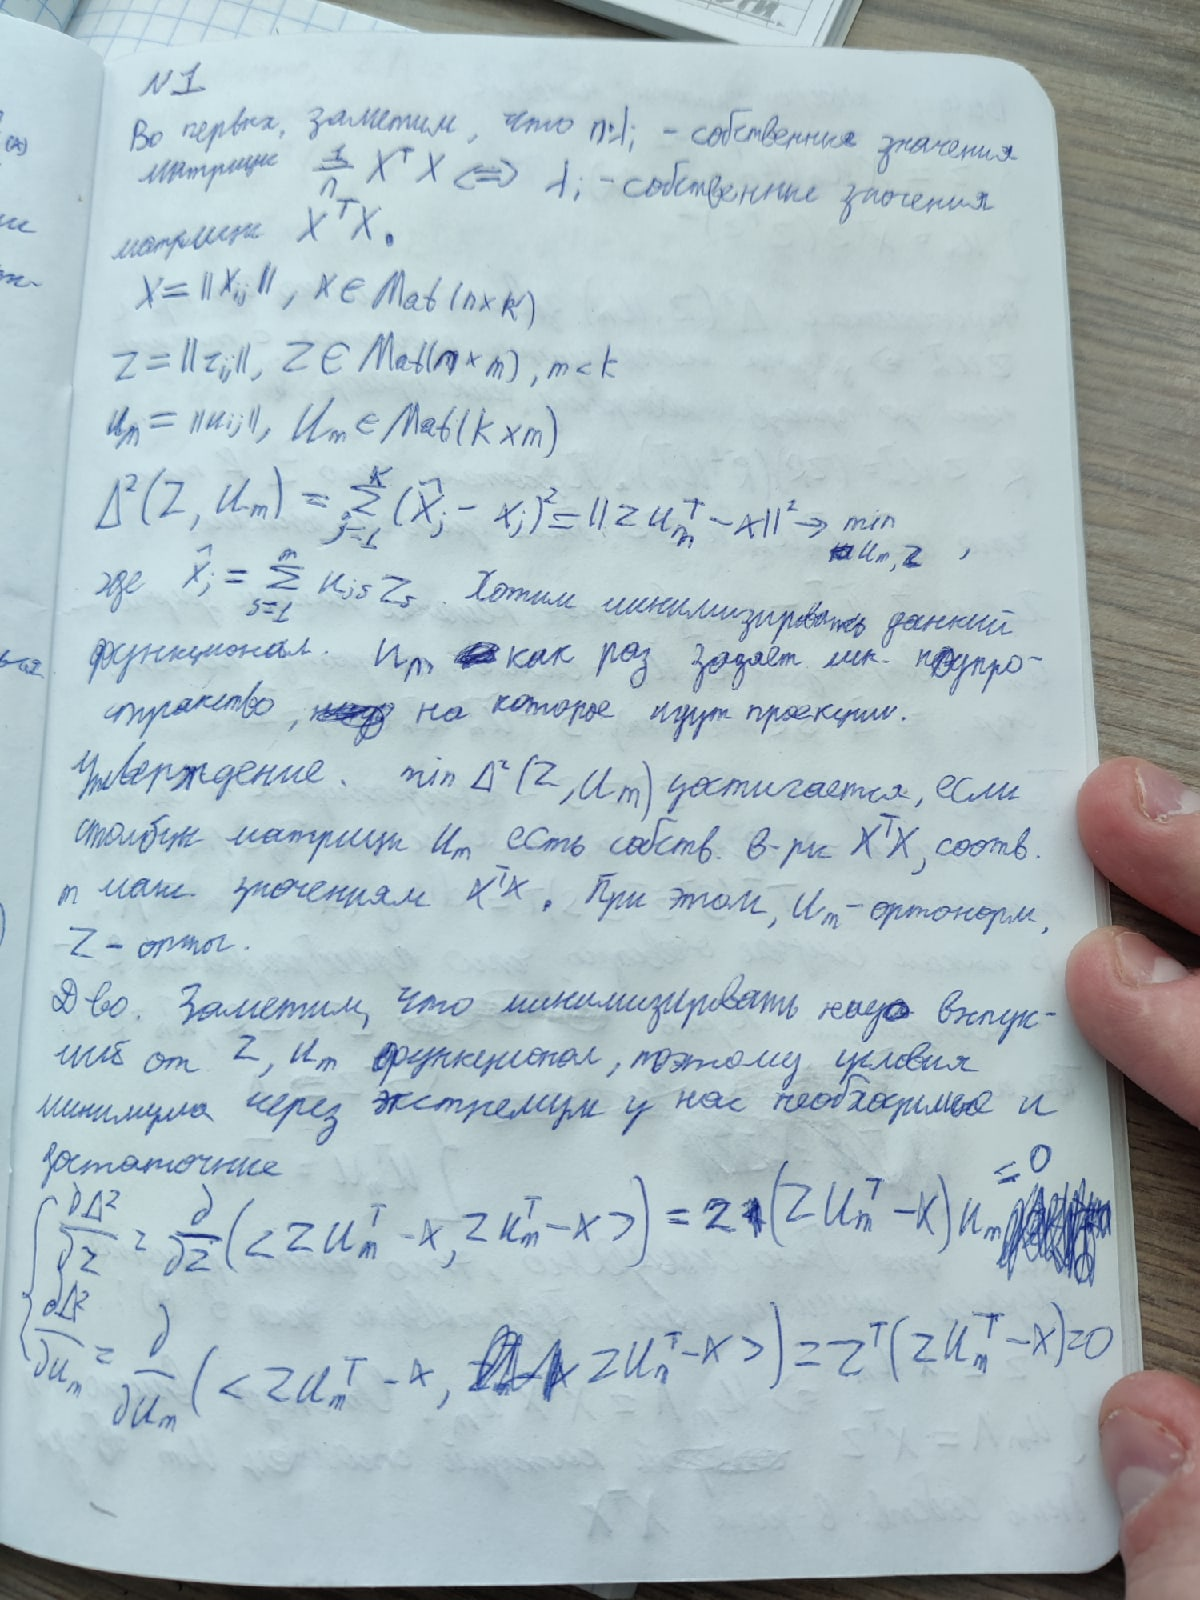

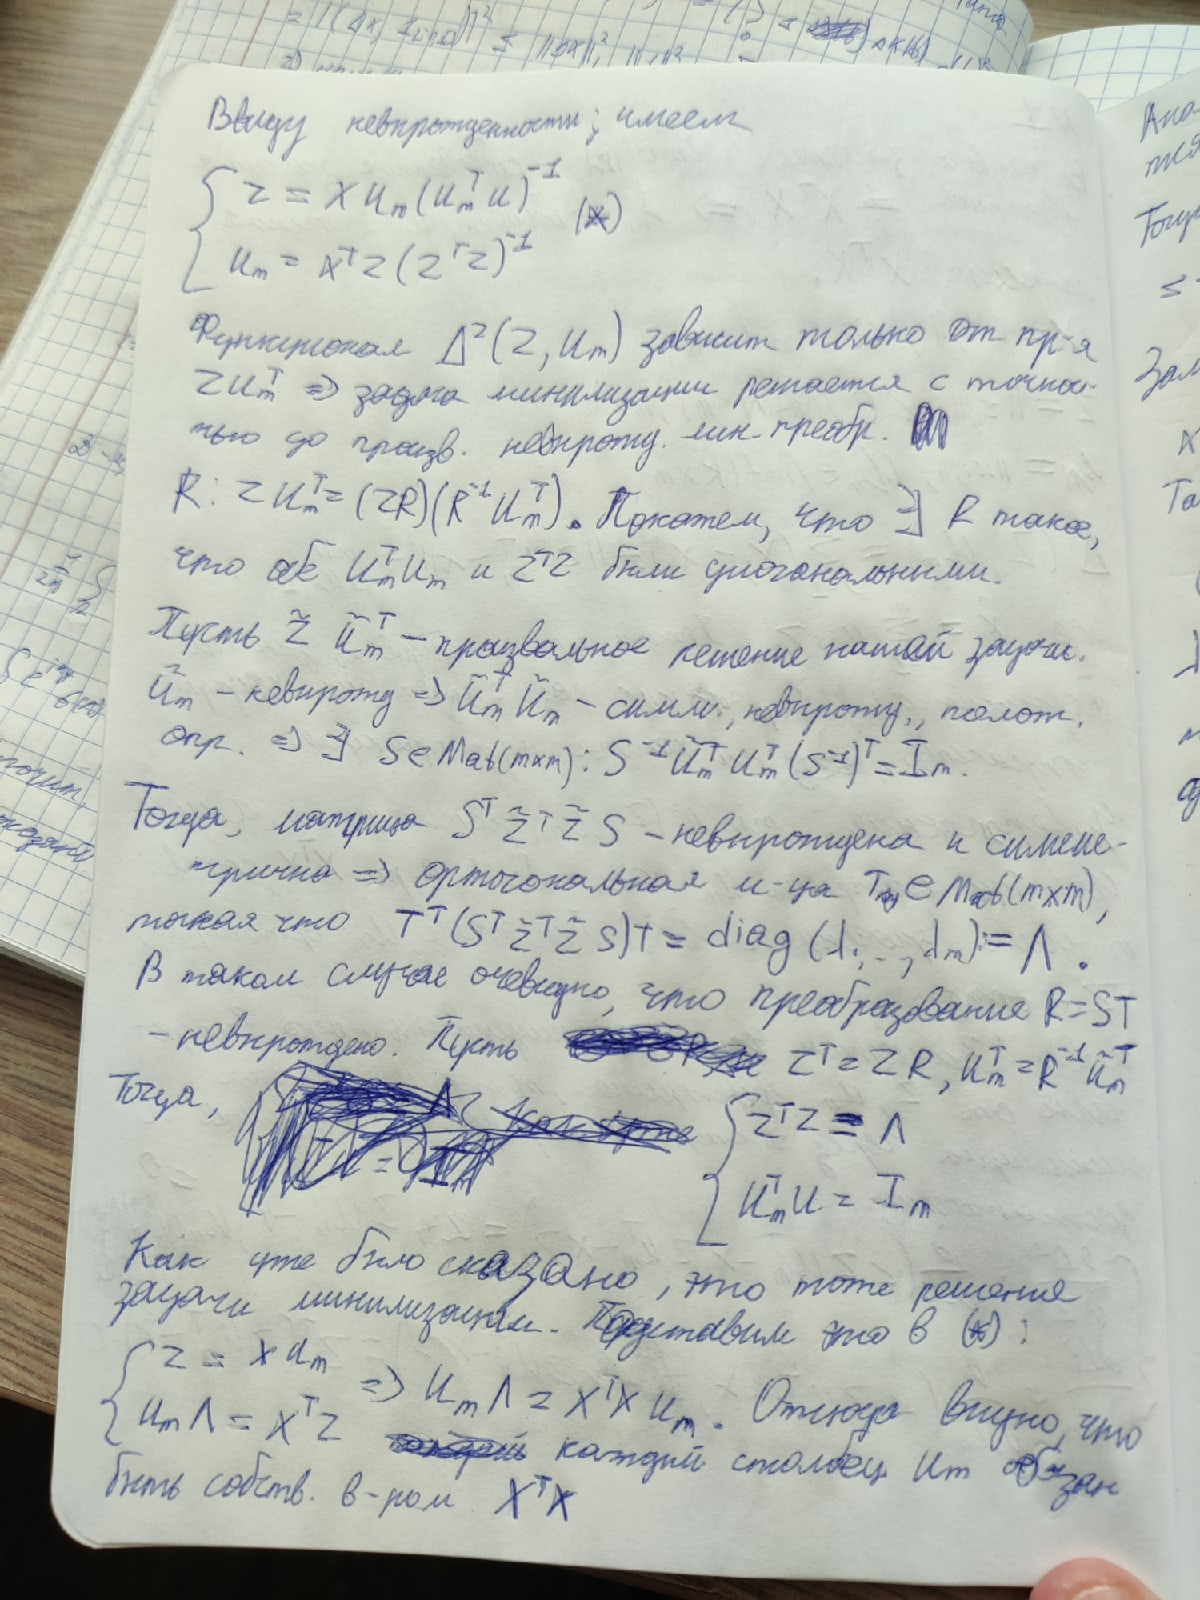

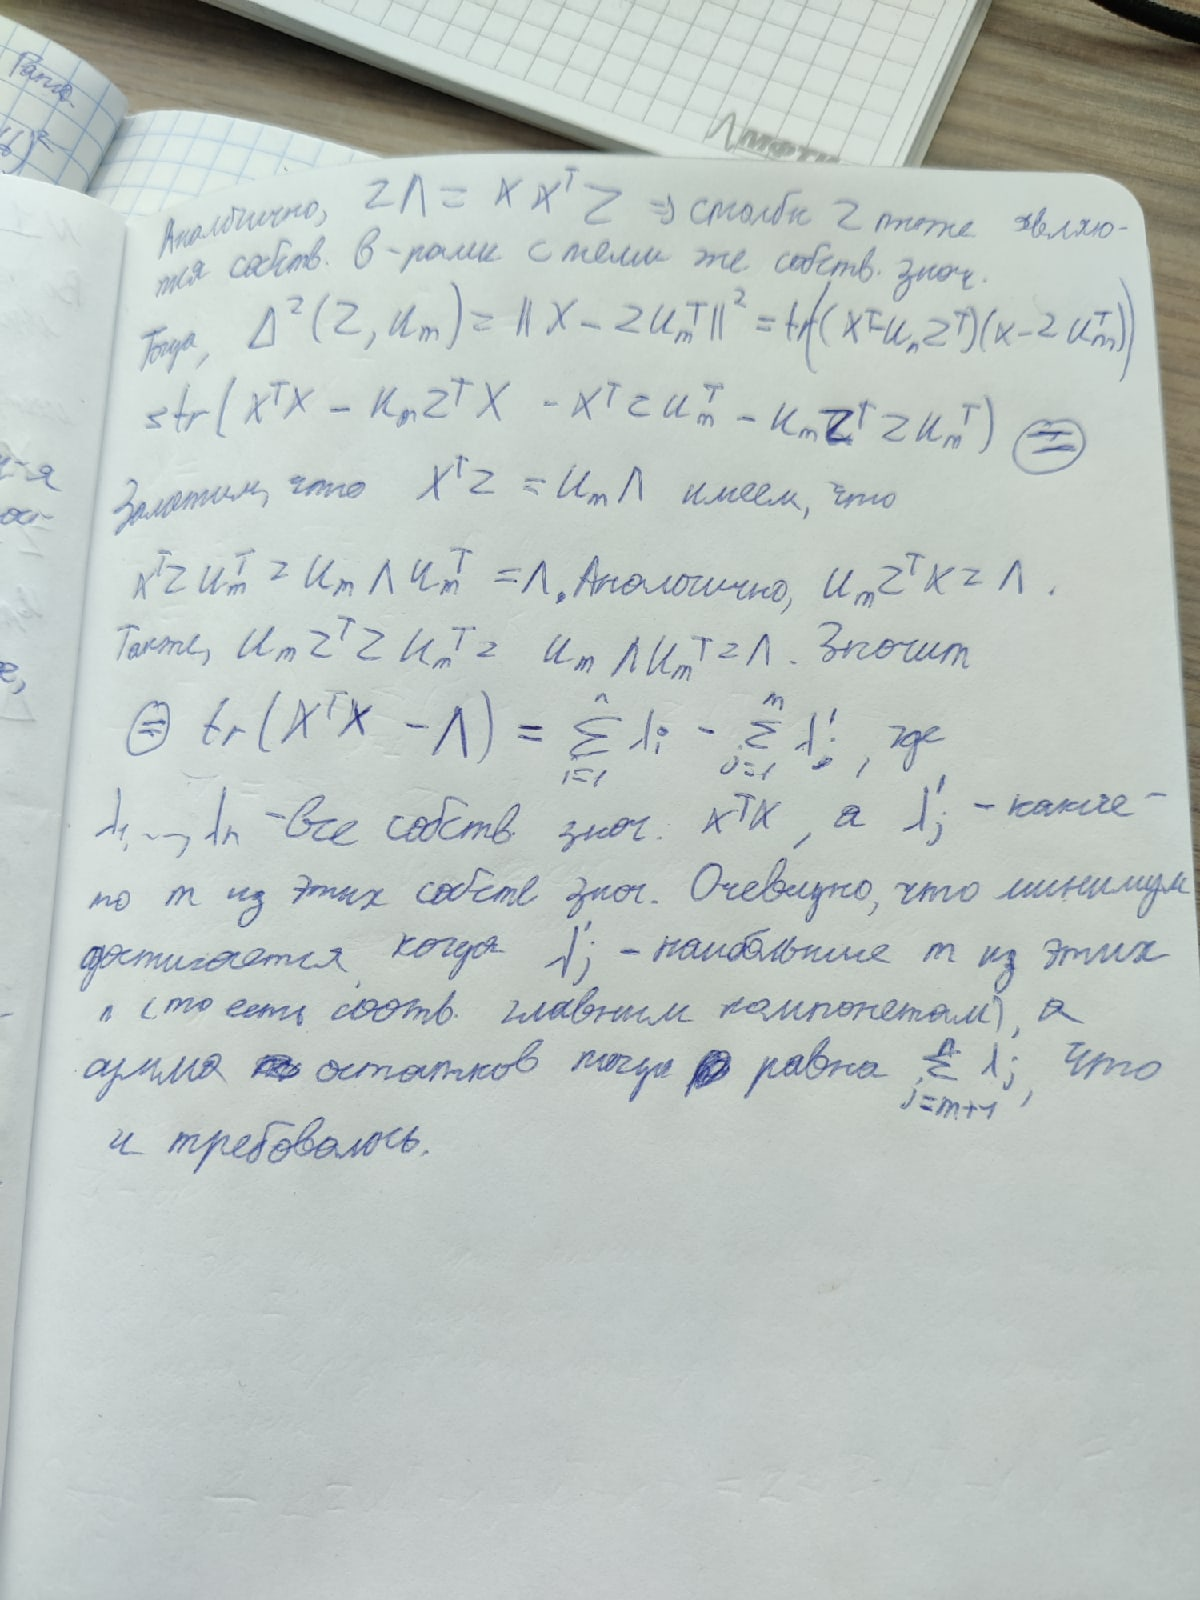

### Задача 2

Считаем данные, посмотрим на них.

In [8]:
all_data = pd.read_excel("hw11t2_train.xlsx", skiprows = [0])

In [9]:
all_data

START YEAR  START QUARTER  COMPLETION YEAR  COMPLETION QUARTER  V-1  \
0            81              1               85                   1    1   
1            84              1               89                   4    1   
2            78              1               81                   4    1   
3            72              2               73                   2    1   
4            87              1               90                   2    1   
..          ...            ...              ...                 ...  ...   
367          83              4               86                   1   20   
368          81              2               82                   4   20   
369          84              4               86                   3   20   
370          82              3               84                   4   20   
371          80              1               81                   3   20   

        V-2     V-3     V-4  V-5      V-6  ...   V-22.4   V-23.4  V-24.4  \
0    3150.0   920.0   598.5  190  1010.84  ...   815.50  1755.00  8002.0   
1    7600.0  1140.0  3040.0  400   963.81  ...  1316.30  8364.78  8393.0   
2    4800.0   840.0   480.0  100   689.84  ...   765.80  1755.00  4930.0   
3     685.0   202.0    13.7   20   459.54  ...   152.25  1442.31  1456.0   
4    3000.0   800.0  1230.0  410   631.91  ...  2244.10  9231.76  9286.0   
..      ...     ...     ...  ...      ...  ...      ...      ...     ...   
367  1350.0   350.0   108.0   80   251.37  ...  1176.50  8343.60  8382.0   
368   600.0   150.0    36.0   60   299.55  ...   815.50  1755.00  8013.0   
369  1900.0   430.0   285.0  150   364.41  ...  1584.30  8776.71  8799.0   
370   510.0   160.0    30.6   60   245.28  ...   909.20  7930.66  8004.0   
371   890.0   230.0    35.6   40   237.03  ...   764.50  1755.00  8420.0   

     V-25.4  V-26.4    V-27.4    V-28.4     V-29.4     V-9    V-10  
0     60.74   54.26   2978.26  41407.00   601988.1  2200.0   410.0  
1     90.95   89.79  11379.37  44835.00   929027.1  5000.0  1000.0  
2     38.70   32.04   1653.06  37933.00   377828.6  1200.0   170.0  
3      9.73    8.34    686.16   8194.00   122031.7   165.0    30.0  
4    136.60  140.20   9821.00  48260.00  1734973.5  5500.0   700.0  
..      ...     ...       ...       ...        ...     ...     ...  
367   87.27   85.56  10555.47  33626.25   865878.9     NaN     NaN  
368   62.78   56.45   3387.72  10646.75   606524.2     NaN     NaN  
369  101.00  101.89  13571.80  34474.50  1067772.0     NaN     NaN  
370   73.57   69.26   4756.68  21855.00   669640.3     NaN     NaN  
371   54.62   44.79   2206.19  40234.00   629797.2     NaN     NaN  

[372 rows x 109 columns]

In [10]:
all_data.isna().any()

START YEAR            False
START QUARTER         False
COMPLETION YEAR       False
COMPLETION QUARTER    False
V-1                   False
                      ...  
V-27.4                False
V-28.4                False
V-29.4                False
V-9                    True
V-10                   True
Length: 109, dtype: bool

In [11]:
all_data['V-10']

0       410.0
1      1000.0
2       170.0
3        30.0
4       700.0
        ...  
367       NaN
368       NaN
369       NaN
370       NaN
371       NaN
Name: V-10, Length: 372, dtype: float64

Разделим данные

In [12]:
all_X = all_data.drop(['V-9','V-10'], axis = 1)
data = all_data.dropna()
X, y1, y2 = data.drop(['V-9','V-10'], axis = 1), data['V-9'], data['V-10']

Для начала взглянем, что нам даст обычная линейная регрессия без понижения размерностей.

In [13]:
def make_basic_pipeline(model):
    return Pipeline([
        ("Scaler", StandardScaler()),
        ("Model", model),
    ])

In [14]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
cv_lin, _ = train_and_test_cv(model_n, None, "Linear",X, y1, False)

cv score  --  -1.754333943534451e+27


Совсем беда, будем исправлять!

Будем использовать PCA. Для начала взяглянем на график, чтобы узнать сколько компонент мы в итоге возьмем. Не забываем нормализовать данные!

In [15]:
pca  = PCA()
pca.fit(StandardScaler().fit_transform(X))

PCA()

In [16]:
def plot_explained_pca_var(X):
    pca  = PCA()
    pca.fit(StandardScaler().fit_transform(X))
    explained_var = pca.explained_variance_ratio_
    explained_var_cumsum = np.cumsum(explained_var)
    plt.figure(figsize=(14, 9))
    plt.title("Объясненная дисперсия")
    plt.bar(np.arange(1, X.shape[1] + 1), pca.explained_variance_ratio_, alpha=0.5,  
            align="center", label="доля новой объясненной дисперсии")
    plt.step(np.arange(1, X.shape[1] + 1), explained_var_cumsum,
             label="Доля объясненной дисперсии", linewidth=2, where="mid")
    plt.yticks(np.arange(0, 1.01, 0.05))
    plt.xlabel("Количество компонент")
    plt.ylabel("Доля дисперсии")
    plt.grid(axis="y")
    plt.legend()
    plt.show()

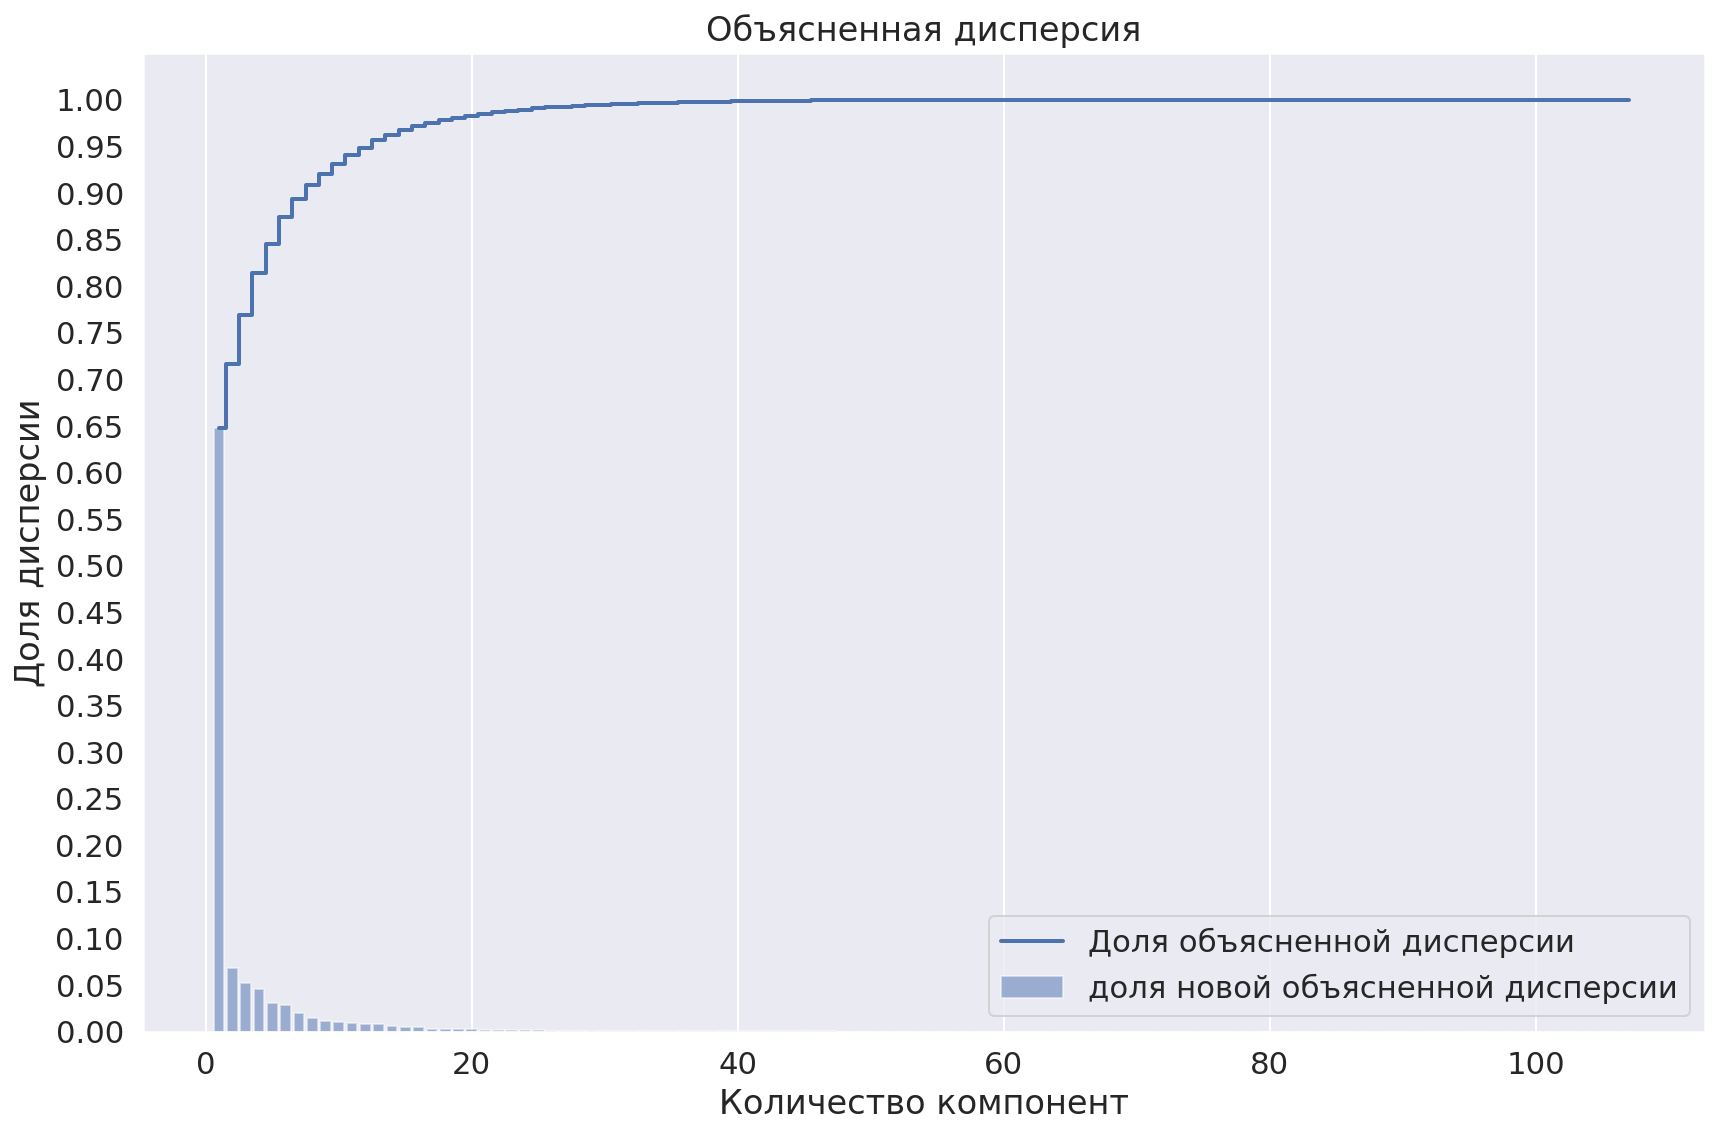

In [17]:
plot_explained_pca_var(X)

Посмотрим на график cv_score в зависимости от числа компонент. 

In [18]:
def make_pca_pipeline(num_comps,model):
    return Pipeline([
        ("Scale", StandardScaler()),
        ("PCA", PCA(n_components=num_comps)),
        ("Scale after PCA", StandardScaler()),
        ("Model", model),
    ])

In [19]:
def find_best_params(model, params_grid, X_train, y_train):
    searcher = GridSearchCV(model,params_grid,scoring='neg_mean_squared_error')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        searcher.fit(X_train, y_train)

    print("Best parameters:", searcher.best_params_)
    model = searcher.best_estimator_
    #model.fit(X_train, y_train)
    return model

In [20]:
%%capture
cv_score1 = []
cv_score2 = []
models = []
for num in range(1, X.shape[1] + 1):
    model1 = make_pca_pipeline(num, LinearRegression(fit_intercept=True))
    cv_lin1, _ = train_and_test_cv(model1, None, "Linear", X, y1, False)
    cv_score1.append(cv_lin1)
    models.append(model1)
    model2 = make_pca_pipeline(num, LinearRegression(fit_intercept=True))
    cv_lin2, _ = train_and_test_cv(model2, None, "Linear", X, y2, False)
    cv_score2.append(cv_lin2)

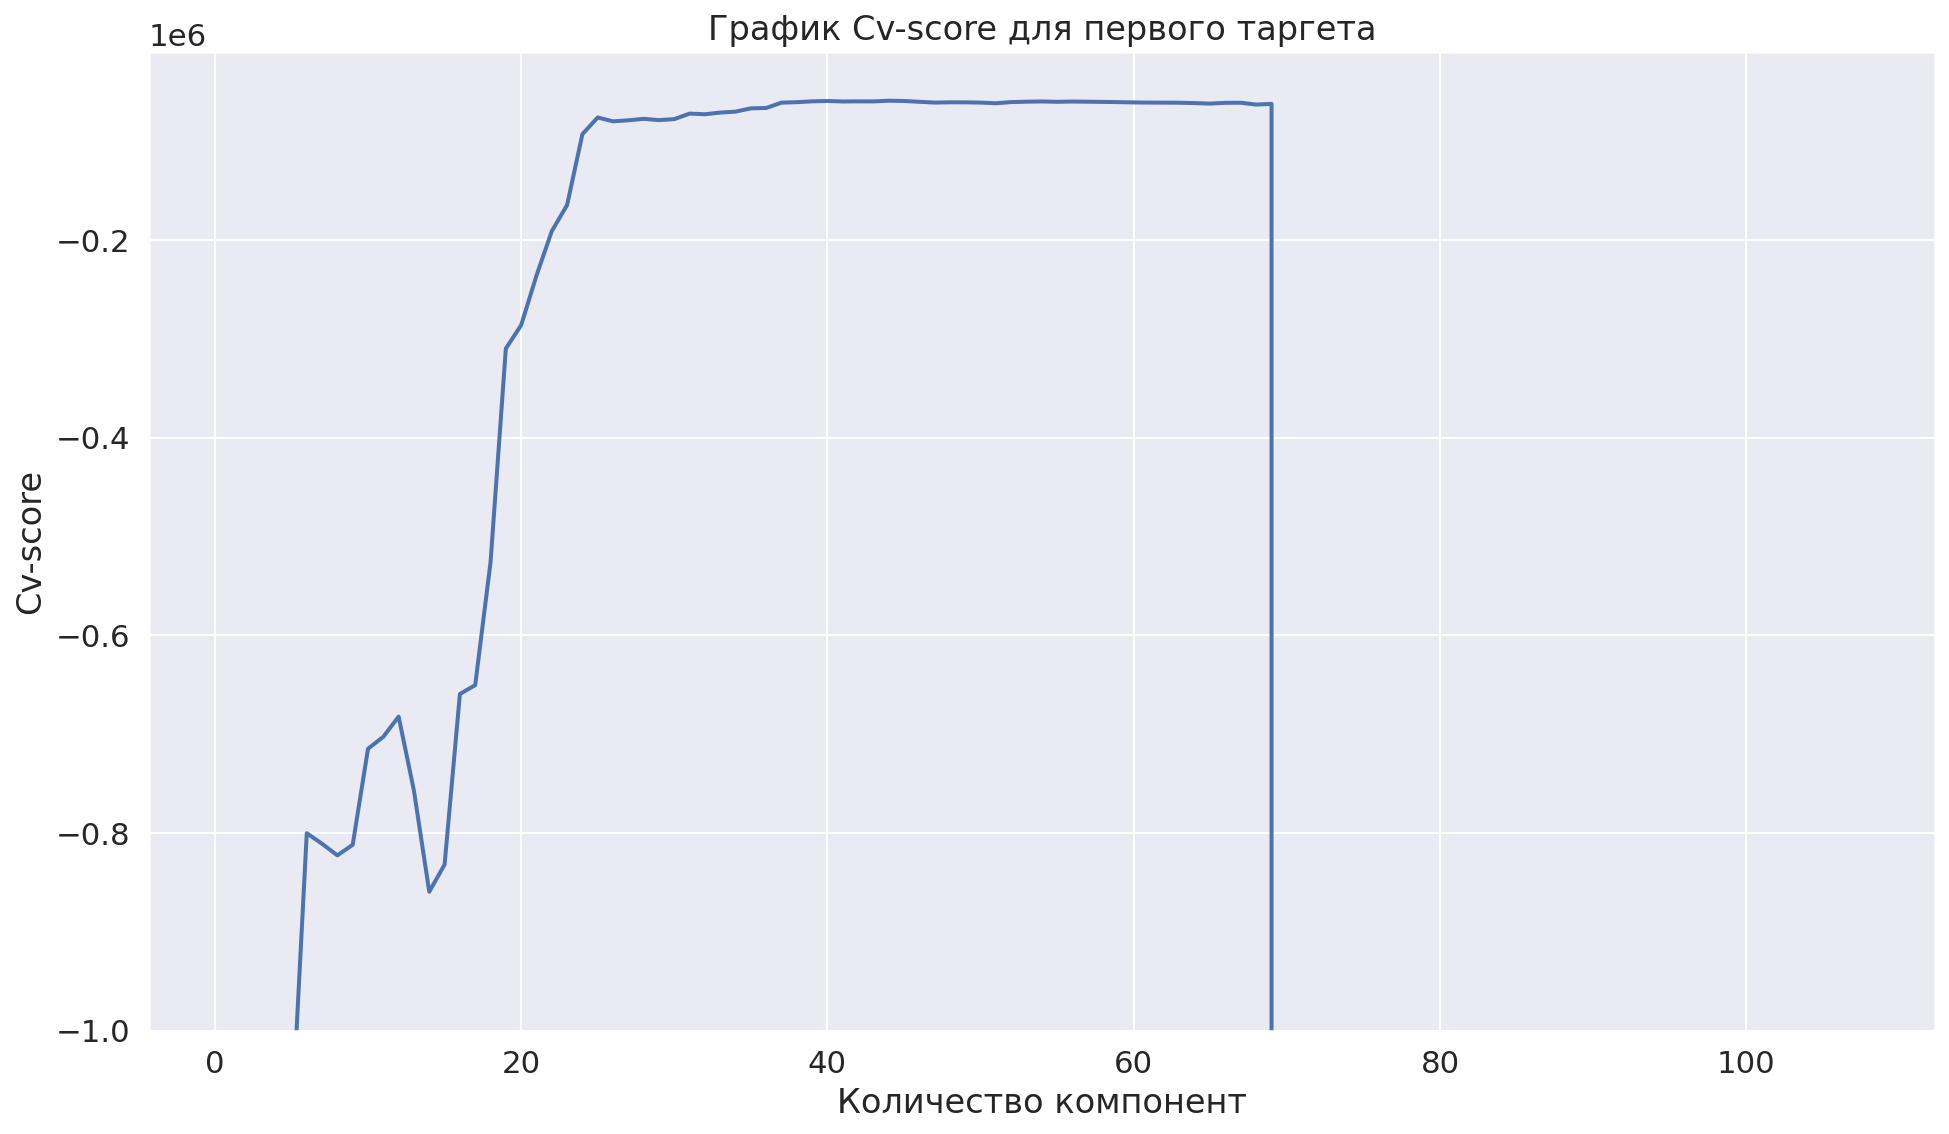

In [21]:
plt.figure(figsize = (16, 9))
plt.title("График Cv-score для первого таргета")
plt.plot(np.arange(1, X.shape[1] + 1), cv_score1, linewidth = 2)
plt.xlabel("Количество компонент")
plt.ylabel("Cv-score")
plt.ylim(-1e6, -1e4)
plt.show()

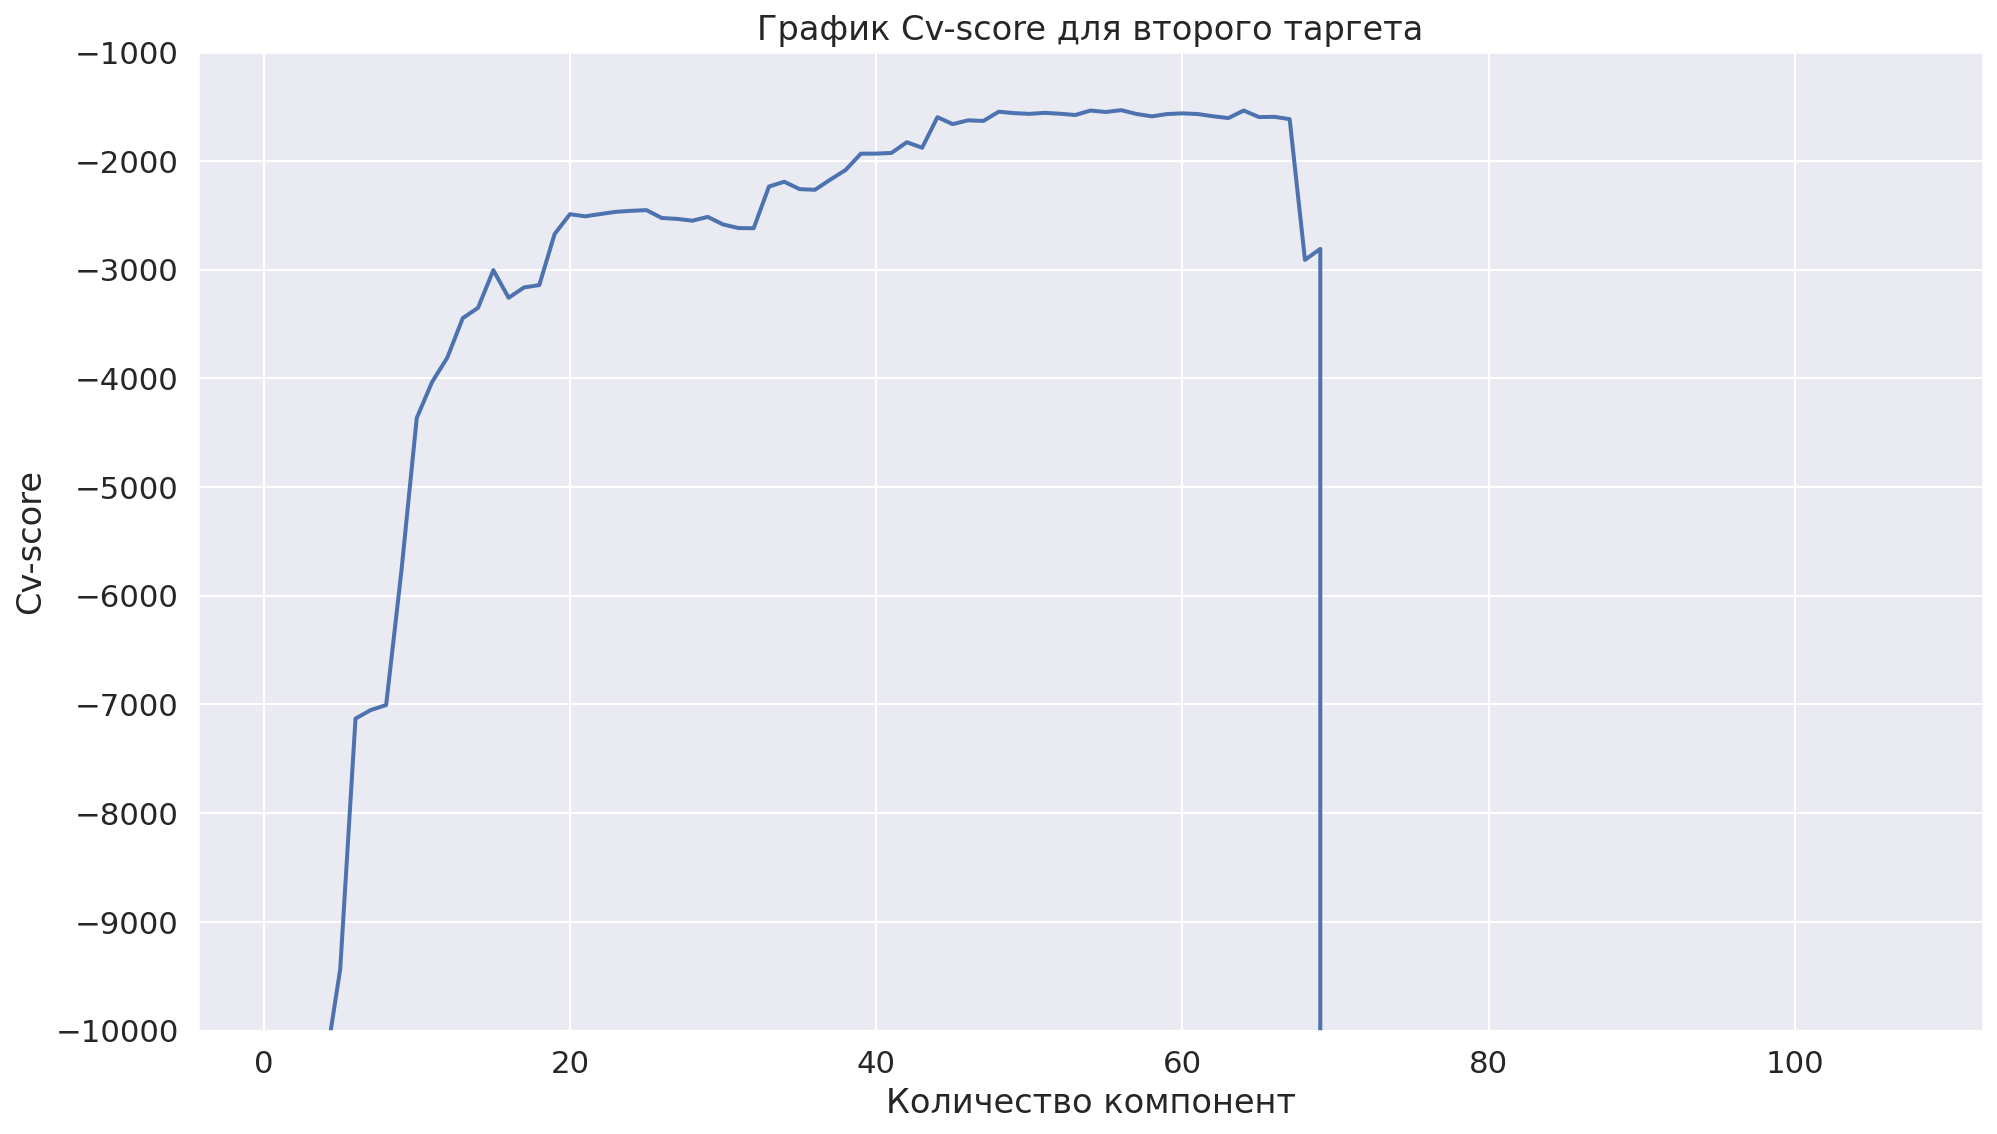

In [22]:
plt.figure(figsize = (16, 9))
plt.title("График Cv-score для второго таргета")
plt.plot(np.arange(1, X.shape[1] + 1), cv_score2, linewidth = 2)
plt.xlabel("Количество компонент")
plt.ylabel("Cv-score")
plt.ylim(-1e4, -1e3)
plt.show()

Графики получились подобные, поэтому будем по одному таргету судить о числе компонент.

In [23]:
num_comps = np.argmax(np.array(cv_score1))
print(f"Лучшее число компонент -- {num_comps + 1}")
print(f"Лучший score для первого таргета-- {cv_score1[num_comps]}")
print(f"Лучший score для второго таргета-- {cv_score2[num_comps]}")
print(models[num_comps].score(X, y1))

Лучшее число компонент -- 44
Лучший score для первого таргета-- -59155.47524957538
Лучший score для второго таргета-- -1598.5892175549602
0.9881907290478096


Получили достаточно интересный результат. Если сравнить этот график с графиком объясненной дисперсии, то видно, что лучший результат как раз достигается при числе компонент, когда объясненная дисперсия совсем перестает расти. Затем идет резукий спад, который, скорее всего, объясняется мультиколлинеарностью признаков. При этом, мы посчитали $R^2$, который близок к 0.99, а значит нет смысла отказываться от линейной модели.  попробуем провести регуляризацию. 



In [24]:
parameters = {'Model__alpha': np.append(np.arange(1, 10, 0.15), np.logspace(-6, -3, 4))}
model = make_pca_pipeline(num_comps, Lasso(fit_intercept=True))
cv_lin, best_l1 = train_and_test_cv(model, parameters, "Linear", X, y1, True)

Best parameters: {'Model__alpha': 6.399999999999997}
cv score  --  -52907.52552636421


In [25]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 20.1, 0.2), np.logspace(-6, -3, 4))}
model = make_pca_pipeline(num_comps, Ridge(fit_intercept=True)) 
cv, best_r1 = train_and_test_cv(model, parameters, "Ridge",X, y1, True)

Best parameters: {'Model__alpha': 6.800000000000001}
cv score  --  -52484.97347441508


In [26]:
parameters = {'Model__alpha': np.append(np.arange(1, 10, 0.4), np.logspace(-8, -3, 4))}
model = make_pca_pipeline(num_comps, Lasso(fit_intercept=True))
cv_lin, best_l2 = train_and_test_cv(model, parameters, "Linear", X, y2, True)

Best parameters: {'Model__alpha': 0.001}
cv score  --  -1879.9353335376256


In [27]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 10.1, 0.4), np.logspace(-8, -3, 4))}
model = make_pca_pipeline(num_comps, Ridge(fit_intercept=True)) 
cv, best_r2 = train_and_test_cv(model, parameters, "Ridge",X, y2, True)

Best parameters: {'Model__alpha': 1e-08}
cv score  --  -1879.769614255333


Как видим, в обоих случаях регуляризация помогает. Сохраним результат. 

In [28]:
res1 = best_r1.predict(all_X.values)
res2 = best_r2.predict(all_X.values)
res_fr = pd.DataFrame({'V-9': res1, 'V-10': res2})
res_fr.to_csv("h11t2_res.csv", index = True)

### Задача 3

Считаем данные, посмотрим на таблицу.

In [29]:
all_data = pd.read_csv("hw11t3_train.csv",)
all_data

Unnamed: 0  Washington     Carter    Clinton   Bush jr.  Roosevelt  \
0             0    3.734073  -9.457681  27.549700 -11.985751   1.901486   
1             1    2.551721 -24.627005 -15.520941  12.029495   3.703952   
2             2    2.918376   5.445903  33.389551   2.186544   1.409118   
3             3    2.560226  13.506337  25.484365  11.080659   1.083449   
4             4    2.424035 -19.448434 -30.360407   7.138340   4.142661   
..          ...         ...        ...        ...        ...        ...   
413         495    0.339454  23.832744 -35.043147  12.376436   5.309632   
414         496    2.436066 -20.302804  22.255698  13.342079   2.310339   
415         497    2.715378  20.454642 -18.670270   7.727907   5.543363   
416         498    2.976920 -20.898231  24.128775   1.804173   2.284570   
417         499    0.445265  26.716508  17.490305  -0.176716   0.579646   

          Tucker     Trump  Eisenhower     Reagan       Ford      Nixon  \
0    -669.538235  6.072319   -1.046536  -1.850577  -8.462503  28.644939   
1     365.589767  6.115587   -0.834076  12.575440   4.661140  16.216623   
2   -1085.204284  2.380016    3.450318   0.168421 -29.750741  45.294247   
3    -467.031753  5.876512   -1.977780   3.577079  -6.203411  29.395979   
4    -543.512743  3.921131   -3.514755   6.543723 -37.061819  42.713911   
..           ...       ...         ...        ...        ...        ...   
413  -660.022493  4.223284   -4.413768  13.112010 -89.094444  54.524493   
414   -83.112254  6.197968   -0.425573   9.136327  -0.761442  22.436810   
415    69.813392  5.624120   -3.061890   6.160020  20.448242  28.045443   
416  -145.461725  1.938398    4.665959   1.869597 -57.969855  45.899947   
417   407.861000  4.315821   -4.611961  -0.302252  42.189568  38.760487   

        Johnson     Kennedy  
0    165.300587  -59.154245  
1    -98.009037 -146.352608  
2     84.329562   -9.409634  
3    147.616360  -98.203858  
4   -133.607567 -121.587831  
..          ...         ...  
413 -171.432633 -251.565386  
414  136.956876 -106.632996  
415 -121.977013 -129.081371  
416   57.430891  -92.497813  
417   72.811725 -138.121126  

[418 rows x 14 columns]

In [30]:
all_data.isna().any()

Unnamed: 0    False
Washington    False
Carter        False
Clinton       False
Bush jr.      False
Roosevelt     False
Tucker        False
Trump         False
Eisenhower    False
Reagan        False
Ford          False
Nixon         False
Johnson       False
Kennedy       False
dtype: bool

Признаков не супер много, возможно даже не сильно понадобится понижение размерности. Для начала разобьем выборку и попробуем обойтись без понижения размерностей.

In [31]:
data = all_data.drop(['Washington', 'Unnamed: 0'], axis = 1)
target = all_data['Washington'].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state = 1)

In [33]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
cv_lin, _ = train_and_test_cv(model_n, None, "Linear",X_train, y_train, False)
print("R^2 score -- ", model_n.score(X_train, y_train))

cv score  --  -0.7075406148009704
R^2 score --  0.5410598024425358


In [34]:
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.5803443506442539

$R^2$ не очень большой, значит модель не очень хорошо описывается линейной зависимостью. Попробуем нелинейную модель.

In [35]:
def grid_kernel(ker, grid, X, y):
    best_gamma = -5
    best_score = -1000000
    grid = np.linspace(1e-5, 8, 200)
    for g in grid:
        model = make_basic_pipeline(KernelRegression(kernel = ker, gamma = g))
        cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=4).mean()
        if cv_score > best_score:
            best_gamma = g
            best_score = cv_score
    return best_gamma, best_score

In [36]:
best_gamma, best_score =  grid_kernel('laplacian', np.linspace(1e-5, 8, 100), X_train , y_train)
best_gamma,best_score

(1.3266415075376885, -0.4763241257534605)

In [37]:
model_best =  KernelRegression(gamma = best_gamma,kernel = "laplacian")
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)
print(y_pred)
sklearn.metrics.mean_squared_error(y_test[~np.isnan(y_pred)], y_pred[~np.isnan(y_pred)])

[0.95211714 0.96759122 2.03072079 2.91364465 0.15193797 1.67658898
 1.48717725 0.85850573 0.59710124 0.67044765        nan 0.31019172
 1.19659969 2.3457124  0.73466755 3.53755361 0.40072206 3.04577137
 1.67658898 2.99030182 2.99030182 3.2614391  3.63134435 3.074578
 0.91141133 1.23990462 1.81485714 0.42318829 3.36497091 0.47941443
 3.09959888 1.15976262        nan 3.30194427 3.63995893 2.98901378
 1.71921063 2.75930713 2.79849189 1.81938093 1.73228101 1.80906121
 0.40072206 0.92010085 0.48411    0.47456495 1.1700663  3.04355529
 3.30083937 2.50692712 3.55624902 1.50166793 2.66813864 3.85629981
 1.82576026 0.91141133 2.84536304 0.18610983 0.20178842 2.45339376
 0.14165867 1.21979333 3.04348097 1.73228101 0.51130006 1.73228101
        nan 0.64921516 0.85850573 3.97408021 0.7624154  2.45339359
 3.02212348 3.09959888 0.22077839 1.81880513 0.41105247 3.54777501
 2.03064961 0.22888786 2.74955168 1.13285372 1.66178938 0.24092179]


1.2733378034042357

Как видим, мало того что преугадываются Nan, дак еще и с выбросом этих результатов скор на тесте никакой. 

Добавим еще алгоритм с возвратом.

In [38]:
def grid_returning(ker, grid_it, grid_g, X, y):
    X_s = StandardScaler().fit_transform(X)
    best_gamma = -5
    best_it = -1
    best_score = -10000
    for iters in grid_it:
        for g in grid_g:
            model = Returning(g = g, num_iter=iters, ker = ker)
            cv_score = cross_val_score(model,X_s, y, scoring='neg_mean_squared_error', cv=5).mean()
            if cv_score > best_score:
                best_gamma = g
                best_score = cv_score
                best_it = iters
    print(f"Best gamma -- {best_gamma}, best number of iters -- {best_it} ")
    print("Cv_score -- ", best_score)
    return best_it, best_gamma, best_score

In [39]:
best_it, best_gamma, best_score = grid_returning('laplacian', np.arange(1, 5), 
                                                 np.linspace(1e-5, 10, 100), X_train, y_train)
best_score

Best gamma -- 5.454549999999999, best number of iters -- 4 
Cv_score --  -0.46505806773304714


-0.46505806773304714

In [40]:
model_best =  Returning(g = best_gamma, num_iter=best_it, ker = "laplacian")
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)
print(y_pred)
sklearn.metrics.mean_squared_error(y_test[~np.isnan(y_pred)], y_pred[~np.isnan(y_pred)])

[ 1.05186961  1.68754849  2.8373073   3.42350742  0.50171161  0.30966471
  1.40559082  0.75410379  1.90046159  2.49661114  0.22854096  1.70590952
 -0.96661947  2.98259606  1.42909906  1.51093963  2.05620292  2.01834965
  1.35705351  2.80857702  1.87309023  1.10049081  3.19671345  2.09080101
  0.73771601  1.23903174 -0.04243237  0.89251561  0.86039964  1.29630378
  1.21154656 -0.8662131   1.40029653  2.52672196  2.30508297  1.48314252
  1.33149961  1.86121542  1.87037895  1.85795751  1.67818464  2.92634184
  1.71175498  0.18205546  1.34708218  1.02999323  3.322946    3.55085219
  0.35401278  1.10017434  3.19235921  2.01925336  3.55530111  2.46668622
  1.7241349          nan  2.6512144   1.18260523 -1.23503247  0.75896868
  1.43794228  2.38769831  2.68997054  1.06674981  0.43321824  0.25144251
  0.27149446  0.20177417  0.11839211  2.77114493  2.45110023  2.82031567
  0.73492001  3.07863995  0.8876629   1.71016619  1.49925694  2.93813692
  1.16476367  0.8378015   2.6526505   2.71042375  0

0.9751104661783084

Снова нелучший результат.Будем ориентироваться на на скор, полученный линейной моделью.

Будем понижать размерность. Посмотрим, что скажет график объясненной дисперсии в PCA.

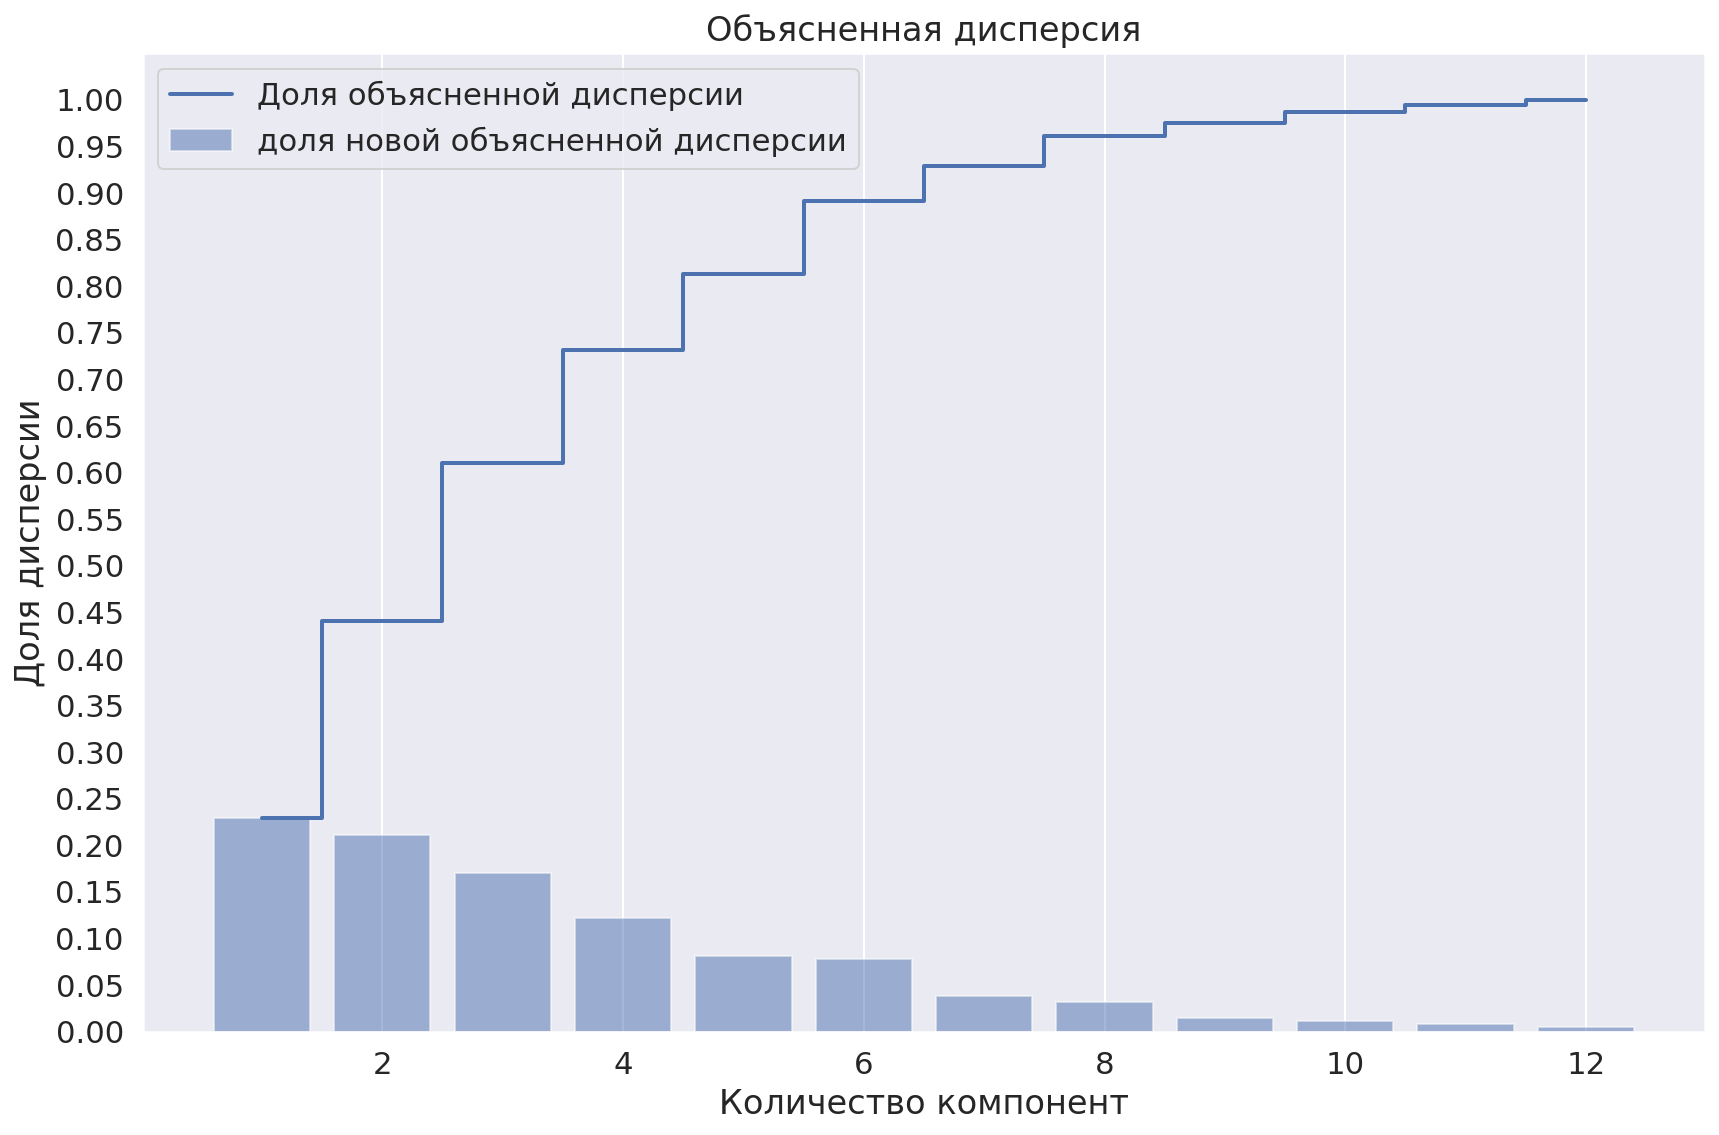

In [41]:
plot_explained_pca_var(X_train)

С 9 фич уже объясняется более 95 процентов. Попробуем взять 9 фич.

In [42]:
num_features = 9
pca = PCA(n_components=num_features)
scaler = StandardScaler()
X_train_s = pca.fit_transform(scaler.fit_transform(X_train))
model = make_basic_pipeline(LinearRegression(fit_intercept=True))
train_and_test_cv(model, None, "Linear", X_train_s, y_train, False)

cv score  --  -0.6908169947275817


(-0.6908169947275817,
 Pipeline(steps=[('Scaler', StandardScaler()), ('Model', LinearRegression())]))

In [43]:
cols = [f"{i}"for i in range(1, num_features + 1)]
X_train_s = pd.DataFrame(data = X_train_s, columns = cols)
X_train_s

1         2         3         4         5         6         7  \
0    1.688512 -0.777384 -2.286527 -1.464983  1.734326 -0.823245  0.459626   
1   -0.384781  1.508864  1.463027  1.662210 -0.088343 -1.230827 -0.615581   
2    1.729252 -1.090371  3.123722  1.383153 -0.013474 -0.934521  1.219102   
3    3.770332 -1.966326  2.423494 -1.544353 -0.588298  0.301208 -0.616548   
4   -0.376245  1.076072  0.942782  0.226167 -0.799701 -1.144323 -0.490242   
..        ...       ...       ...       ...       ...       ...       ...   
329  3.367661 -0.473131 -2.124806 -1.179975 -0.186223  0.949466 -0.219794   
330 -0.216566  2.108447  1.101063 -1.096287 -0.676429 -0.133226 -0.407162   
331  0.064680 -1.602043  1.248553 -1.419632 -0.211787 -0.763790 -0.260569   
332  1.854814 -1.975895  2.314389 -2.001962 -0.292346  0.623016  0.466330   
333  0.496316 -0.980715  2.080793  2.992056 -0.801423  0.561199  0.905733   

            8         9  
0   -0.087449 -0.104405  
1   -0.247970  0.142886  
2    0.494501 -0.060230  
3    1.383263  0.616202  
4   -0.276181 -0.529138  
..        ...       ...  
329 -0.331279 -0.062127  
330 -0.462877 -0.154285  
331  0.474443  0.634419  
332  0.568271  0.549655  
333 -0.456487  0.269773  

[334 rows x 9 columns]

Скор не упал, размерность понизилась, неплохо. Попробуем на остатки посмотреть.

In [44]:
def find_student_remainders(model, X, y):
    vals = sklearn.preprocessing.normalize(X)
    H = vals.dot(np.linalg.inv(vals.T.dot(vals))).dot(vals.T)
    rss = ((y - model.predict(X))**2).sum()
    std = rss / (vals.shape[0] - vals.shape[1] - 1)
    err = (y - model.predict(X)) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return err

In [45]:
err = find_student_remainders(model, X_train_s, y_train) 

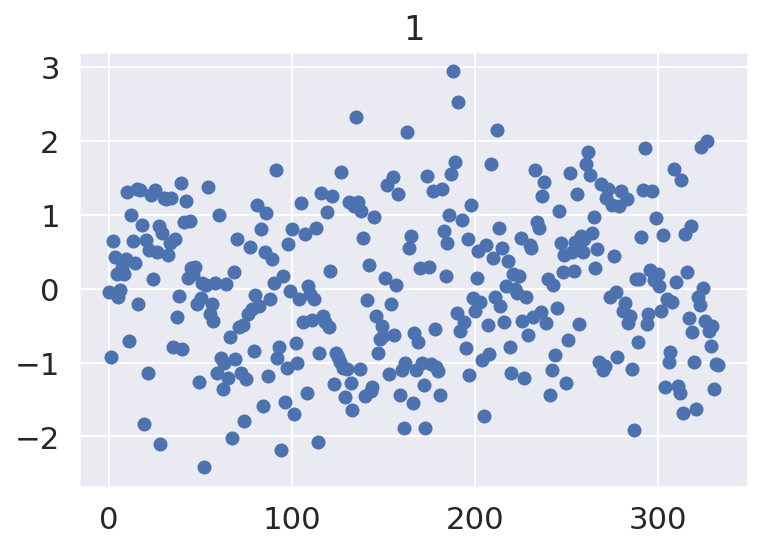

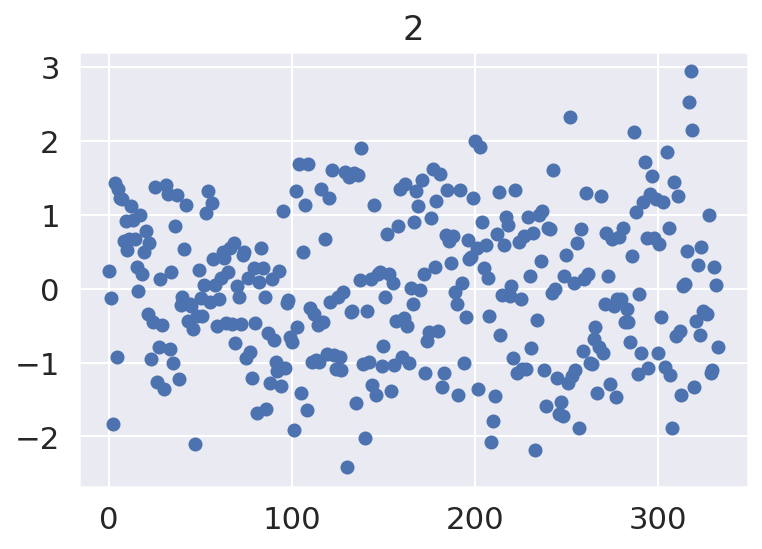

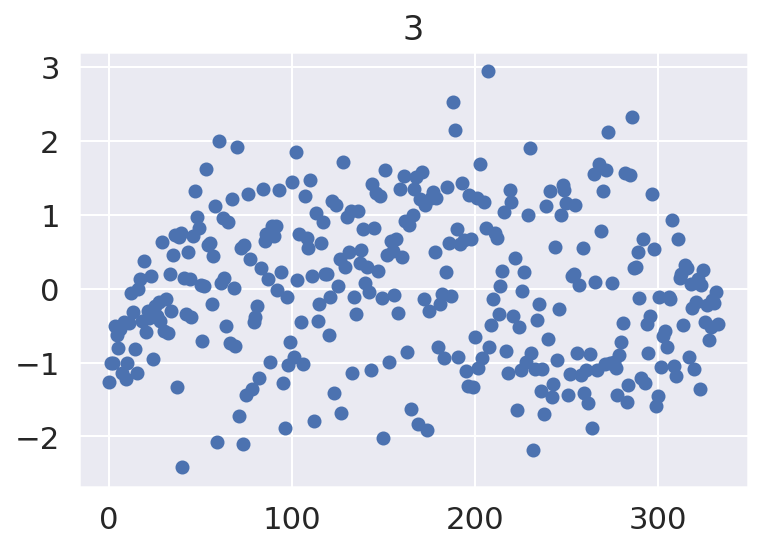

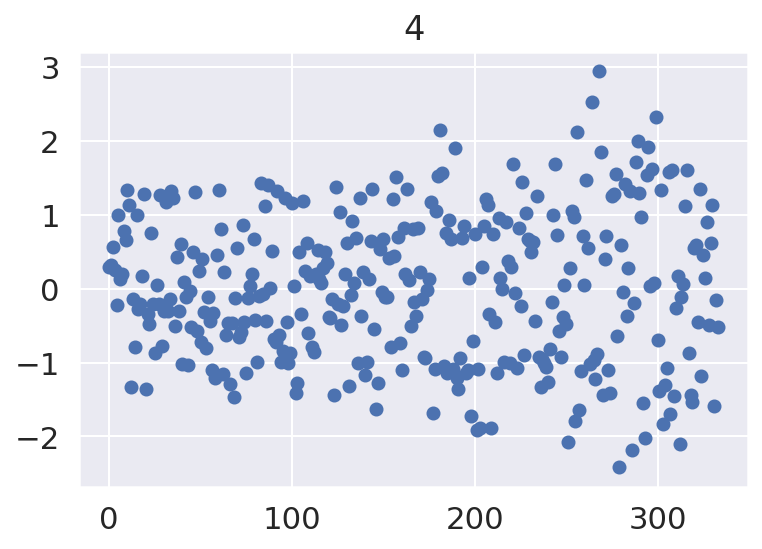

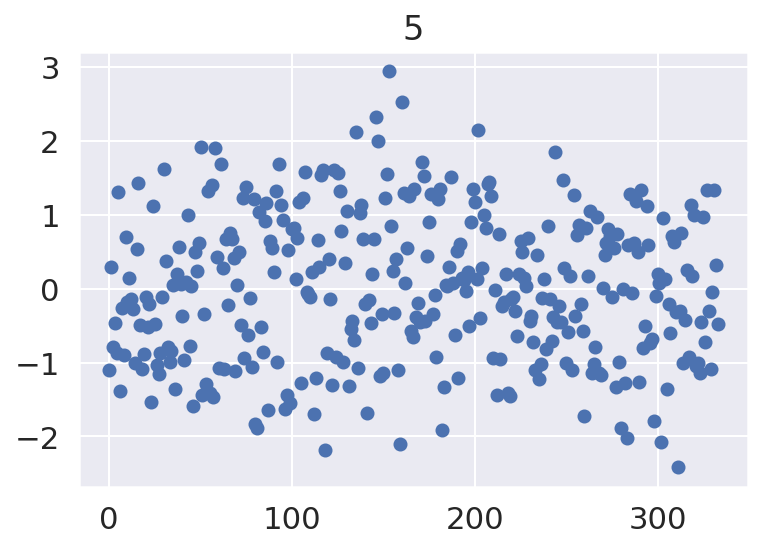

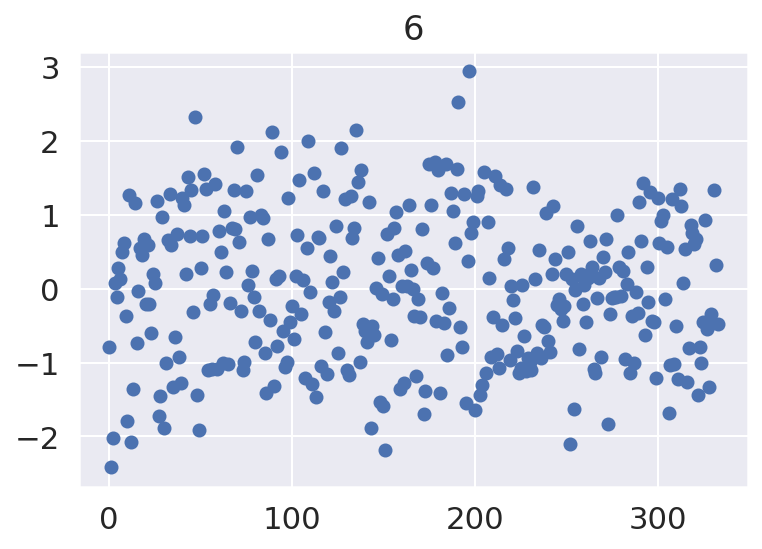

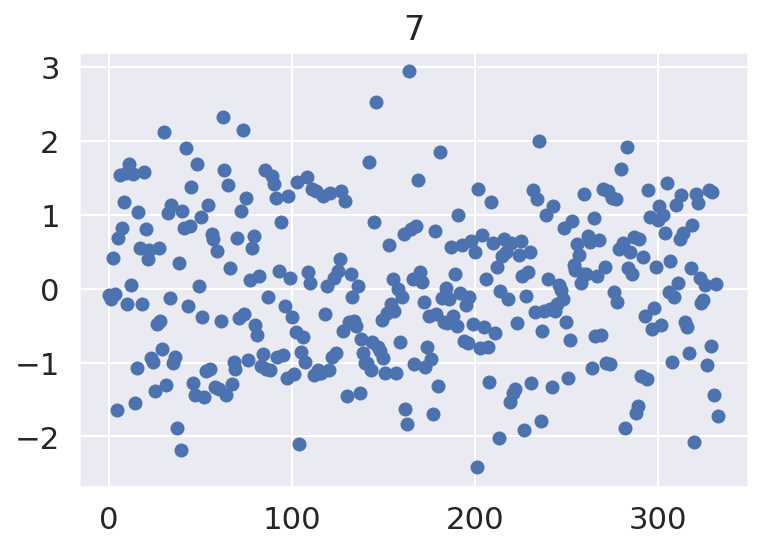

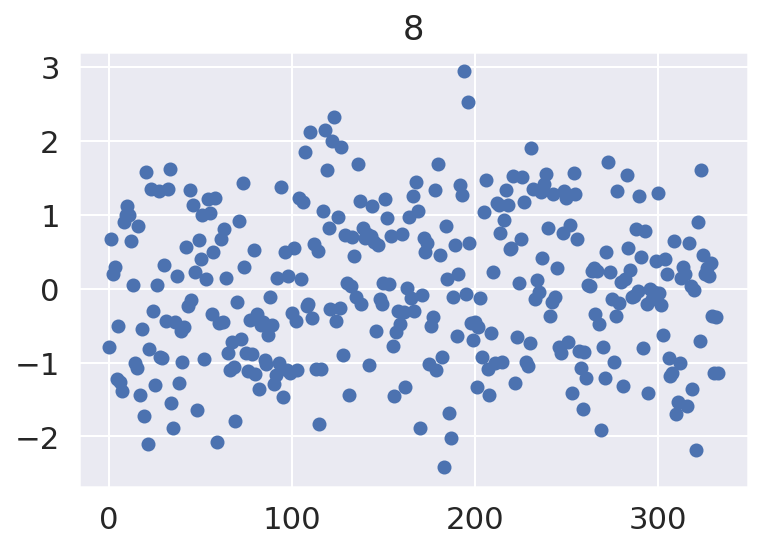

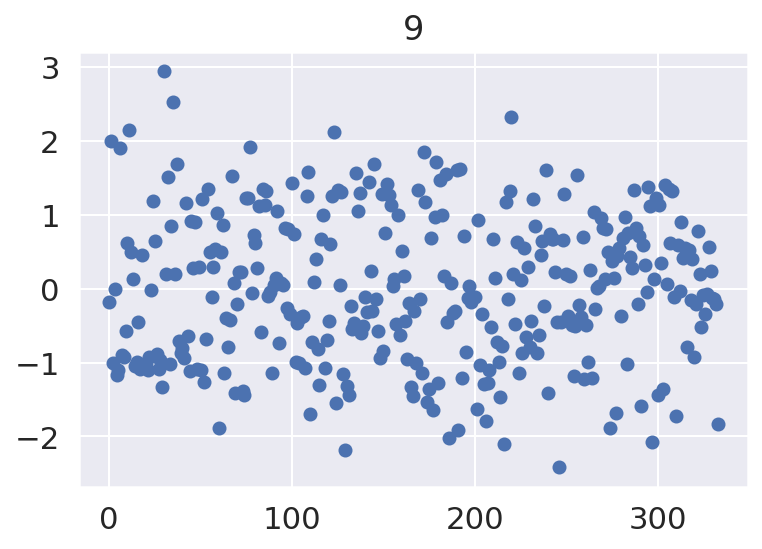

In [46]:
for i in range(X_train_s.shape[1]):
    plt.figure()
    plt.plot(err[X_train_s.values[:, i].argsort()], 'o')
    plt.title(X_train_s.columns[i])

In [47]:
cols_sqr = ["2", "3", "9"]
X_train_s_mod = X_train_s.copy()
for col in cols_sqr:
    X_train_s_mod[col + "sqr"] = X_train_s[col] ** 2
model_opt = make_basic_pipeline(LinearRegression(fit_intercept=True))
train_and_test_cv(model_opt, None, "Linear", X_train_s_mod, y_train, False)   

cv score  --  -0.6440552111006804


(-0.6440552111006804,
 Pipeline(steps=[('Scaler', StandardScaler()), ('Model', LinearRegression())]))

In [48]:
model_opt.fit(X_train_s_mod, y_train)
X_test_pca = pca.transform(scaler.transform(X_test))
X_test_pca = pd.DataFrame(data = X_test_pca, columns=cols)
for col in cols_sqr:
    X_test_pca[col + "sqr"] = X_test_pca[col] ** 2
y_pred = model_opt.predict(X_test_pca)
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.556715103545738

In [49]:
parameters = {'Model__alpha': np.append(np.arange(1, 10, 0.15), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Lasso(fit_intercept=True))
cv_lin, best_l1 = train_and_test_cv(model, parameters, "Linear", X_train_s_mod, y_train, True)

Best parameters: {'Model__alpha': 0.001}
cv score  --  -0.6440182152313387


In [50]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 20.1, 0.2), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Ridge(fit_intercept=True)) 
cv, best_r1 = train_and_test_cv(model, parameters, "Ridge",X_train_s_mod, y_train, True)

Best parameters: {'Model__alpha': 9.6}
cv score  --  -0.6429841251338783


Как видим, регуляризация не очень помогла. Попробуем другие методы понижения размерностей. Например, Isomap.

In [51]:
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA

In [52]:
def isomap_vals(X, comps, neigh):
    isomap = Isomap(n_neighbors=neigh, n_components=comps)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    isomap.fit(X_train_s)
    x_train_isomap = isomap.transform(X_train_s)
    return x_train_isomap, isomap, scaler

##### Замечание

Далее перебирается размерность поверхности для алгоритма Isomap. Случайно туда была подставлена размерность, большая количества признаков, и результаты получились достаточно интересные. Данные результаты никак $\textbf{не претендуют}$ на теоретическое обоснование, но с точки зрения решения задачи обучения они будут обоснованы.

In [53]:
%%capture
n_comps = np.arange(1, X_train.shape[1] + 10)
neigh = np.arange(60, 121, 5).tolist()
best_scores = [-10 for _ in n_comps]
best_maps = [None for _ in n_comps]
best_r2 = [None for _ in n_comps]
for ind, c in enumerate(n_comps):
    best_map = None
    for n in neigh:
        vals_iso, _, _ = isomap_vals(X_train, c, n)
        model = make_basic_pipeline(LinearRegression(fit_intercept=True))
        cv, _ = train_and_test_cv(model, None, "Linear", vals_iso, y_train, False)
        if cv > best_scores[ind]:
            best_scores[ind] = cv
            best_maps[ind] = n
            best_r2[ind] = model.score(vals_iso, y_train)

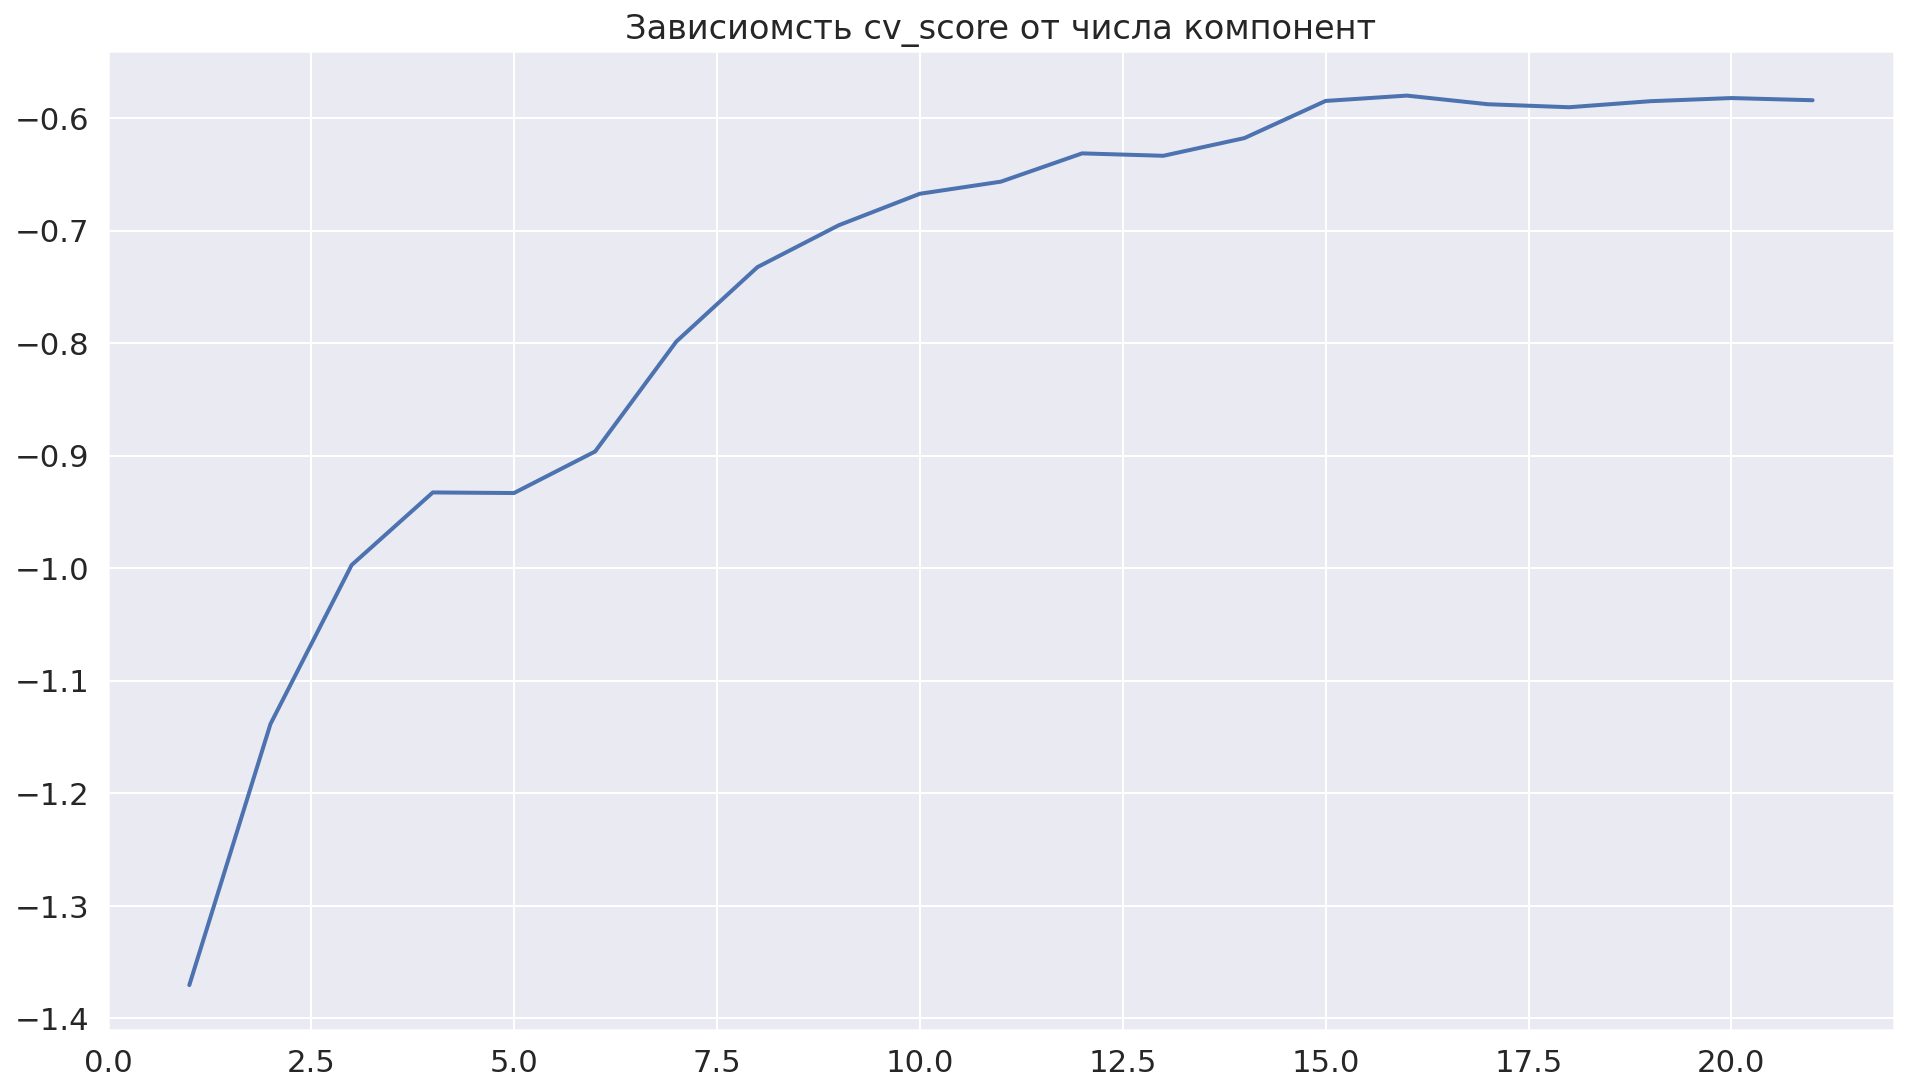

In [54]:
plt.figure(figsize = (16, 9))
plt.title("Зависиомсть cv_score от числа компонент")
plt.plot(np.arange(1, len(best_scores) + 1), best_scores, linewidth = 2)
plt.show()

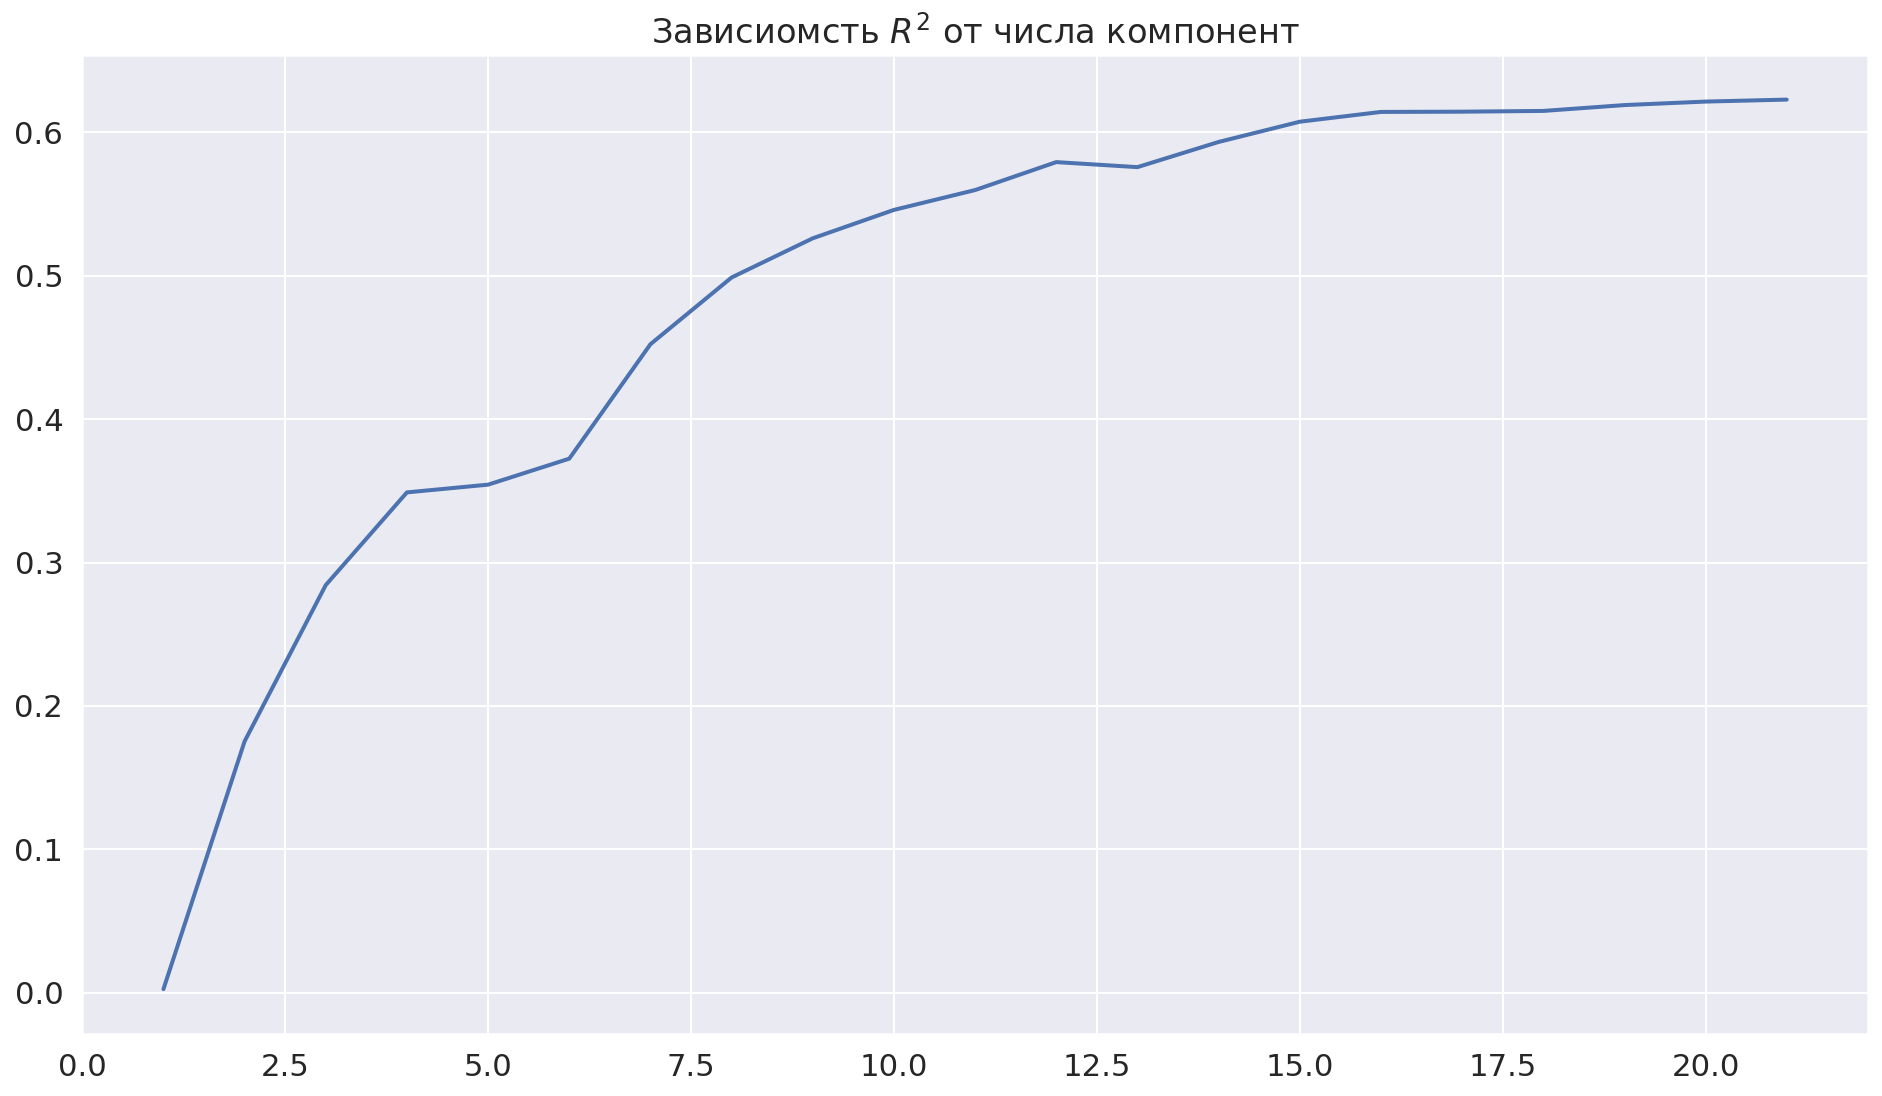

In [55]:
plt.figure(figsize = (16, 9))
plt.title(r"Зависиомсть $R^2$ от числа компонент")
plt.plot(np.arange(1, len(best_r2) + 1), best_r2, linewidth = 2)
plt.show()

In [56]:
np.argmax(np.array(best_scores)) + 1

16

Как видим, лучшая размерность -- 16 (она больше количества признаков).

In [57]:
dim = np.argmax(np.array(best_scores)) + 1
neigh = best_maps[dim - 1]
vals_iso, isomap, scaler = isomap_vals(X_train, dim, neigh)
model = make_basic_pipeline(LinearRegression(fit_intercept=True))
cv, _ = train_and_test_cv(model, None, "Linear", vals_iso, y_train, False)

cv score  --  -0.5801118267398788


Как видим, cv_score стал заметно лучше. Протестируемся на тестоаой выборке, и  если получим хороший результат, то обоснуем эффективность данного алгоритма для этой задачи.

In [58]:
X_test_mod = isomap.transform(scaler.transform(X_test))
sklearn.metrics.mean_squared_error(y_test, model.predict(X_test_mod))

0.4736700187394854

Как видим, результат действительно улучшился.

In [59]:
cols = [f"{i}"for i in range(1, dim + 1)]
train_iso = pd.DataFrame(data = vals_iso, columns = cols)
train_iso

1         2         3         4         5         6         7  \
0   -1.447872 -2.461323 -2.118120 -2.118696  0.257969  1.903799 -0.350593   
1    1.464084 -0.377520  2.176169  1.473991 -1.665516 -0.044659 -0.088665   
2   -2.698296 -0.770788  3.872080  0.832324 -1.152442  0.037575  0.219593   
3   -4.686509 -1.351342  2.193655 -1.587126 -0.228596 -1.834237  1.976483   
4    1.203312  0.135397  1.697692 -0.074782 -1.321355 -0.587764 -0.053471   
..        ...       ...       ...       ...       ...       ...       ...   
329 -2.409784 -3.601694 -1.952913 -1.138461  0.959432 -1.418951 -1.256947   
330  2.583192 -0.441484  1.723024 -1.080976 -0.077899 -1.064325  0.236380   
331 -2.024555  1.246457  1.218761 -1.831306 -0.599383 -0.013106  0.230875   
332 -3.865679  0.341062  1.929695 -2.025657  0.609385 -1.001908  0.922147   
333 -1.902205  0.149423  2.723852  3.539335 -0.112499 -0.362346 -0.651590   

            8         9        10        11        12        13        14  \
0    0.059509 -0.002561  0.767660 -1.880946  0.010395 -0.814853 -0.675722   
1    0.501647 -0.091718  0.077575  0.122255 -0.220136  0.437138 -0.149941   
2   -1.010214  1.141327  0.047405 -0.019505  0.577901  0.424532 -1.165661   
3    1.044643 -0.335095  0.059194  0.876801  0.024463  0.863475 -0.581692   
4    0.366508 -0.052073  0.413720 -0.199846  0.352752 -0.805499  0.218525   
..        ...       ...       ...       ...       ...       ...       ...   
329  0.234745  0.541055  0.316325 -0.311080 -1.150740  0.156715  0.313221   
330  0.400352 -0.399566  0.679840 -0.060979 -0.019477 -0.452190  0.028923   
331  0.316049  0.099489 -0.712397 -0.158936  0.188844  0.438336  0.449007   
332 -0.153414 -0.576274 -0.109671  0.736065 -0.228014  0.225364  0.100653   
333 -0.801626 -0.289000 -0.165574 -0.359292 -0.388845 -0.315715 -0.037431   

           15        16  
0    0.394405  0.551493  
1   -0.384327 -0.491891  
2   -0.413935  0.128983  
3    0.187127 -0.074318  
4   -0.059184  0.133454  
..        ...       ...  
329 -0.115240  0.064037  
330  0.290096  0.409117  
331 -0.062341 -0.116277  
332  1.019277 -0.034305  
333  0.676525 -0.418635  

[334 rows x 16 columns]

In [60]:
err = find_student_remainders(model, train_iso, y_train) 

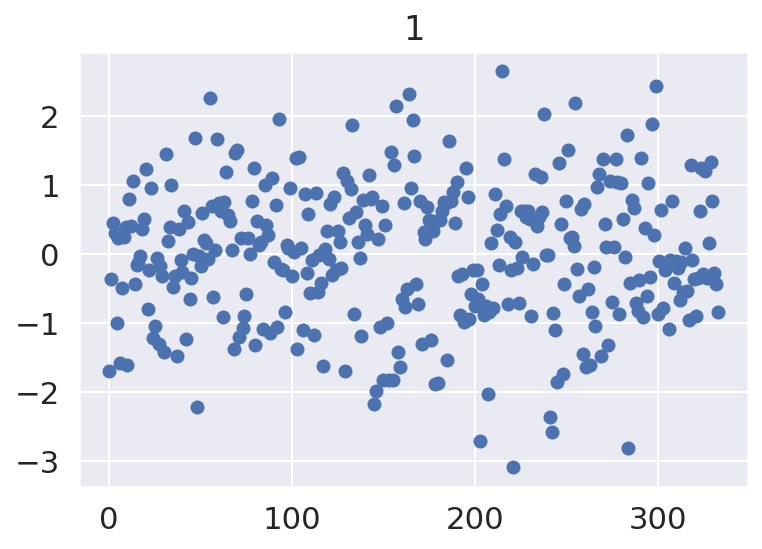

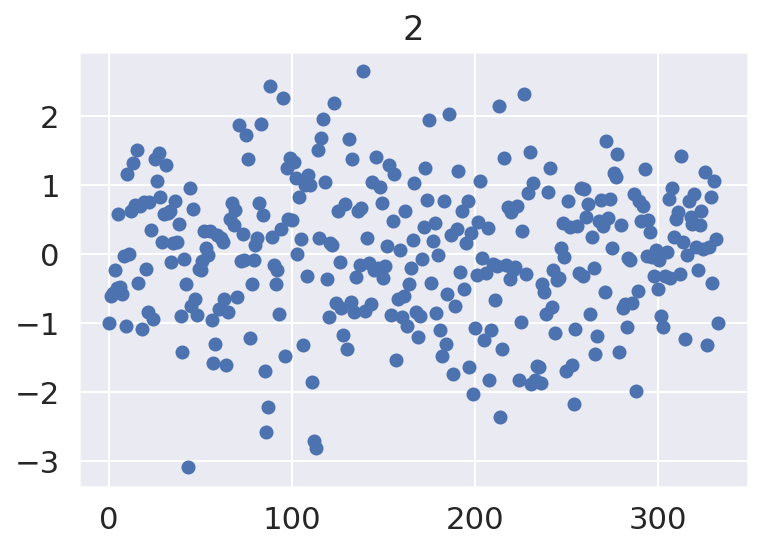

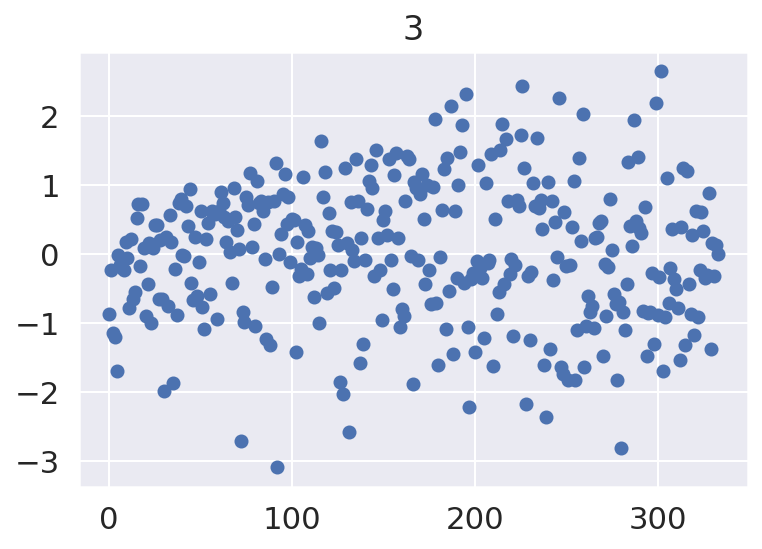

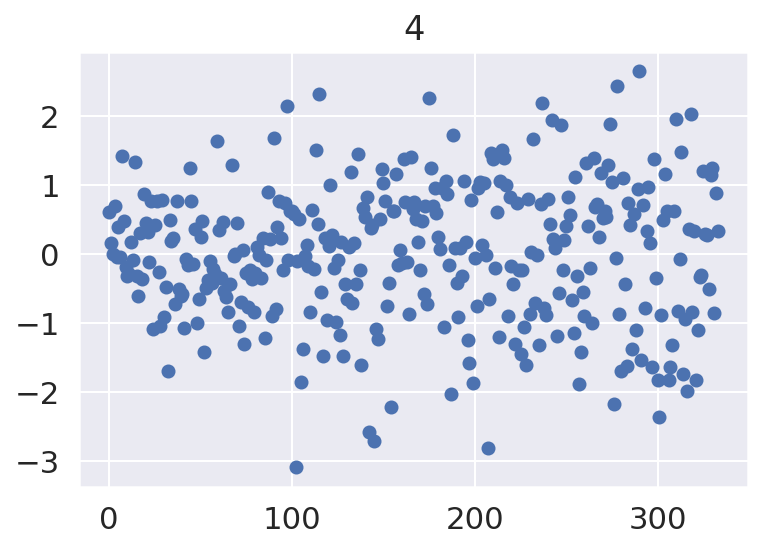

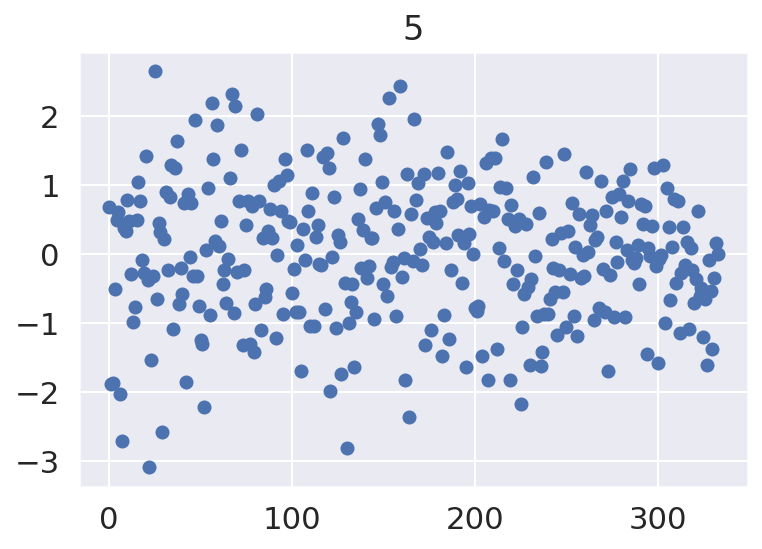

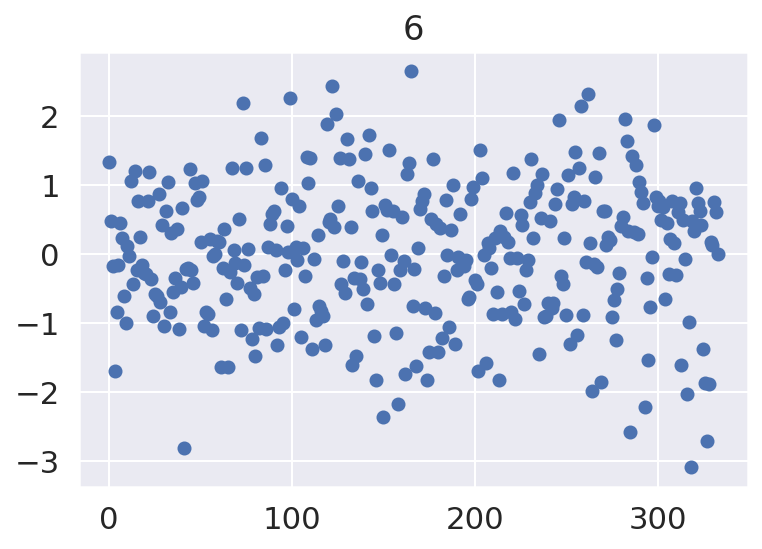

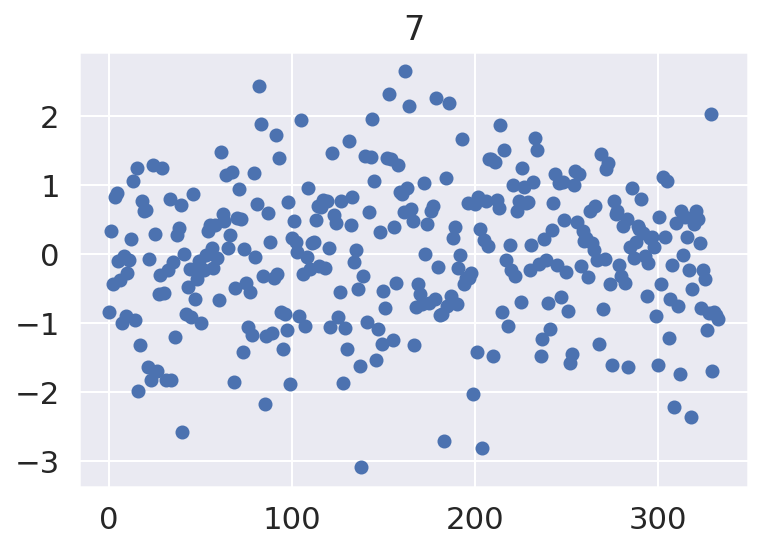

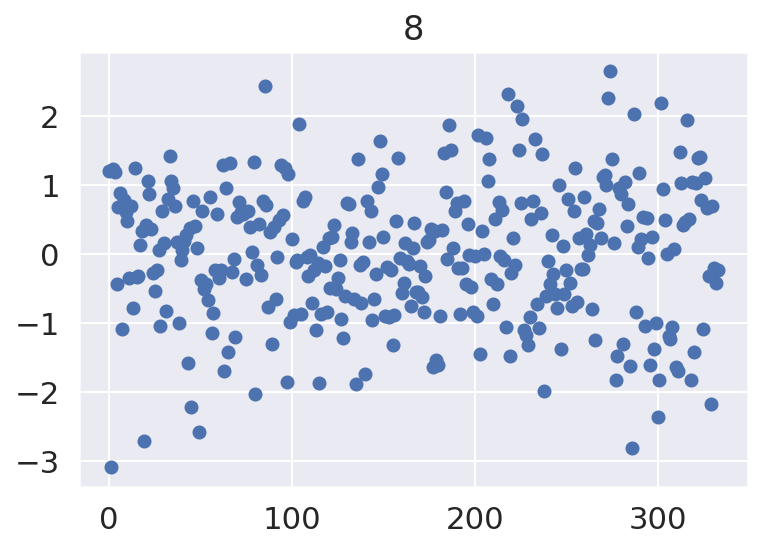

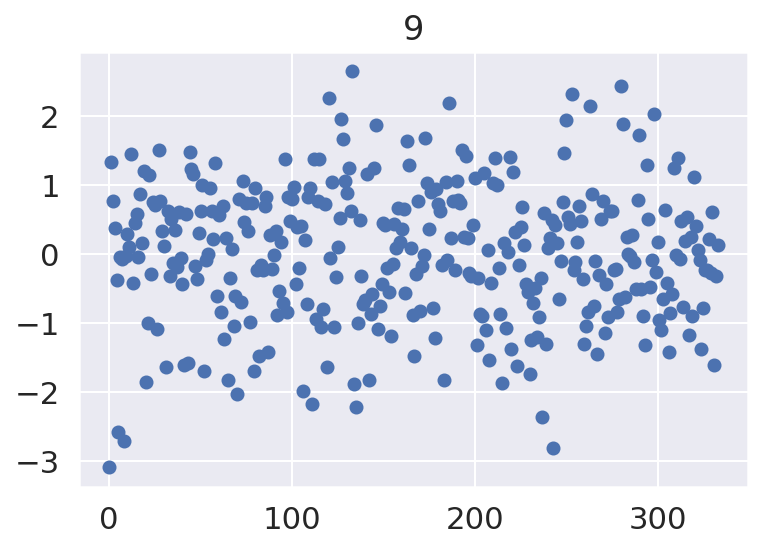

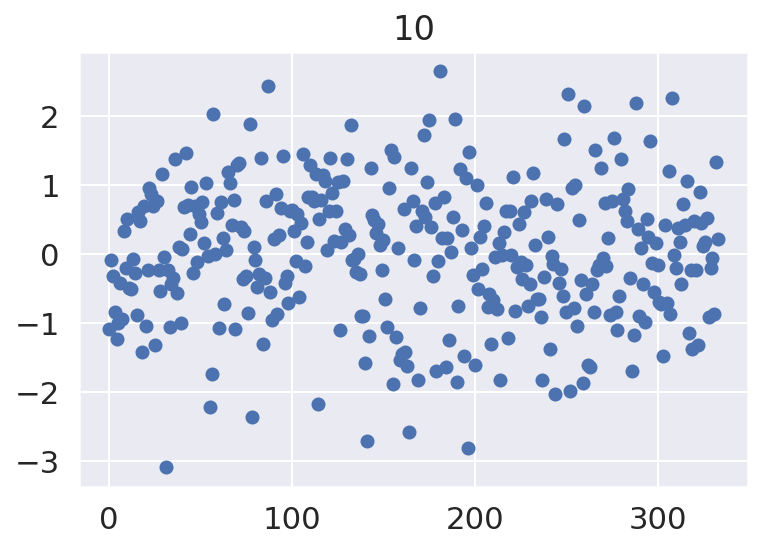

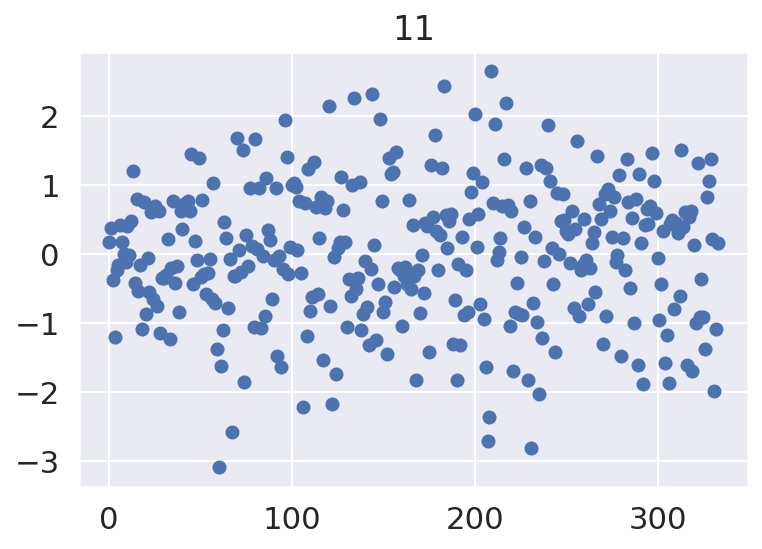

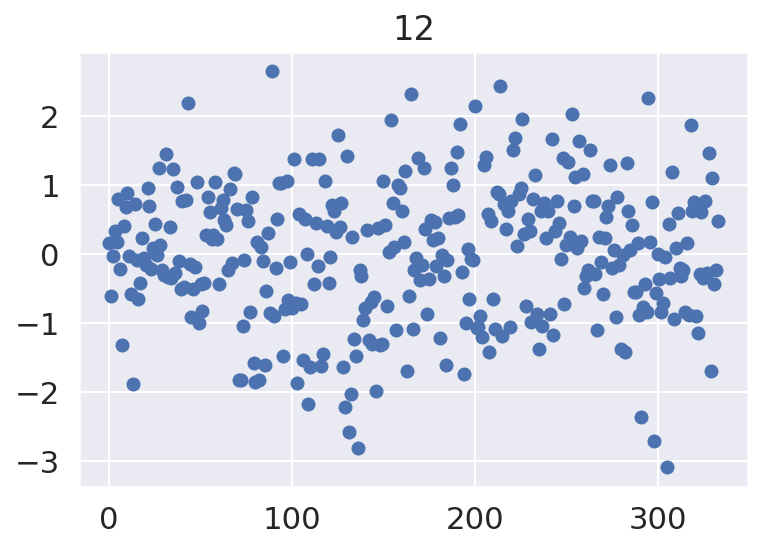

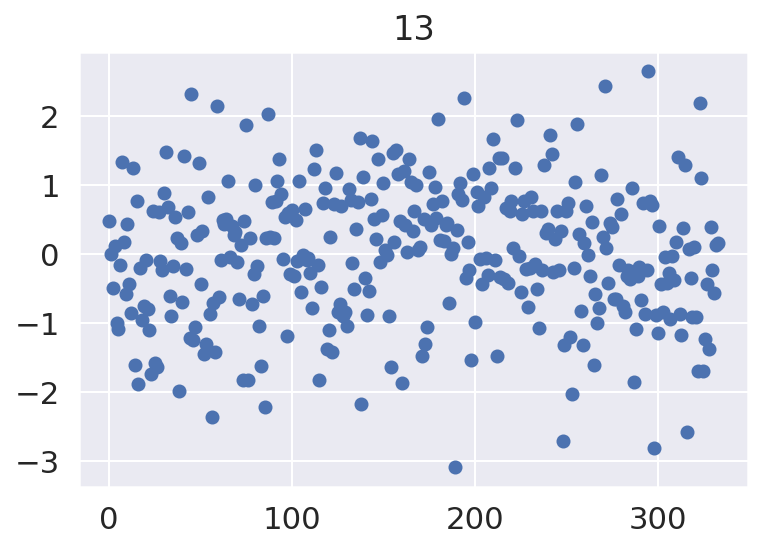

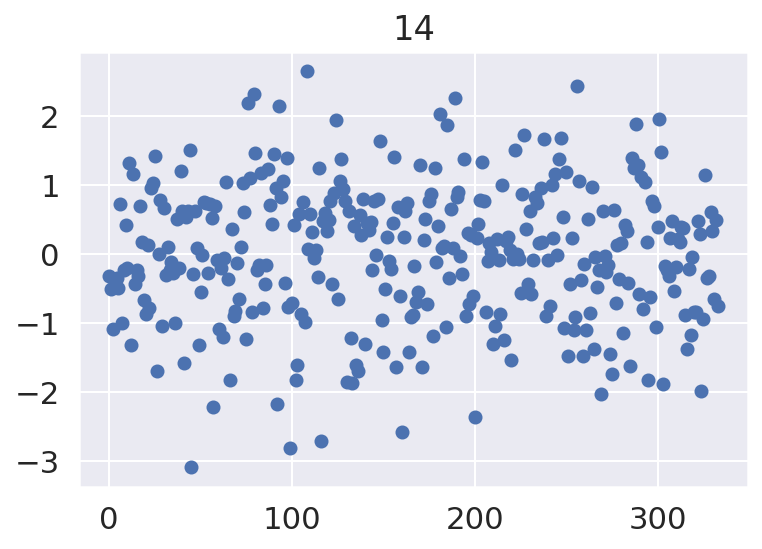

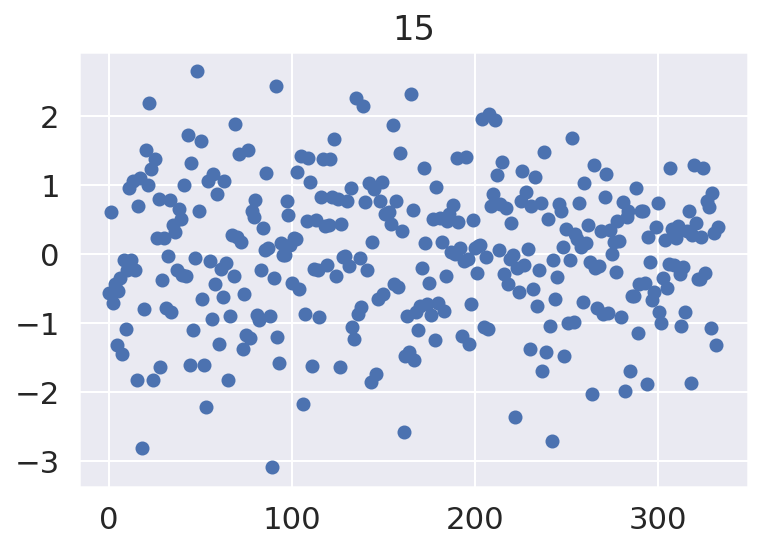

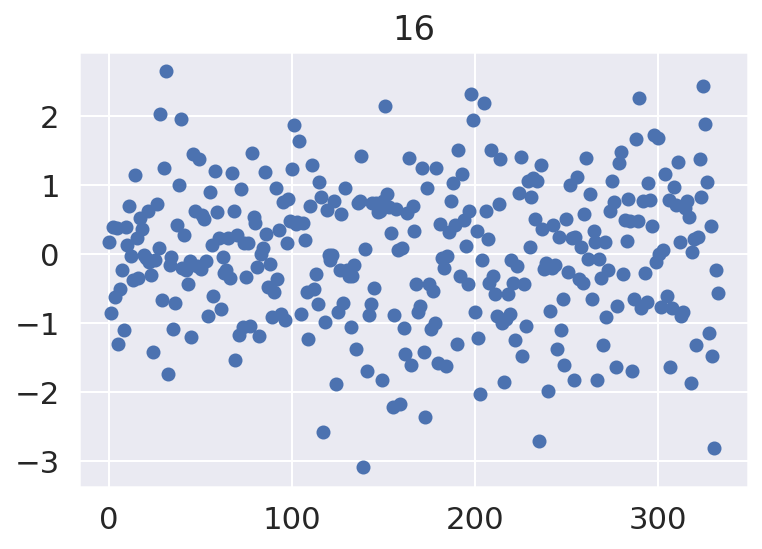

In [61]:
for i in range(train_iso.shape[1]):
    plt.figure()
    plt.plot(err[train_iso.values[:, i].argsort()], 'o')
    plt.title(train_iso.columns[i])

Кажется, какие-то пораболические зависимости прослеживаются в признаках 3 7 и 13.

In [62]:
cols_sqr = ["3", "7","13"]
train_iso_mod = train_iso.copy()
for col in cols_sqr:
    train_iso_mod[col + "sqr"] = train_iso[col] ** 2
model_opt = make_basic_pipeline(LinearRegression(fit_intercept=True))
train_and_test_cv(model_opt, None, "Linear", train_iso_mod, y_train, False)   

cv score  --  -0.646340424441612


(-0.646340424441612,
 Pipeline(steps=[('Scaler', StandardScaler()), ('Model', LinearRegression())]))

Как видим, результат стал хуже. Таким образом, через Isomap мы увеличили число признаков и улучшили результат. Попробуем визуализировать данные, взяв 2-3 главных компоненты и применив Isomap и LLE. Возможно, образуются кластеры, и можно будет попробовать решить задачу "локально" по кластеру.

In [63]:
from matplotlib import cm

def scatter_2d(x, y, figsize, title, cmap):
    plt.figure(figsize=figsize)
    plt.title(title)
    sc = plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap)  
    plt.colorbar(sc)
    plt.show()

In [64]:
from matplotlib import cm

def scatter_3d(x, y, figsize, title, cmap):
    plt.figure(figsize=figsize)
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(projection='3d')
    sc = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c = y, cmap = cmap)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-4, 4)
    ax.view_init(-140, -30)
    fig.colorbar(sc)
    plt.show()

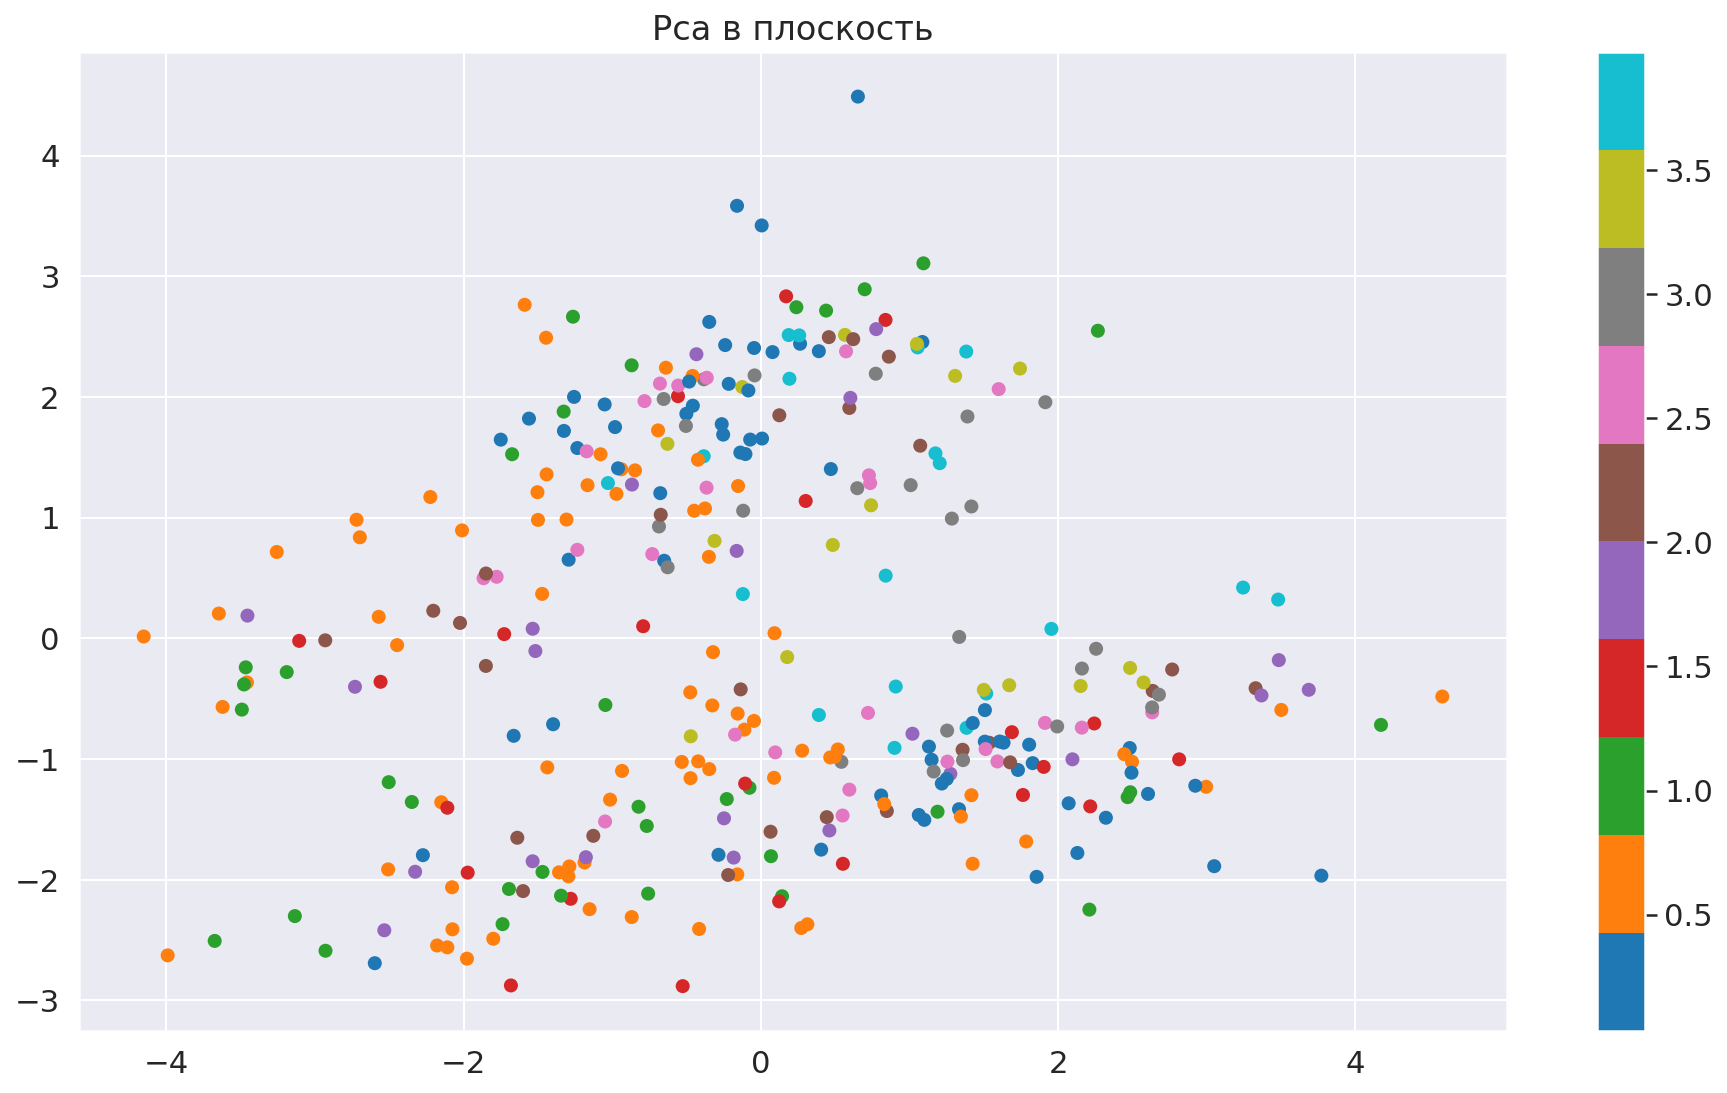

In [65]:
pca = make_basic_pipeline(PCA(n_components=2))
X_new = pca.fit_transform(X_train)
scatter_2d(X_new, y_train, (16, 9), "Pca в плоскость", cm.get_cmap('tab10', 10))

<Figure size 1152x648 with 0 Axes>

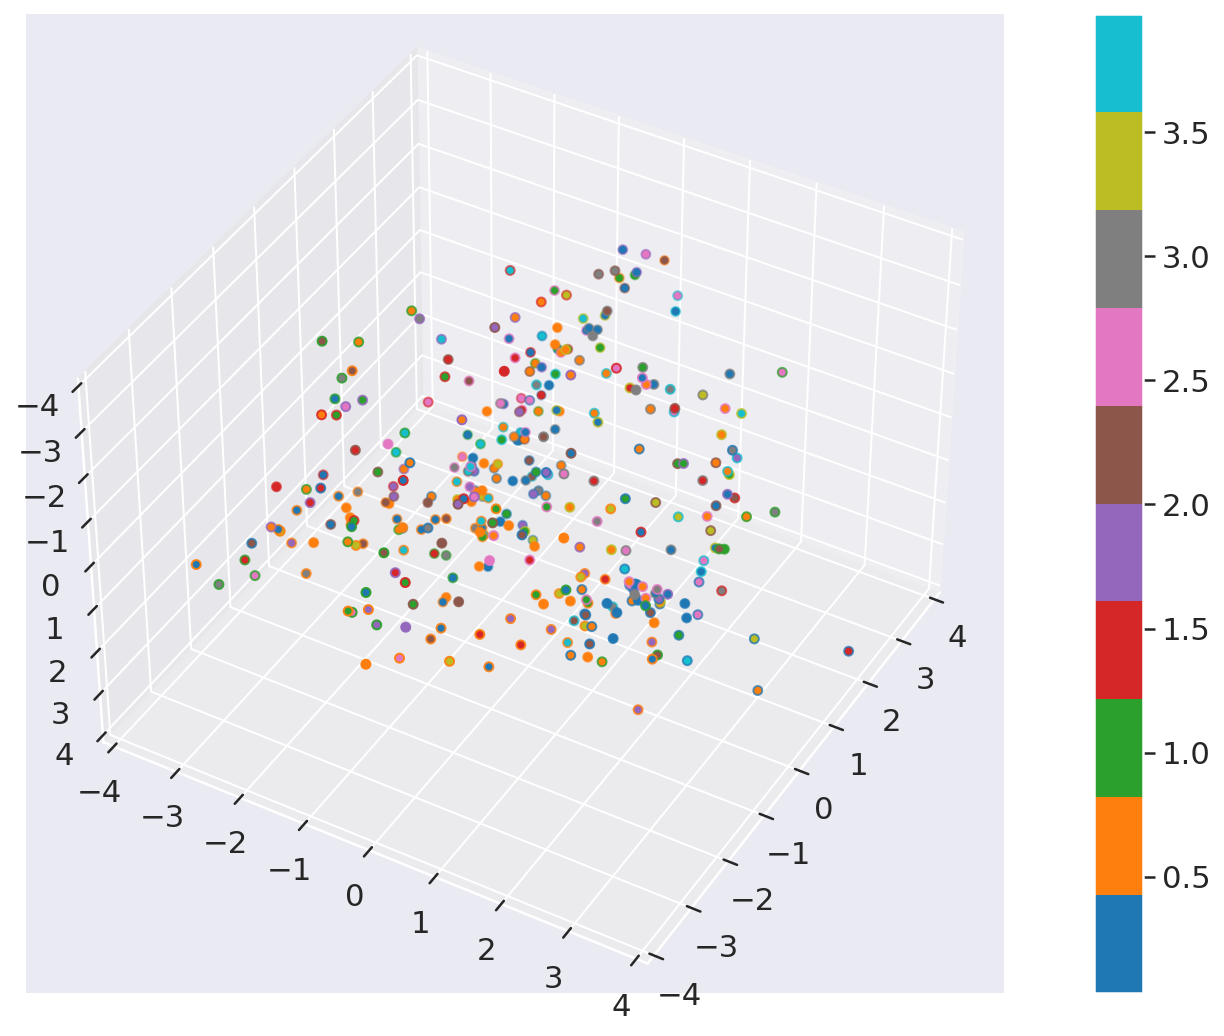

In [66]:
pca = make_basic_pipeline(PCA(n_components=3))
X_new = pca.fit_transform(X_train)
scatter_3d(X_new, y_train, (16, 9), "Pca в пространство",cm.get_cmap('tab10', 10))

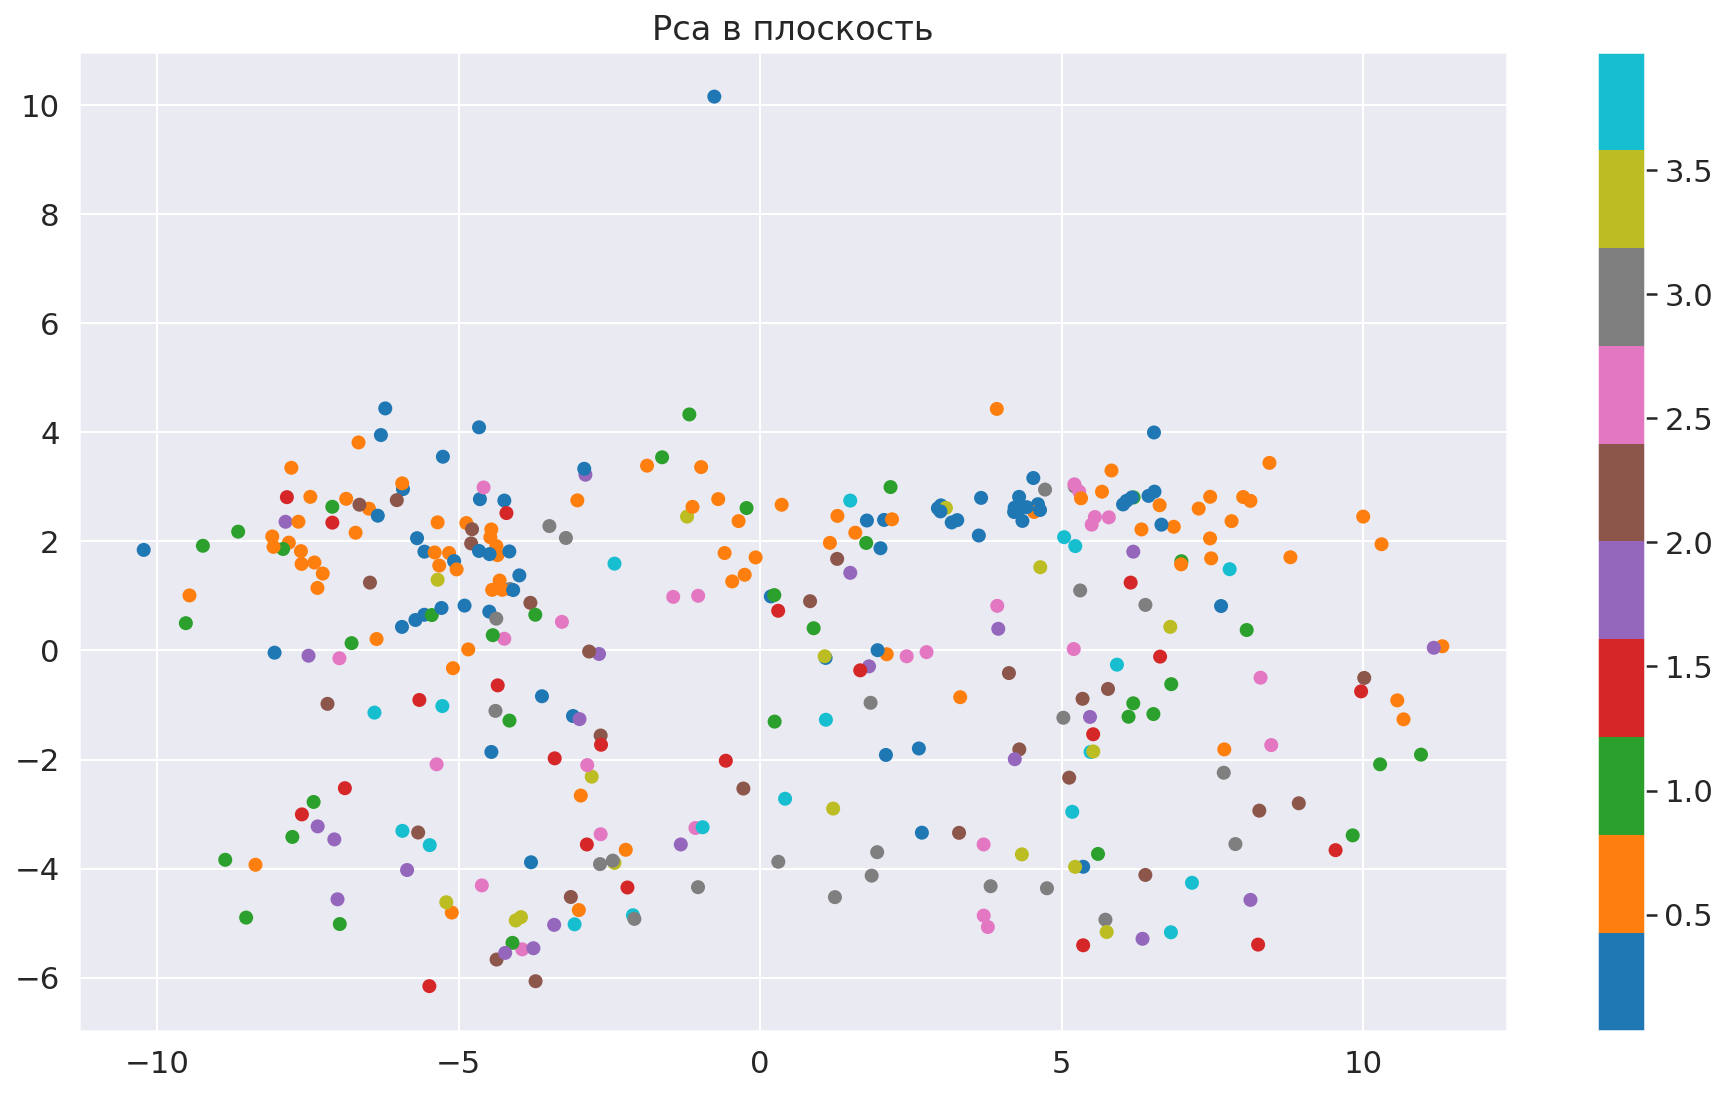

In [67]:
isomap = make_basic_pipeline(Isomap(n_components=2, n_neighbors=6))
X_new = isomap.fit_transform(X_train)
scatter_2d(X_new, y_train, (16, 9), "Pca в плоскость", cm.get_cmap('tab10', 10))

<Figure size 1152x648 with 0 Axes>

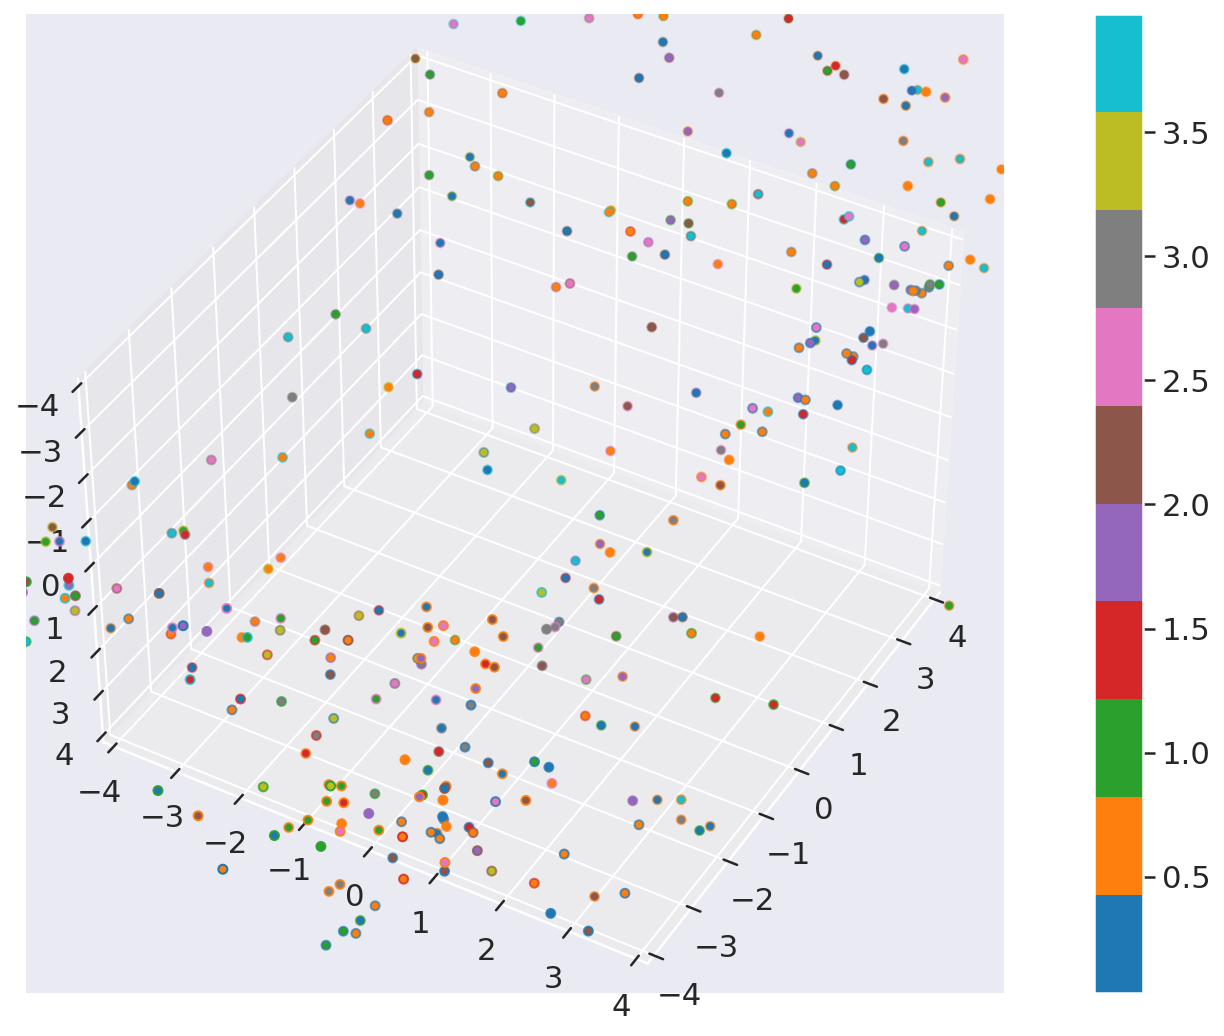

In [68]:
isomap = make_basic_pipeline(Isomap(n_components=3, n_neighbors=6))
X_new = isomap.fit_transform(X_train)
scatter_3d(X_new, y_train, (16, 9), "Pca в плоскость", cm.get_cmap('tab10', 10))

Никаких хороших кластеров не появилось. 

### Задача 4

Скачаем данные, посмотрим на размерность.

In [69]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [70]:
faces = datasets.fetch_olivetti_faces()

In [71]:
faces['DESCR']

'.. _olivetti_faces_dataset:\n\nThe Olivetti faces dataset\n--------------------------\n\n`This dataset contains a set of face images`_ taken between April 1992 and \nApril 1994 at AT&T Laboratories Cambridge. The\n:func:`sklearn.datasets.fetch_olivetti_faces` function is the data\nfetching / caching function that downloads the data\narchive from AT&T.\n\n.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html\n\nAs described on the original website:\n\n    There are ten different images of each of 40 distinct subjects. For some\n    subjects, the images were taken at different times, varying the lighting,\n    facial expressions (open / closed eyes, smiling / not smiling) and facial\n    details (glasses / no glasses). All the images were taken against a dark\n    homogeneous background with the subjects in an upright, frontal position \n    (with tolerance for some side movement).\n\n**Data Set Characteristics:**\n\n    ======

Судя по описанию, у нас 40 значений таргета по 10 значений каждого.

In [72]:
X, y = faces.data, faces.target

In [73]:
X.shape

(400, 4096)

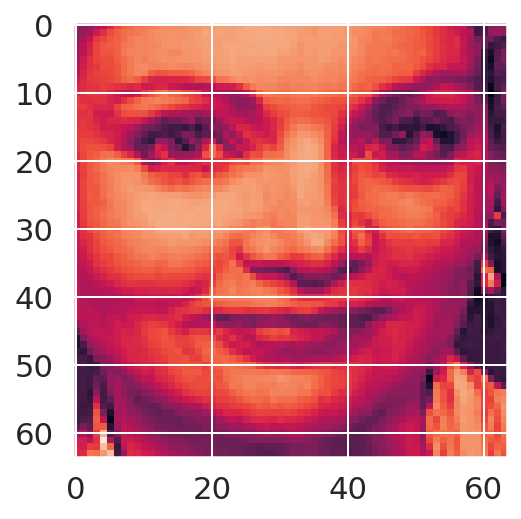

In [74]:
plt.imshow(X[345].reshape(64, 64))

Используем PCA, чтобы понять, какое минимальльное число компонент можно иметь, чтобы индивидуальные различия не терялись. Для этого будем смотреть на 8 ближайших соседей каждой картинки и посмотрим, для какого числа картинок из 8 ближайших соседей 7 того же значения тартета. 

In [75]:
n_comps = np.arange(1, 100)
neigh = 6

good_marks = []

for c in n_comps:
    general_ok = 0
    pca = make_basic_pipeline(PCA(n_components=c))
    X_new = pca.fit_transform(X)
    knn = KNeighborsClassifier(n_neighbors=neigh)
    knn.fit(X_new, y)
    vals = knn.predict(X_new)
    good_marks.append(len(vals[vals == y]))


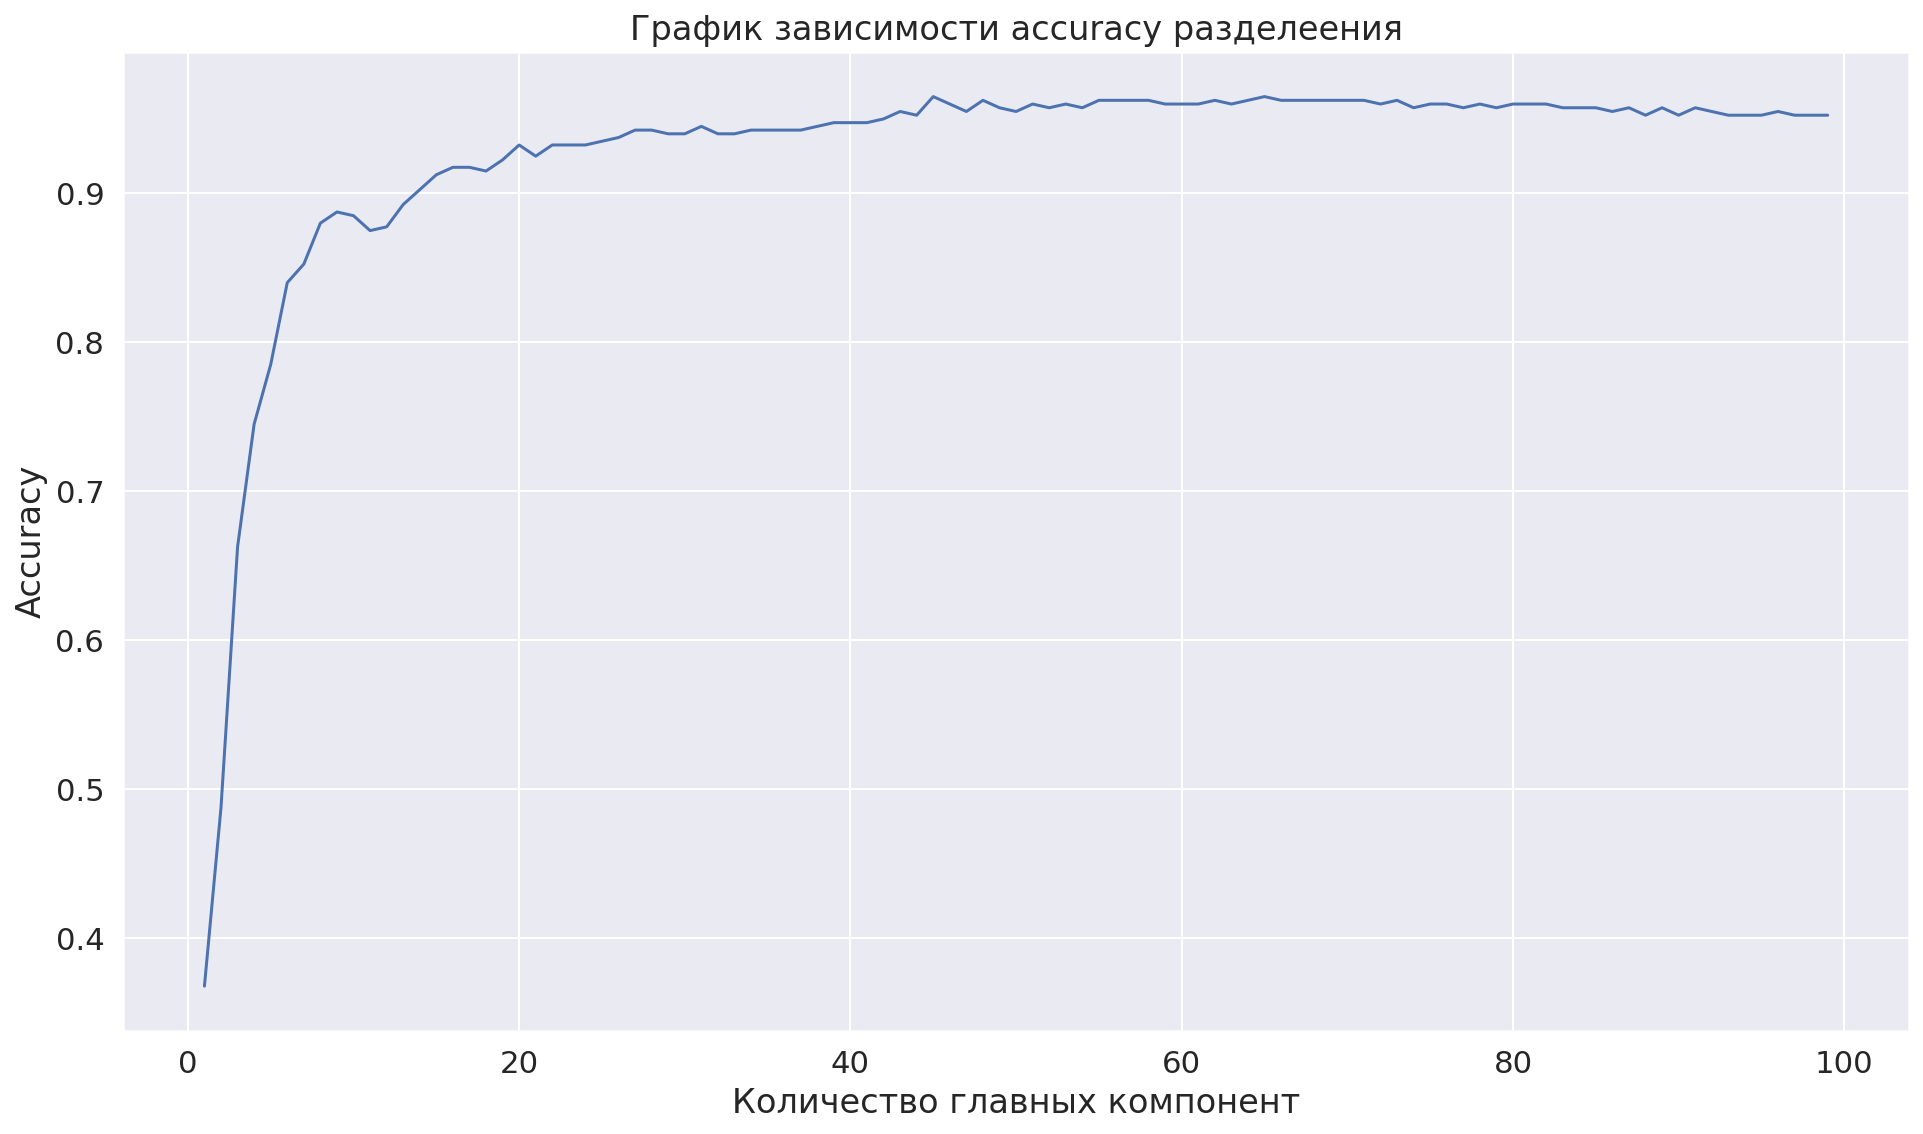

In [76]:
plt.figure(figsize=(16, 9))
plt.title("График зависимости accuracy разделеения")
plt.plot(n_comps, np.array(good_marks) / X.shape[0])
plt.xlabel("Количество главных компонент")
plt.ylabel("Accuracy")
plt.show()

Сделаем график поближе.

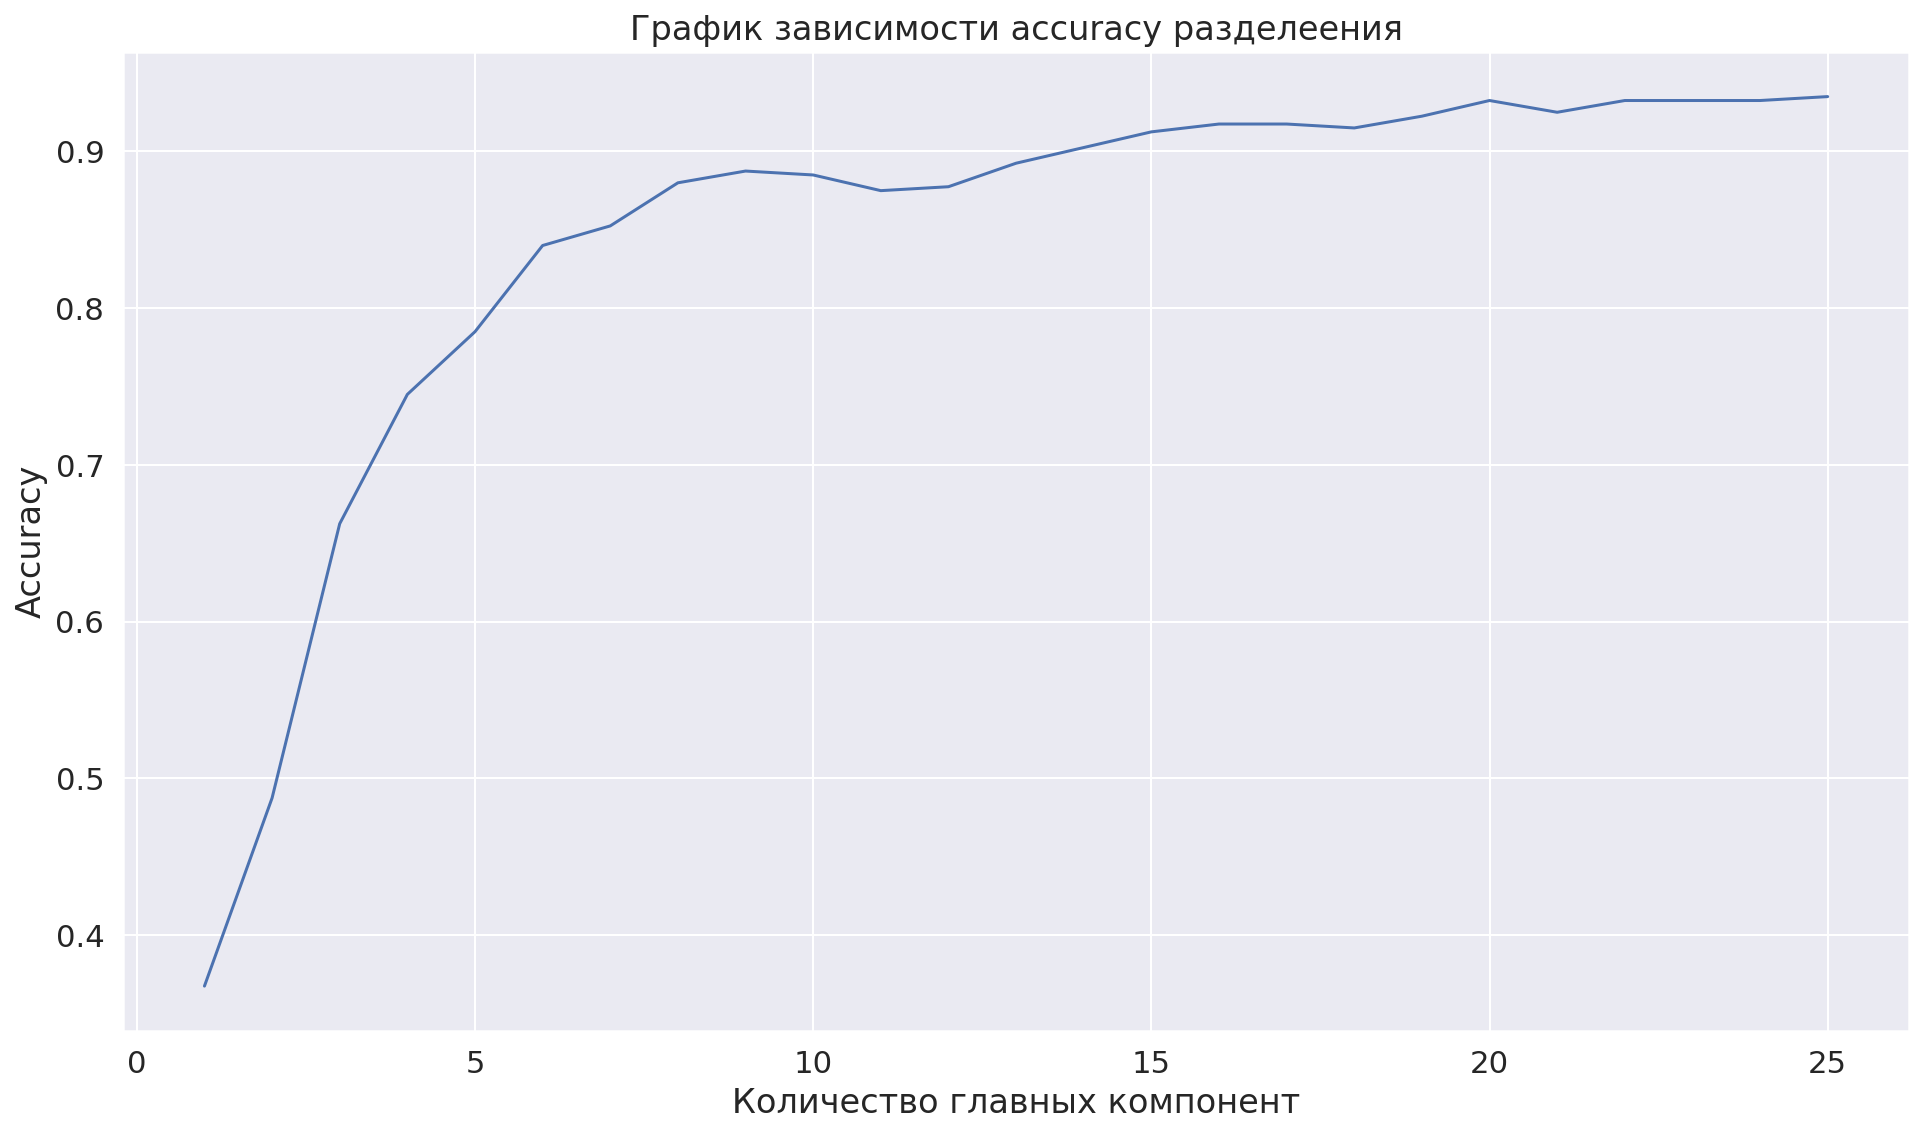

In [77]:
plt.figure(figsize=(16, 9))
plt.title("График зависимости accuracy разделеения")
plt.plot(n_comps[:25], np.array(good_marks)[:25] / X.shape[0])
plt.xlabel("Количество главных компонент")
plt.ylabel("Accuracy")
plt.show()

Как видим, хороших прирост идет до 18-22 компонент, затем идет плато. Теперь спроецируем все на $R^2$ и посмотрим, как что разделяется на кластера. Согласно графику, ожидается что PCA покажет плохой результат. При этом, TSNE является одним из лучших алгоритмов визуализации, поэтому есть надежда, что получится хороший результат.

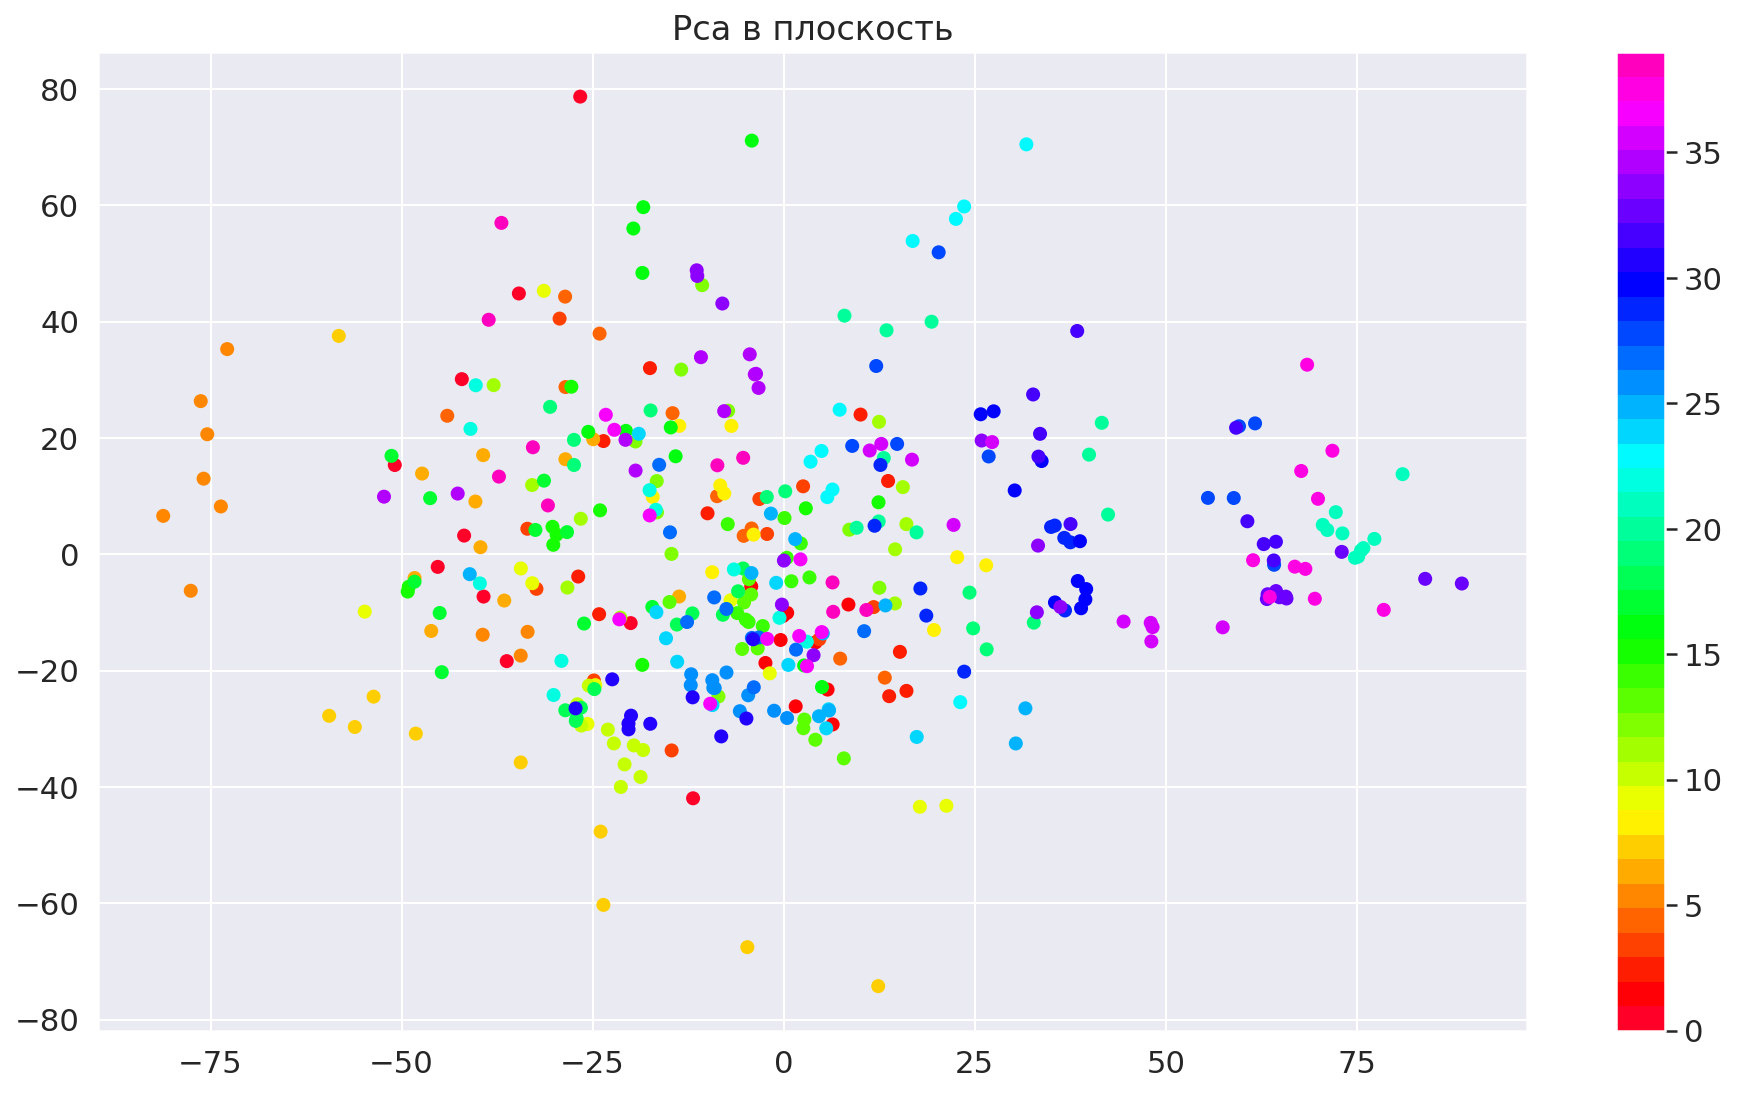

In [78]:
pca = make_basic_pipeline(PCA(n_components=2))
X_new = pca.fit_transform(X)
scatter_2d(X_new, y, (16, 9), "Pca в плоскость", cm.get_cmap('gist_rainbow', 40))

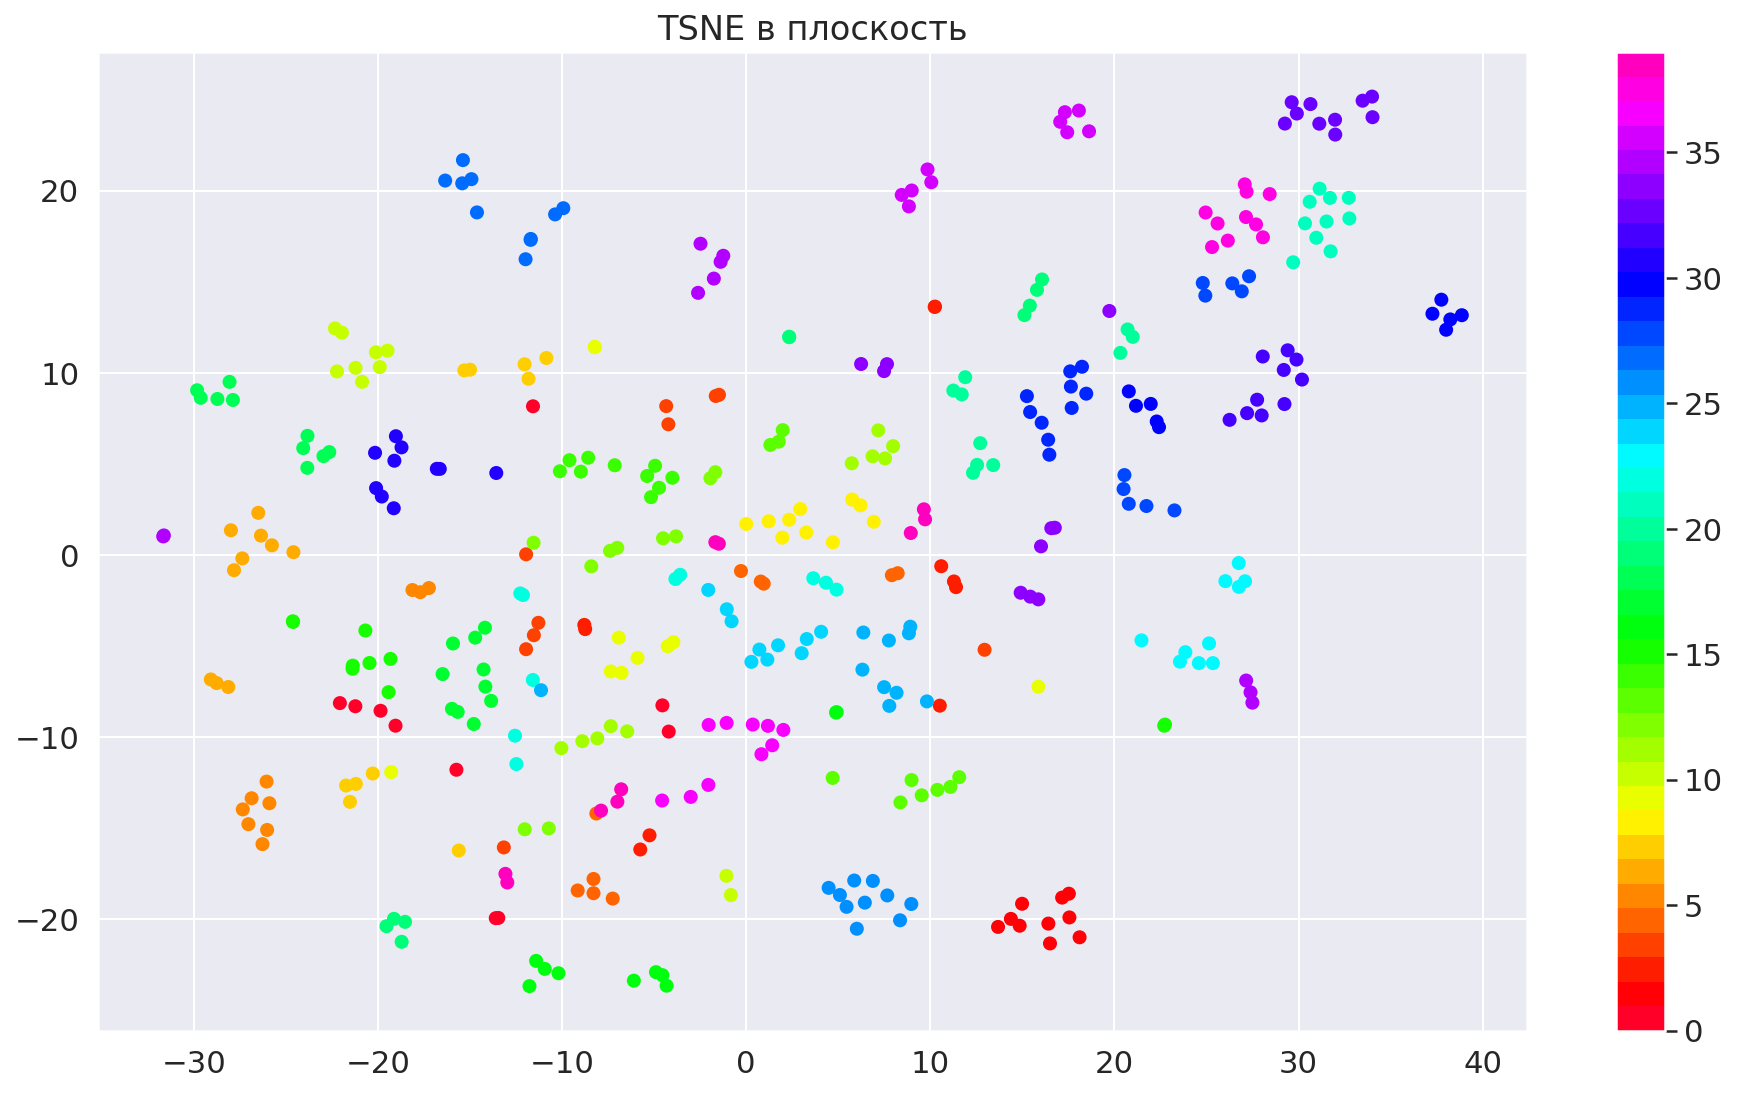

In [79]:
sne = make_basic_pipeline(TSNE(n_components=2))
X_new = sne.fit_transform(X)
scatter_2d(X_new, y, (16, 9), "TSNE в плоскость", cm.get_cmap('gist_rainbow', 40))

Как видим, ожидания подтвердились. 

Попробуем еще и Isomap.

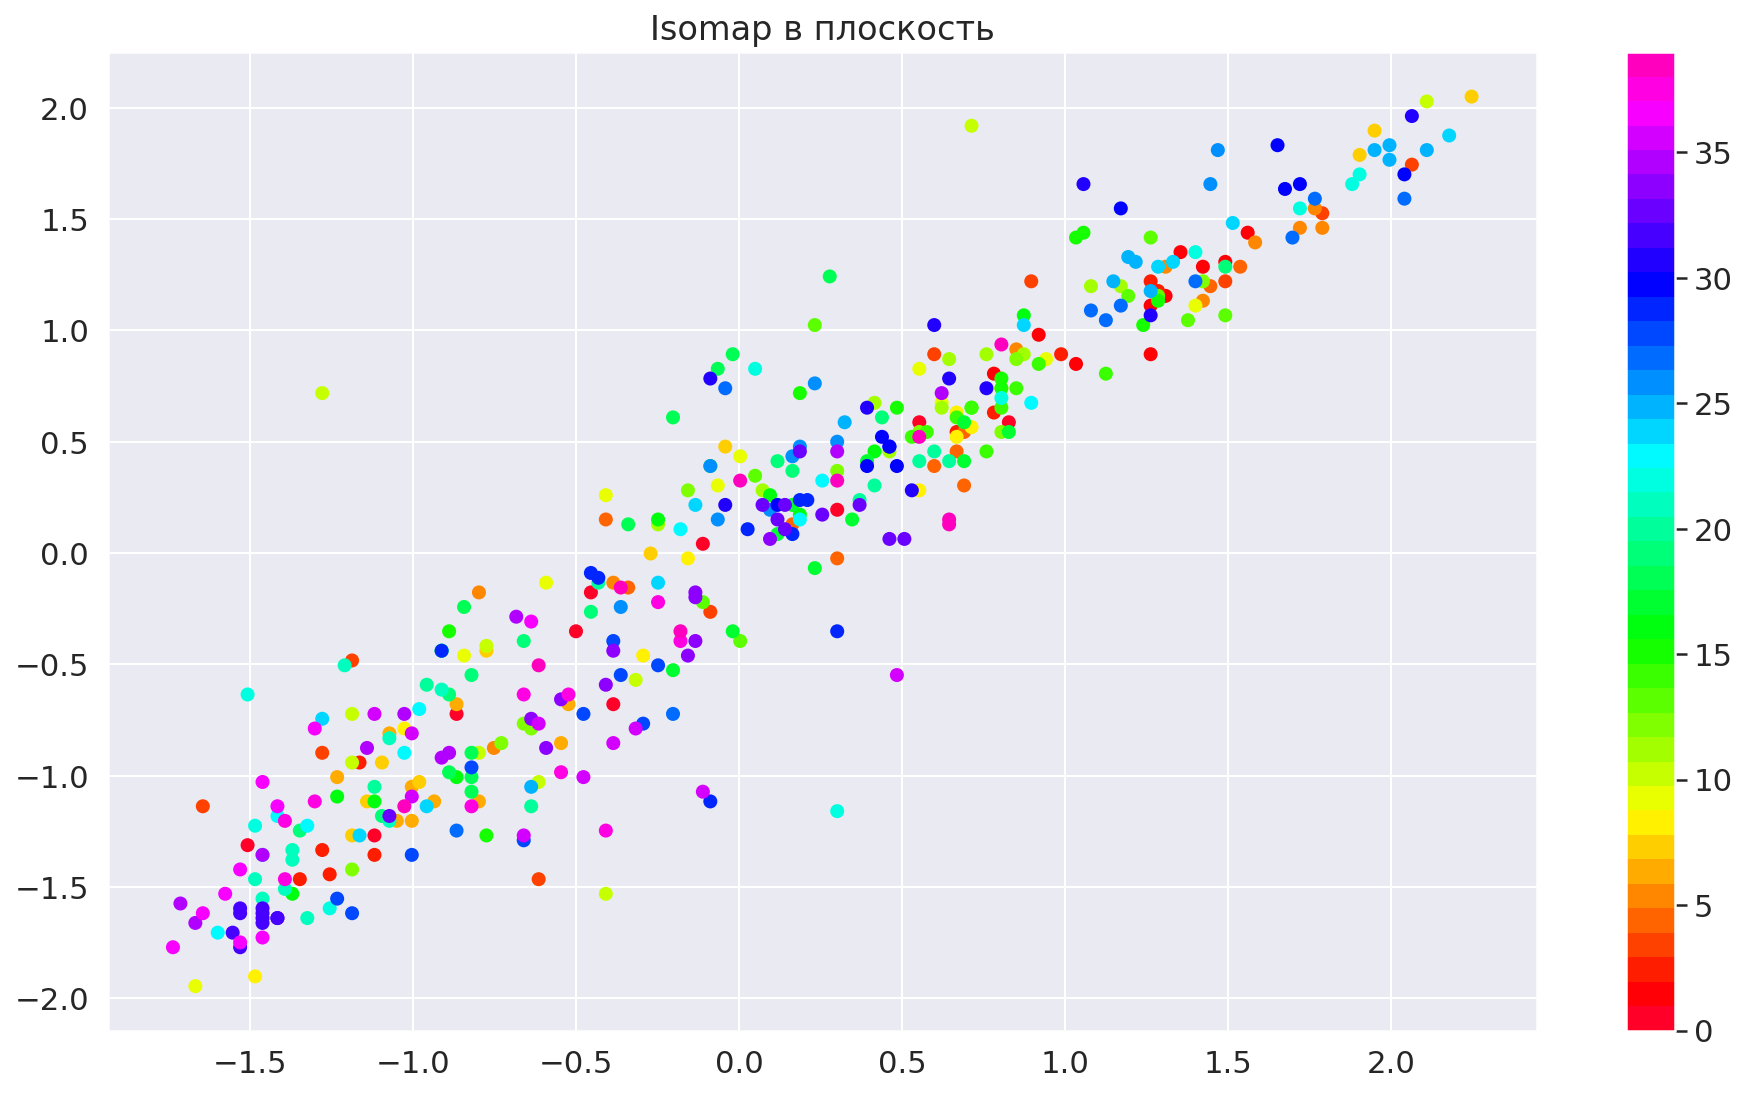

In [80]:
isomap = Isomap(n_neighbors=7, n_components=2)
scaler = StandardScaler()
x_iso = scaler.fit_transform(X)
scatter_2d(x_iso, y, (16, 9), "Isomap в плоскость", cm.get_cmap('gist_rainbow', 40))

Как видим,  Isomap не справился.

**Вывод:** Как видим TSNE показал очень хорошие результаты, по сравнению с другими алгоритмами визуализации, тем самым подтвердив свою репутацию.

### Задача 5

Считаем данные.

In [81]:
data = pd.read_csv("hw11t5.csv")

In [82]:
data

Unnamed: 0    0           1         2         3         4         5  \
0             0  3.0  154.821499  5.782582 -3.918036 -1.400880  3.945351   
1             1  3.0   70.860971  3.590312 -0.640982  8.150033  0.770168   
2             2  3.0   57.396471  2.232988  0.017323  4.791453  0.020102   
3             3  2.0  187.208620  4.991852 -0.174600  8.288949  1.139516   
4             4  1.0   60.916377  4.928733 -2.434158 -0.227966  2.434237   
..          ...  ...         ...       ...       ...       ...       ...   
995         995  3.0   87.064964  4.075047 -0.806516  8.906273  1.220040   
996         996  2.0  163.344691  4.724222 -1.318180  7.152105  1.321478   
997         997  2.0   55.438808  2.504701  1.868474  3.212225  1.981307   
998         998  1.0   68.318955  4.327282 -2.405675 -1.249300  2.507161   
999         999  2.0   12.930955  5.612307 -3.011754 -0.359828  3.705105   

            6          7         8         9         10        11        12  \
0    2.815372   0.403212 -0.993077  0.191118 -12.357041  0.197025 -5.040347   
1   -7.692933   1.272137 -0.832262  0.211284   1.679167 -0.992891  0.838220   
2    0.555192  -5.698161  0.861783 -0.053746   1.403360  0.094688  9.101261   
3    3.626264 -10.823121 -0.153223  0.085406  -1.167043  0.617928 -0.247962   
4    6.837928  -4.609124 -0.999967  0.180764  -6.294473 -0.812003  1.231482   
..        ...        ...       ...       ...        ...       ...       ...   
995 -0.044898   2.605049 -0.661057 -0.196151   0.978255 -0.289570  2.282890   
996  7.091126 -10.591915 -0.997504  0.100203  -0.058525  0.997945 -0.999558   
997 -4.531929  -6.476315  0.943051 -0.231364   1.782627 -0.756135 -1.247199   
998  0.847237  -6.711000 -0.959522 -0.088766  -4.660545  0.993691 -0.965614   
999  0.171746   2.256098 -0.812866  0.148226  -2.776959  0.827009 -0.982899   

               13        14         15  
0    1.056376e+25  0.946656 -80.043312  
1    9.920627e+03  0.997701   8.345960  
2    1.381784e+00 -0.288042  53.346486  
3    3.877774e+05  0.981043  57.129222  
4    1.220270e+04  0.898770 -23.988305  
..            ...       ...        ...  
995  1.832341e+00 -0.993027  -5.387164  
996  2.585192e+06  1.000000  54.009809  
997  5.886278e+02 -0.999997  52.940775  
998  7.189880e+01 -0.381627  -2.881371  
999  1.004405e+00  0.021002 -38.212223  

[1000 rows x 17 columns]

In [83]:
data.isna().any()

Unnamed: 0    False
0             False
1             False
2             False
3             False
4             False
5             False
6             False
7             False
8             False
9             False
10            False
11            False
12            False
13            False
14            False
15            False
dtype: bool

In [84]:
X, y = data.drop(['Unnamed: 0', '0'], axis = 1), data['0']

In [85]:
X_f, X_s, y_f, y_s = train_test_split(X, y, test_size=0.2, random_state=1)

Построим график объясненной дисперсии для PCa, а также попробуем повизуализировать на $R^2$ и $R^3$.

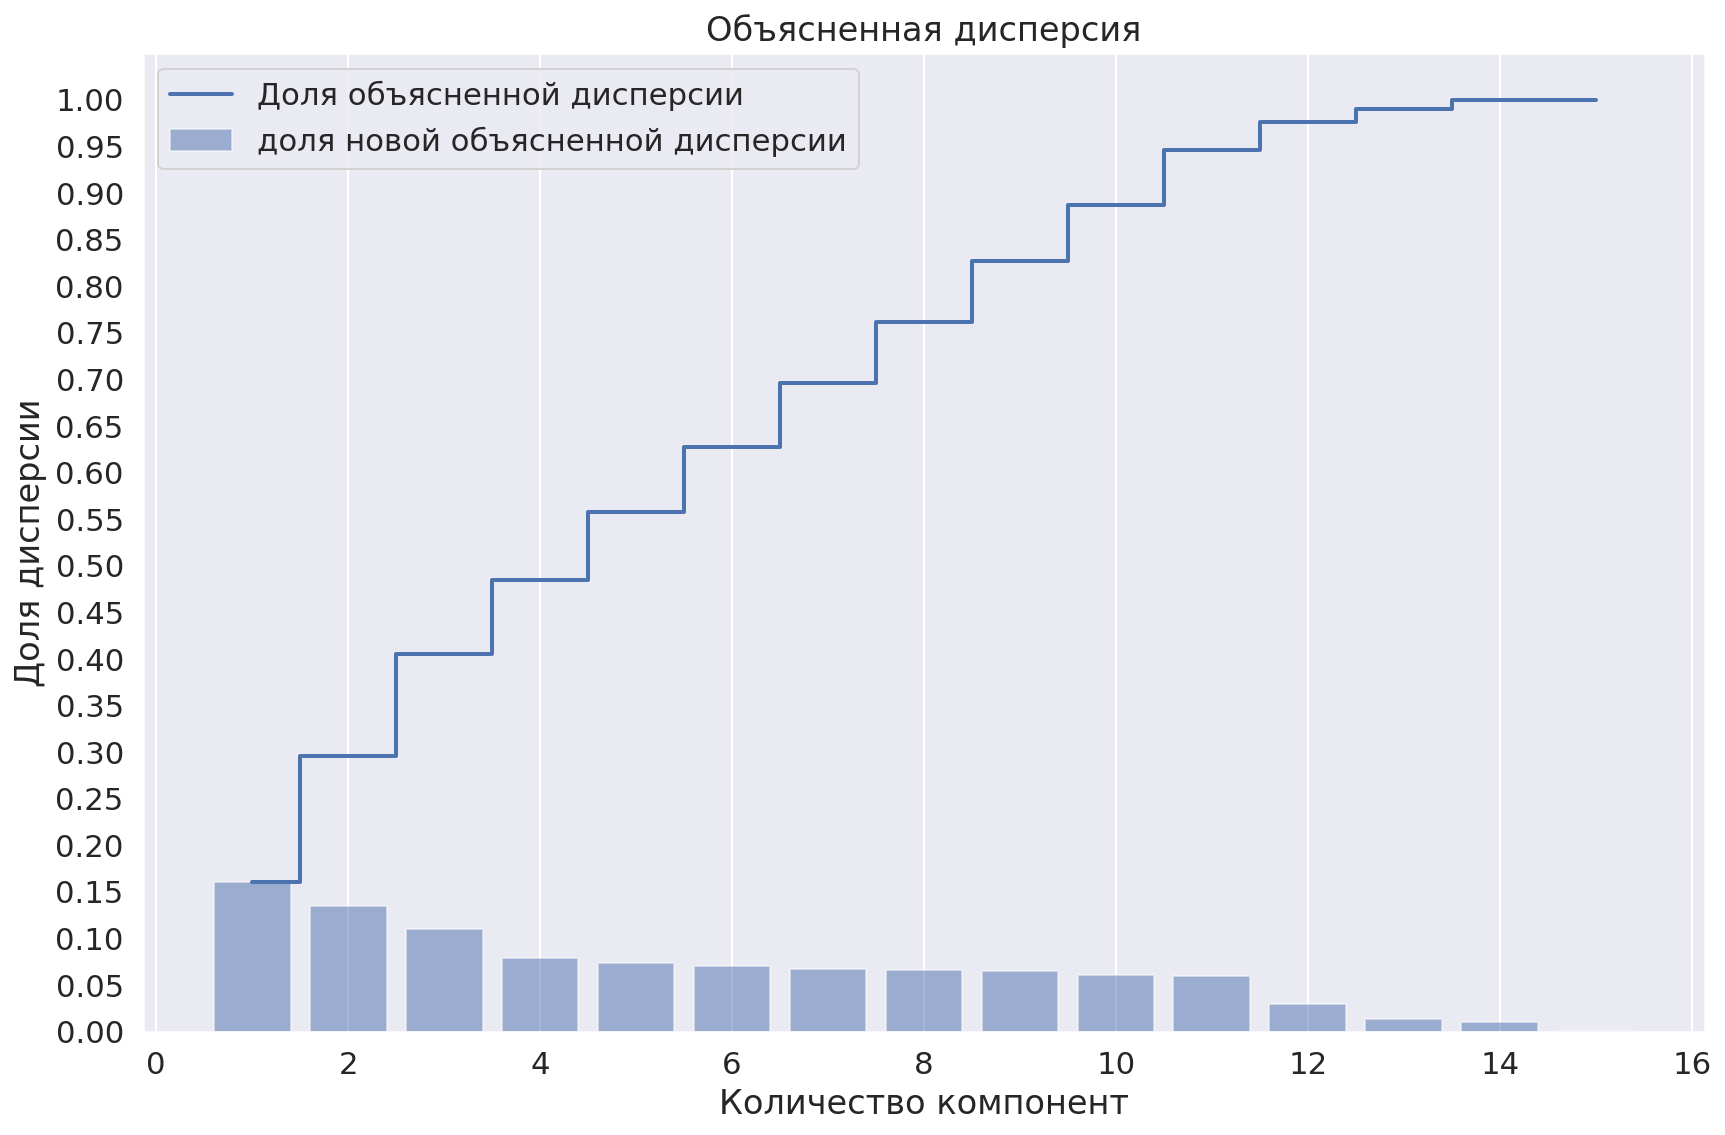

In [86]:
plot_explained_pca_var(X_f)

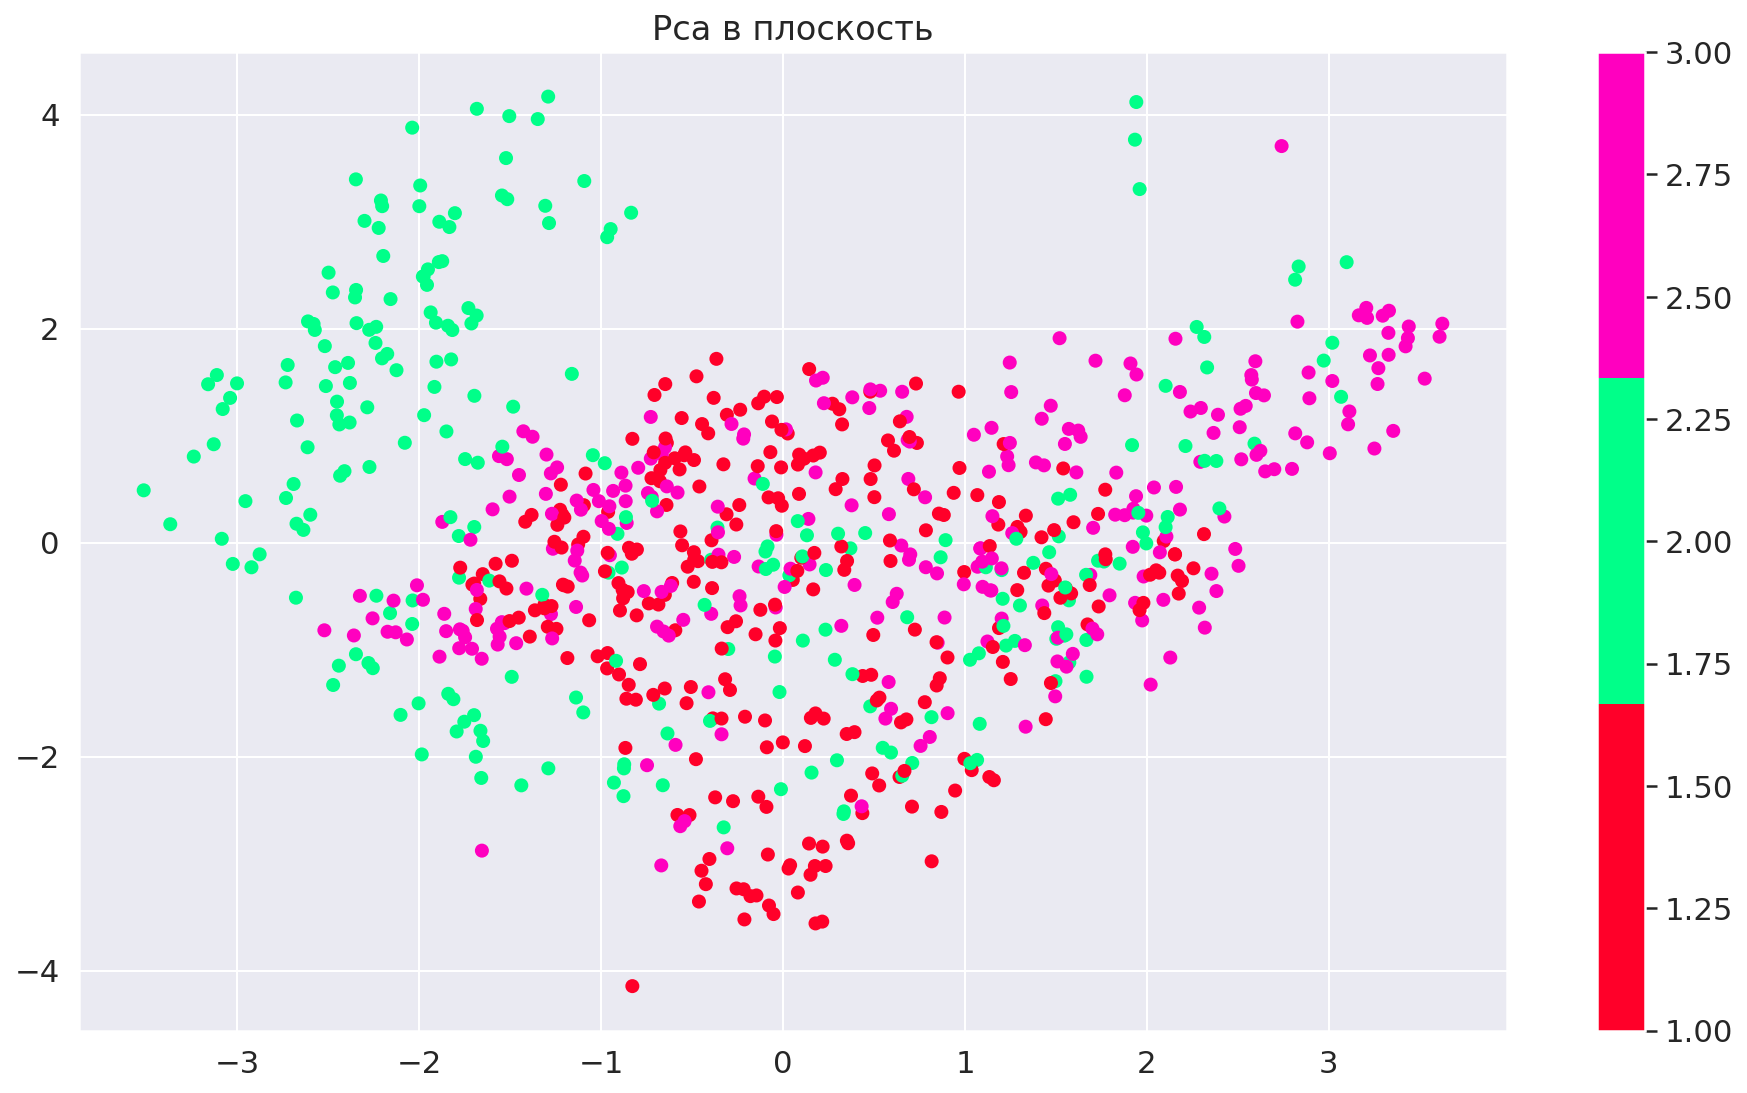

In [87]:
pca = make_basic_pipeline(PCA(n_components=2))
X_new = pca.fit_transform(X_f)
scatter_2d(X_new, y_f, (16, 9), "Pca в плоскость", cm.get_cmap('gist_rainbow', 3))

<Figure size 1512x792 with 0 Axes>

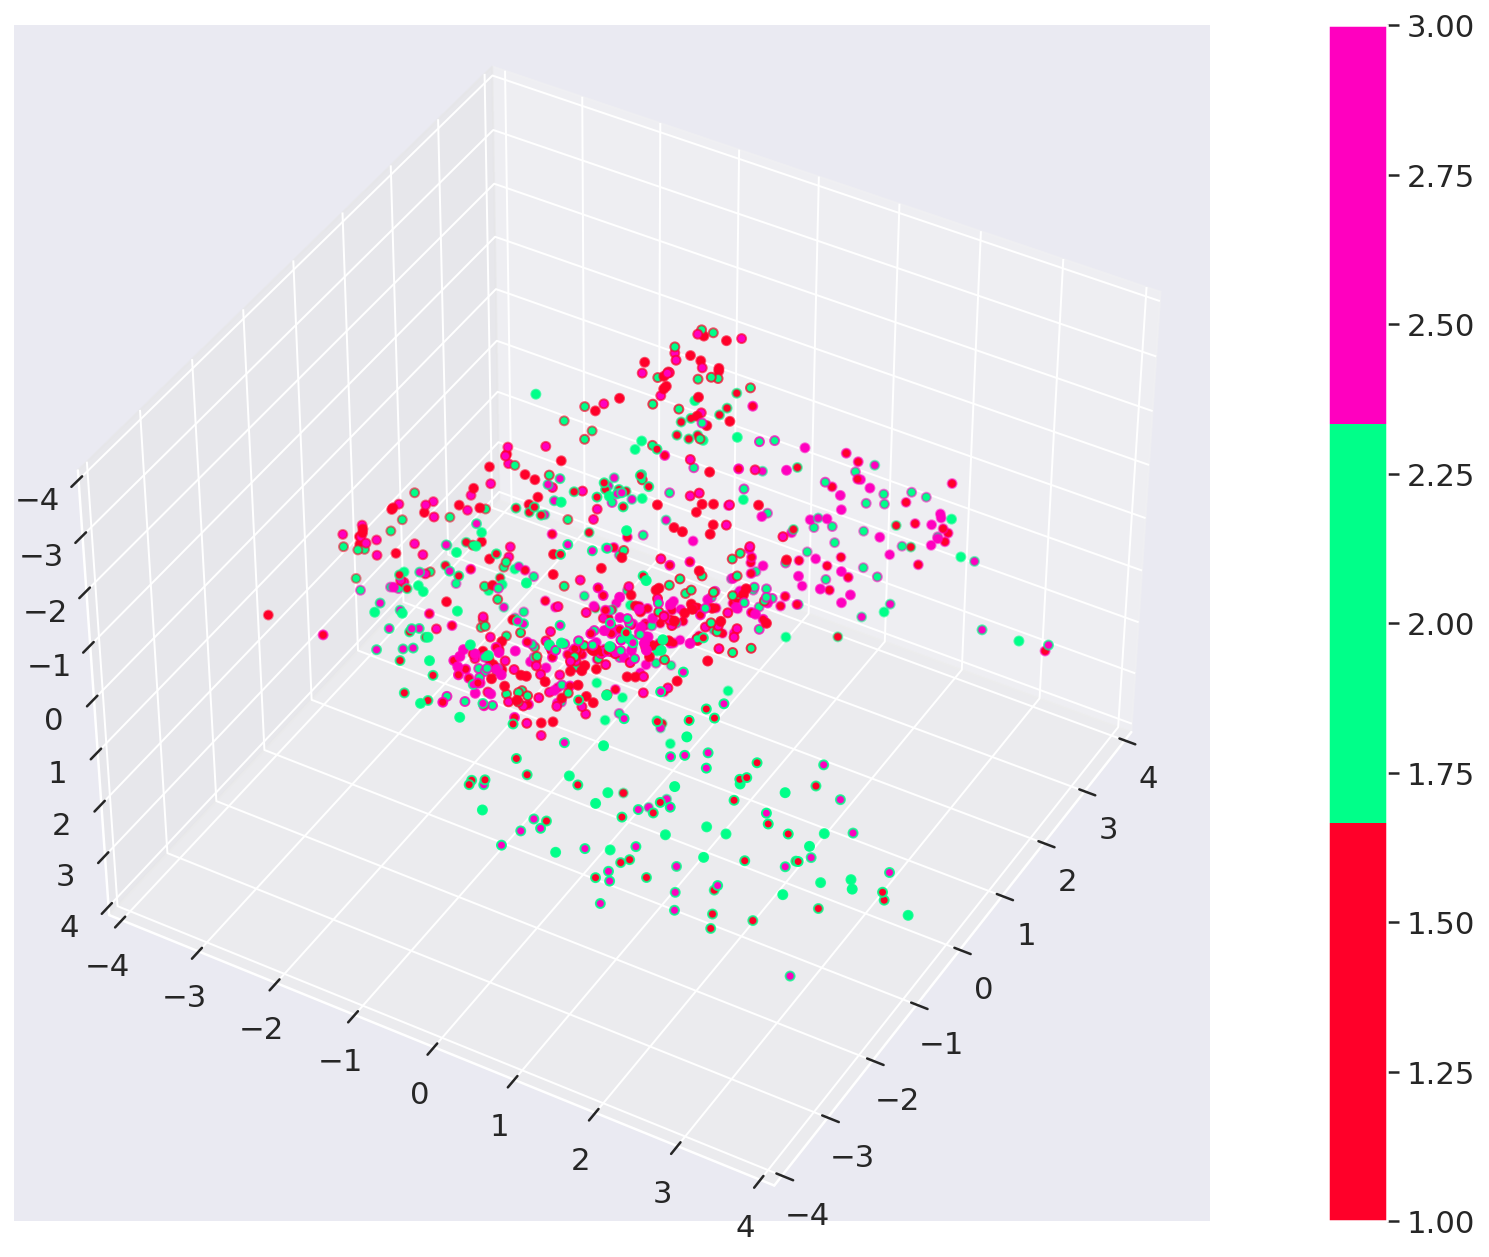

In [88]:
pca = make_basic_pipeline(PCA(n_components=3))
X_new = pca.fit_transform(X_f)
scatter_3d(X_new, y_f, (21, 11), "Pca в пр-во", cm.get_cmap('gist_rainbow', 3))

 Как видим, первый таргет не отделяется совсем от других двух. Посмотрим, что покажет Isomap.

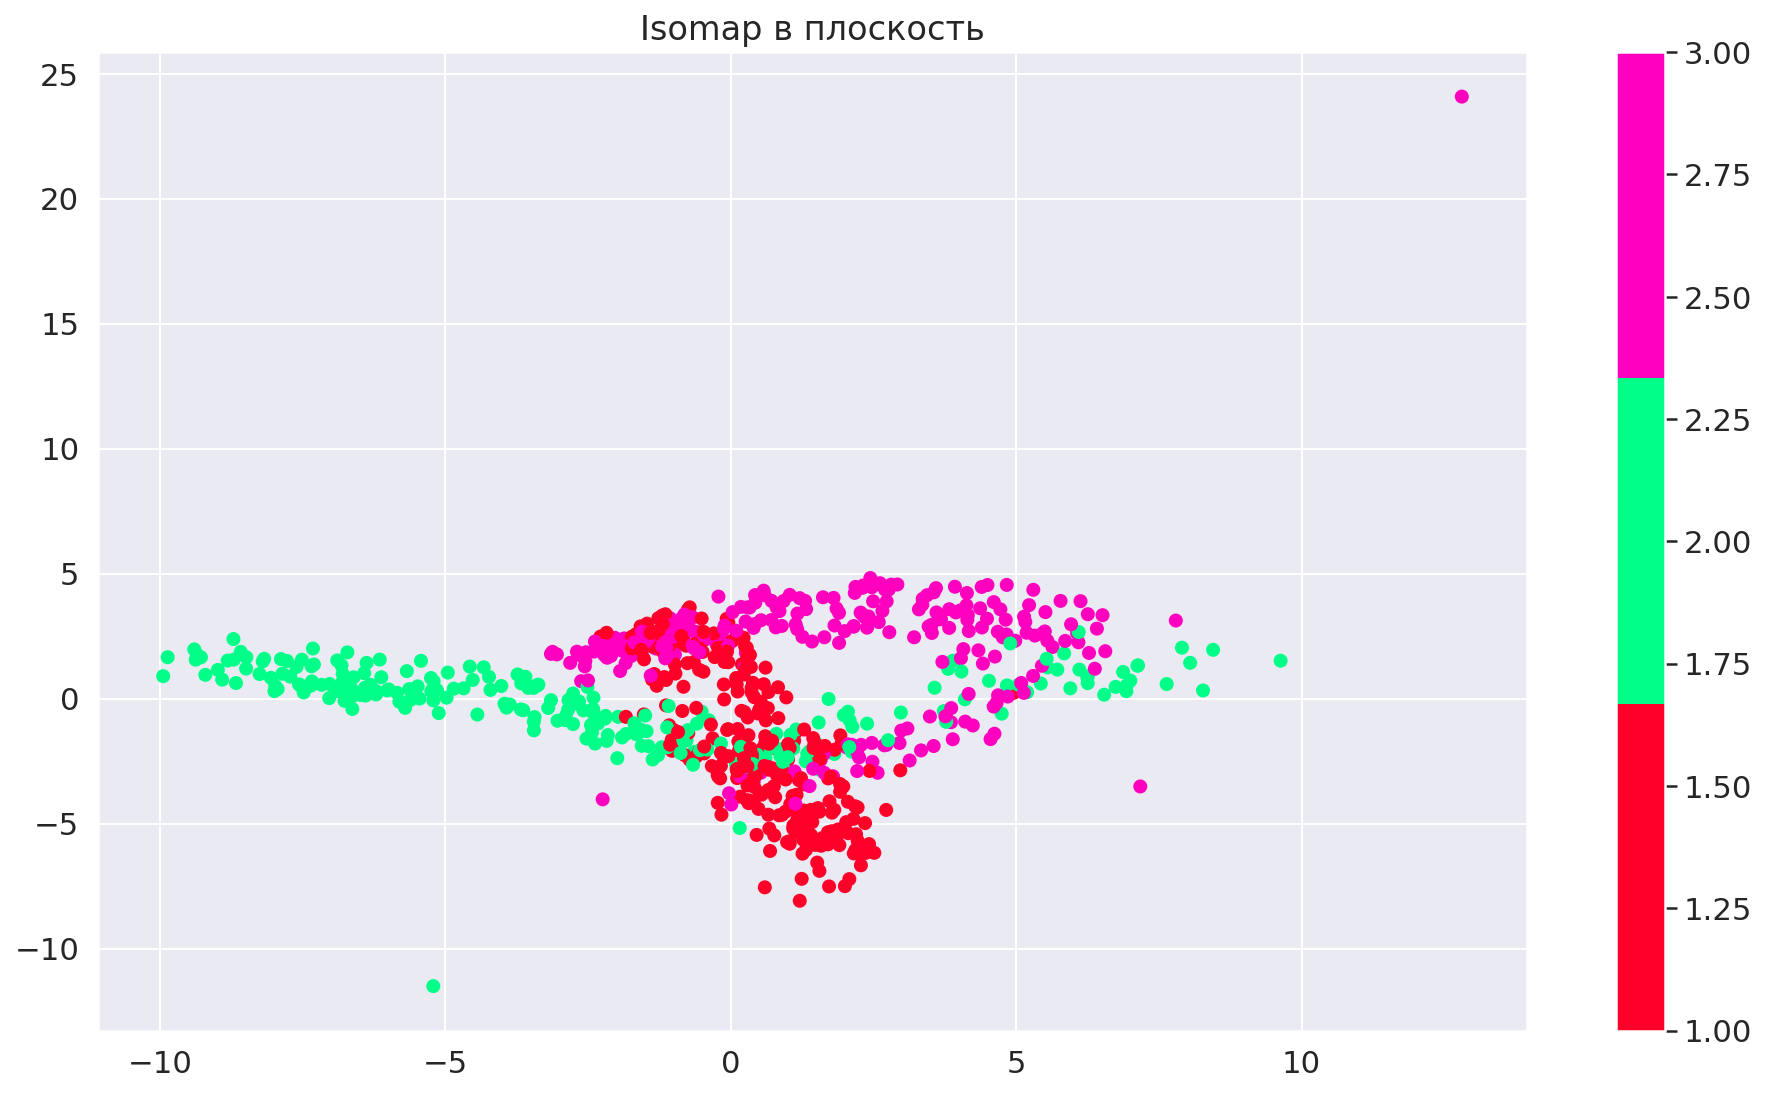

In [89]:
isomap = make_basic_pipeline(Isomap(n_components=2, n_neighbors=10))
X_new = isomap.fit_transform(X_f)
scatter_2d(X_new, y_f, (16, 9), "Isomap в плоскость", cm.get_cmap('gist_rainbow', 3))

<Figure size 1152x648 with 0 Axes>

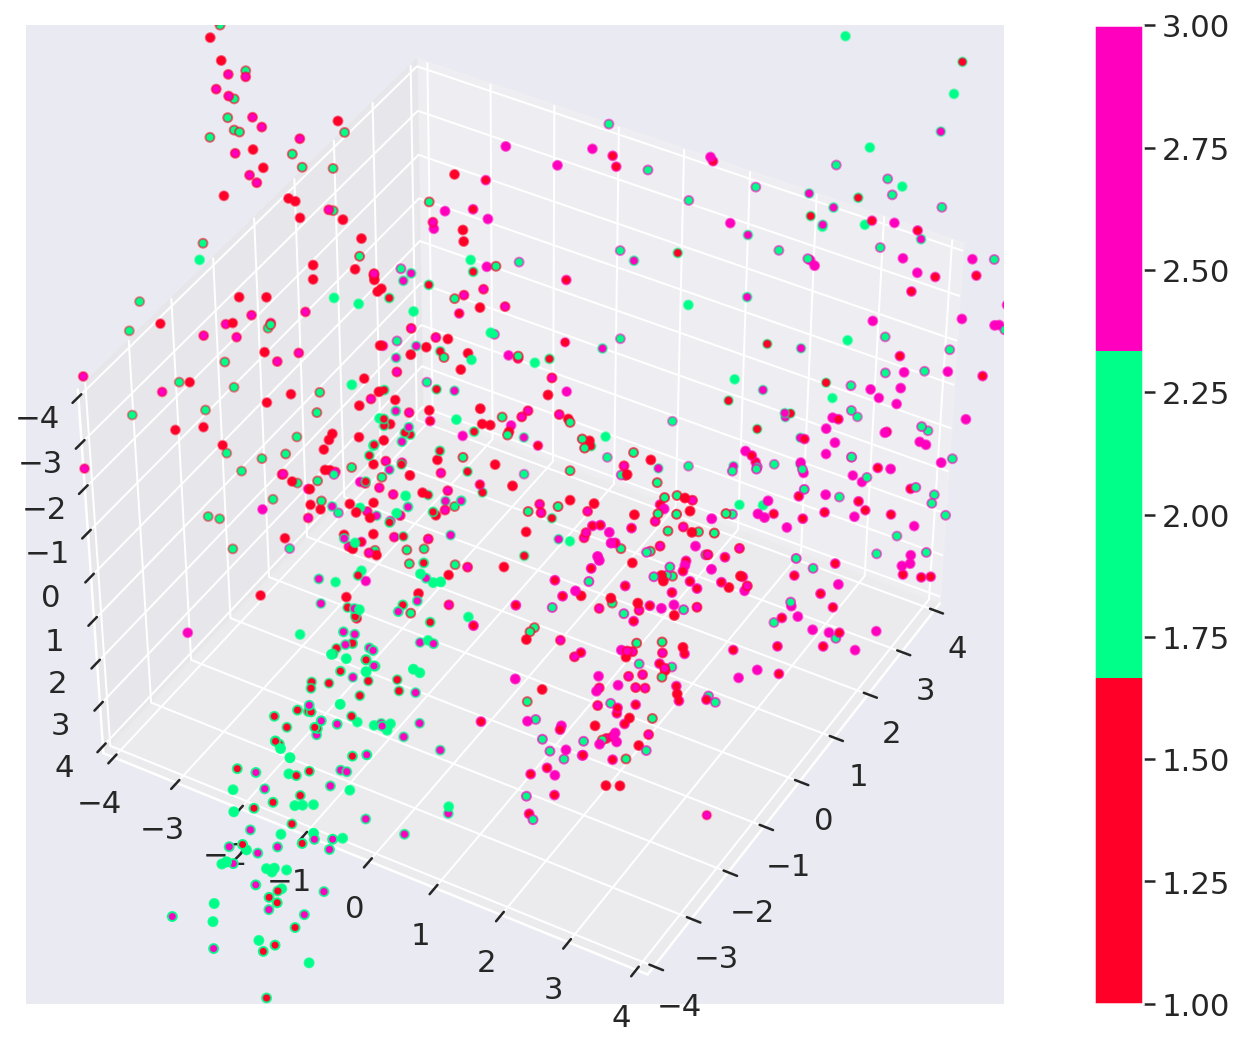

In [90]:
isomap = make_basic_pipeline(Isomap(n_components=3, n_neighbors=10))
X_new = isomap.fit_transform(X_f)
scatter_3d(X_new, y_f, (16, 9), "Isomap в пр-во",cm.get_cmap('gist_rainbow', 3))

Как видим, с Isomap немного интереснее. Для каждого значения таргета есть большая часть, когда есть четкое разделение. Однако есть несколько участков, где попарное пересечение достаточно большое.

Взглянем на LLE.

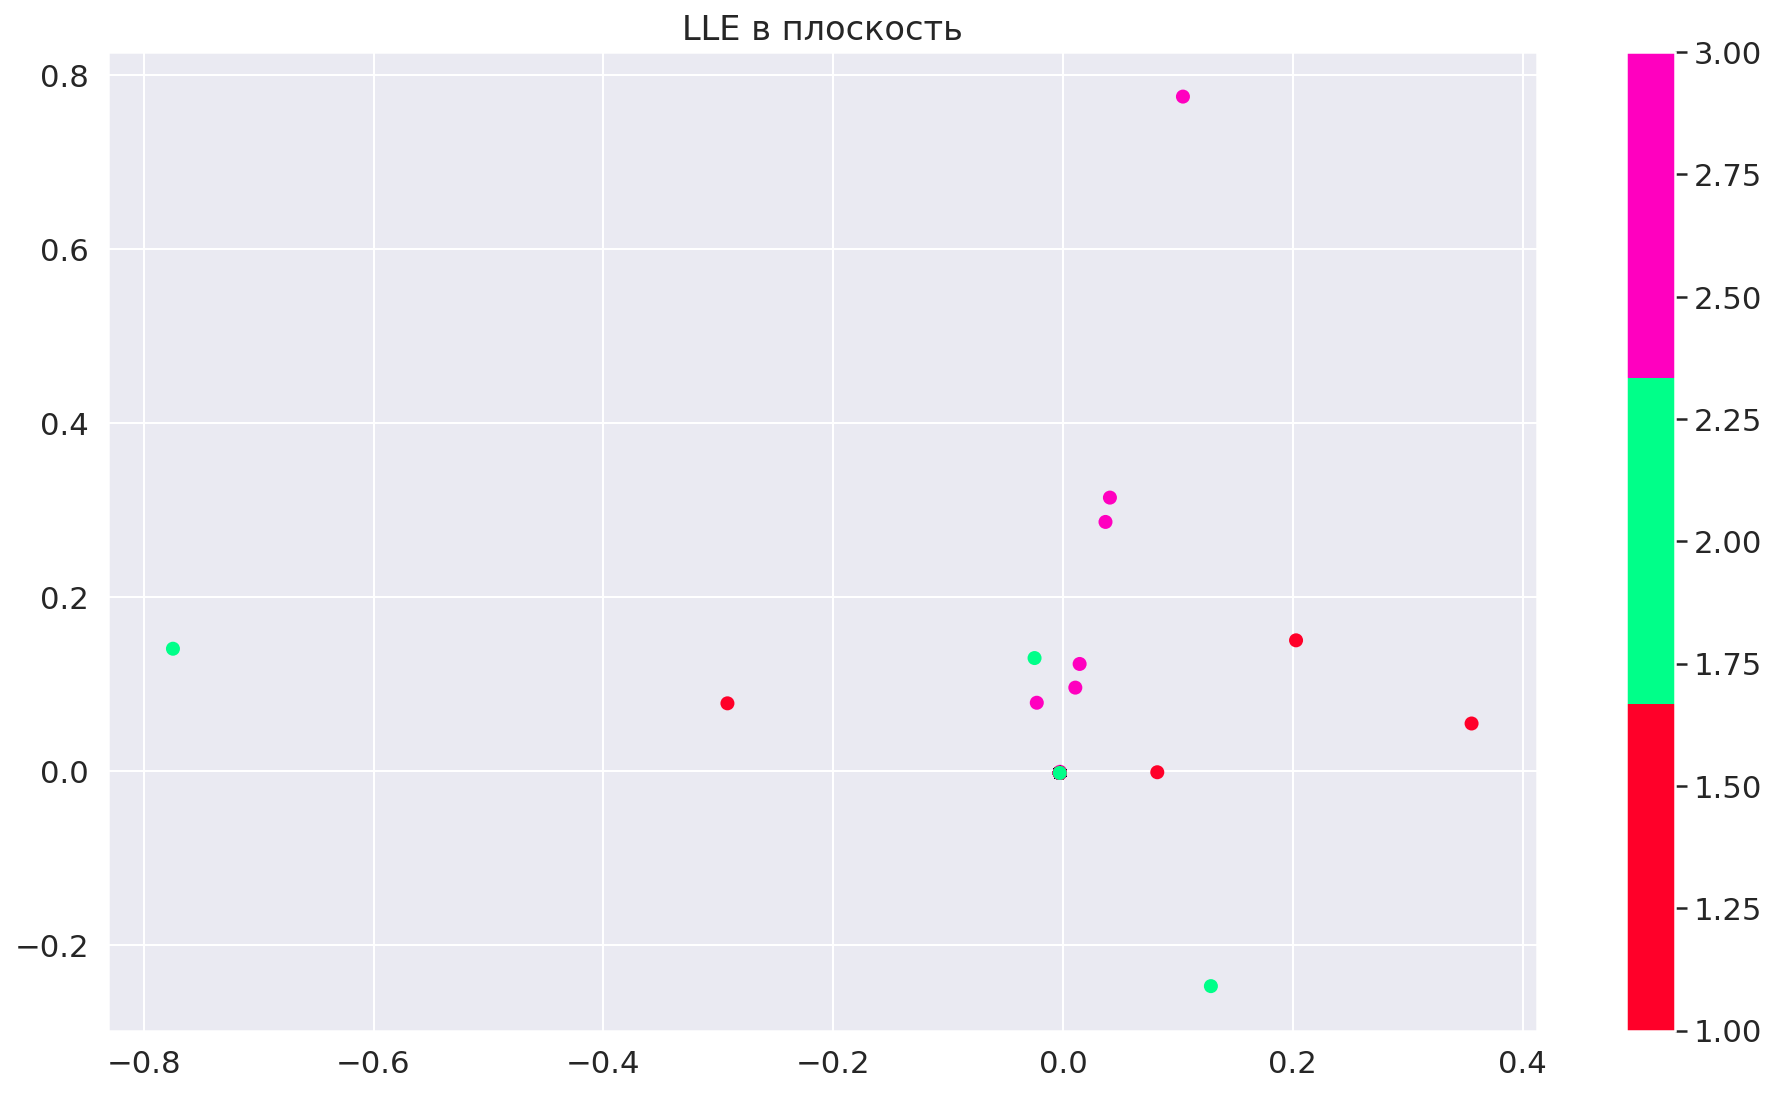

In [91]:
hlle = LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='hessian', eigen_solver='dense')
hlle.fit(X_f)
X_new = hlle.transform(X_f)
scatter_2d(X_new, y_f, (16, 9), "LLE в плоскость", cm.get_cmap('gist_rainbow', 3))

С LLE ничего хорошего не получилось.

Теперь посмотрим, как в зависимости от числа размерностей будет расти accuracy классификации при использовании метода, описанного в условии. 

In [92]:
class KnnRepeatableClassifier:
    
    def __init__(self, n):
        self.start_neigh = n
    
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        ans = np.zeros(X.shape[0])
        flags_stored = np.zeros(X.shape[0])
        it = 0 
        while len(flags_stored[flags_stored == 1]) < X.shape[0]:
            knn = KNeighborsClassifier(n_neighbors=self.start_neigh + it)
            knn.fit(self.X, self.y)
            probs = knn.predict_proba(X)
            vals = knn.predict(X)
            maxi = np.max(probs, axis = 1).reshape(-1, 1)
            eq_map = np.equal(maxi, probs).sum(axis = 1)
            ans[(eq_map == 1) & (flags_stored == 0)] = vals[(eq_map == 1) & (flags_stored == 0)]
            flags_stored[eq_map == 1] = 1
            it += 1
        return ans

In [93]:
neigh = 5
neigh_iso = 10
good_marks1, good_marks2 = [], []
for c in range(1, X_f.shape[1] + 1):
    pca = make_basic_pipeline(PCA(n_components=c))
    isomap = make_basic_pipeline(Isomap(n_components=c, n_neighbors=30))
    X_new_p = pca.fit_transform(X_f)
    X_new_iso = isomap.fit_transform(X_f)
    knn_p = KnnRepeatableClassifier(neigh)
    knn_p.fit(X_new_p, y_f)
    knn_iso = KnnRepeatableClassifier(neigh)
    knn_iso.fit(X_new_iso, y_f)
    pred_p = knn_p.predict(X_new_p)
    pred_iso = knn_iso.predict(X_new_iso)
    good_marks1.append(len(pred_p[pred_p == y_f]))
    good_marks2.append(len(pred_iso[pred_iso == y_f]))

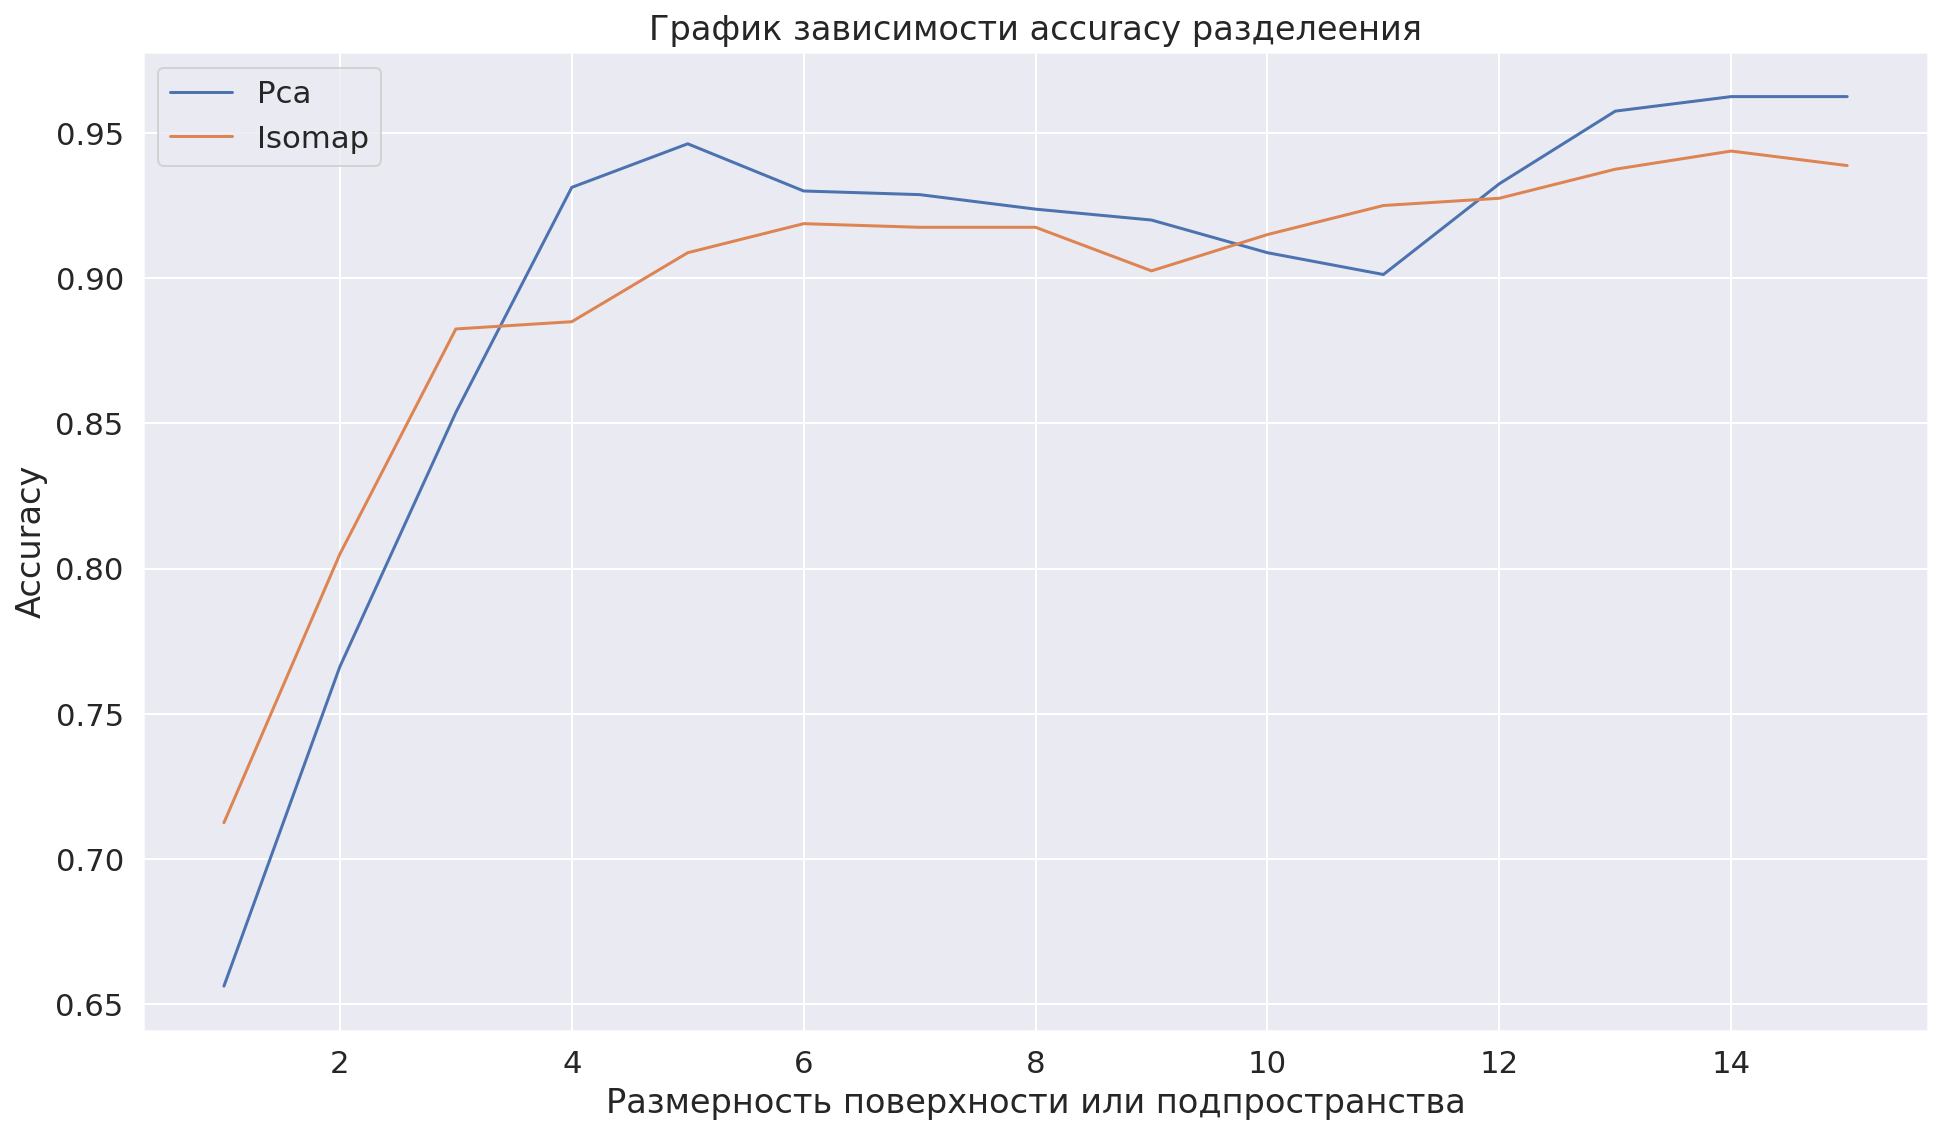

In [94]:
plt.figure(figsize=(16, 9))
plt.title("График зависимости accuracy разделеения")
plt.plot(np.arange(1, X_f.shape[1] + 1), np.array(good_marks1) / X_f.shape[0], label = "Pca")
plt.plot(np.arange(1, X_f.shape[1] + 1), np.array(good_marks2) / X_f.shape[0], label = "Isomap")
plt.xlabel("Размерность поверхности или подпространства")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Попробуем поизменять параметр числа соседей для Isomap, посмотреть на accuracy. 

In [95]:
neighs = [5, 8, 10, 14, 20, 25, 30]
good_marks = []

for n in neighs:
    acc = []
    for c in range(1, X_f.shape[1] + 1):
        isomap = make_basic_pipeline(Isomap(n_components=c, n_neighbors=n))
        X_new_iso = isomap.fit_transform(X_f)
        knn_iso = KnnRepeatableClassifier(neigh)
        knn_iso.fit(X_new_iso, y_f)
        pred_iso = knn_iso.predict(X_new_iso)
        acc.append(len(pred_iso[pred_iso == y_f]))
    good_marks.append(acc)

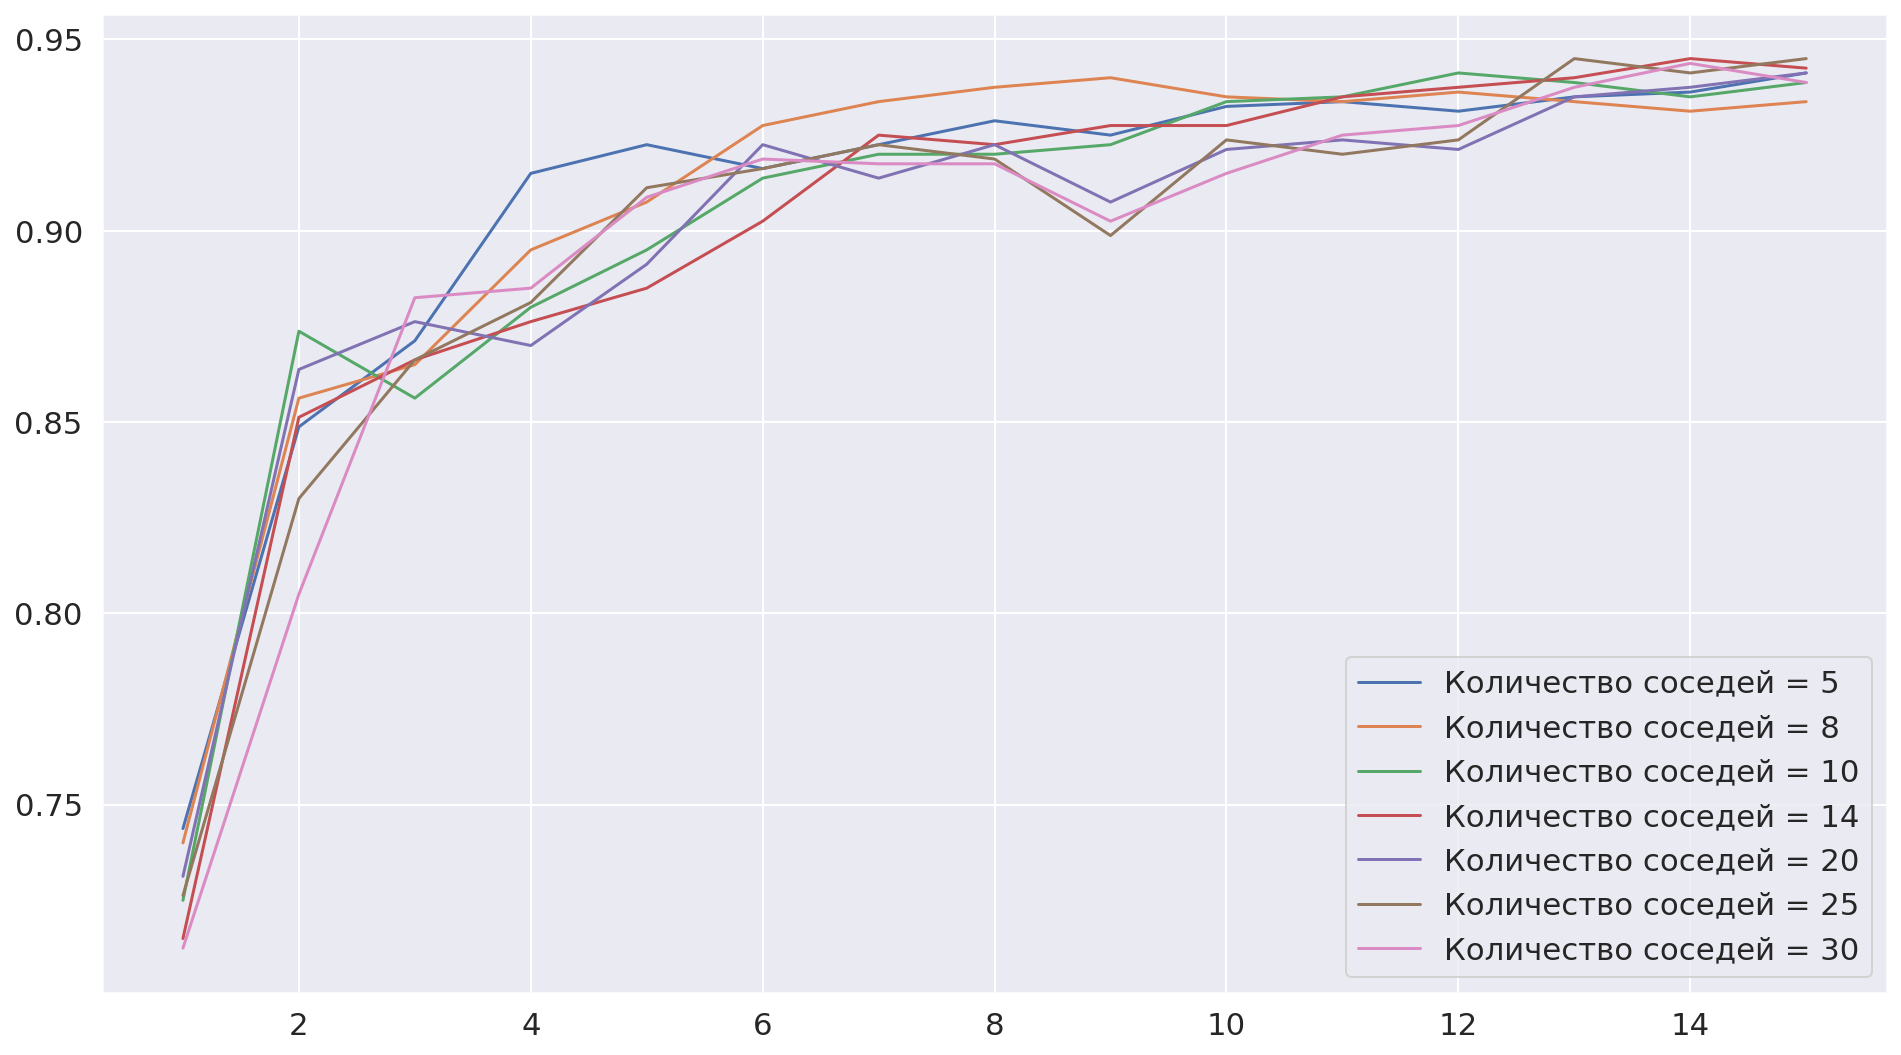

In [96]:
plt.figure(figsize=(16, 9))
for ind, nei in enumerate(neighs):
    plt.plot(np.arange(1, X_f.shape[1] + 1), np.array(good_marks[ind]) / X_f.shape[0], 
             label = f"Количество соседей = {nei}")
plt.legend()
plt.show()

Как видим, особой разницы нету. Теперь попробуем покрутить число соседей для Repeatable Knn.

In [97]:
neighs = [5, 7, 9]
good_marks_p = []
good_marks_iso = []

for n in neighs:
    acc_p = []
    acc_iso = []
    for c in range(1, X_f.shape[1] + 1):
        pca = make_basic_pipeline(PCA(n_components=c))
        isomap = make_basic_pipeline(Isomap(n_components=c, n_neighbors=20))
        X_new_p = pca.fit_transform(X_f)
        X_new_iso = isomap.fit_transform(X_f)
        knn_p = KnnRepeatableClassifier(n)
        knn_p.fit(X_new_p, y_f)
        knn_iso = KnnRepeatableClassifier(n)
        knn_iso.fit(X_new_iso, y_f)
        pred_p = knn_p.predict(X_new_p)
        pred_iso = knn_iso.predict(X_new_iso)
        acc_p.append(len(pred_p[pred_p == y_f]))
        acc_iso.append(len(pred_iso[pred_iso == y_f]))
    good_marks_p.append(acc_p)
    good_marks_iso.append(acc_iso)

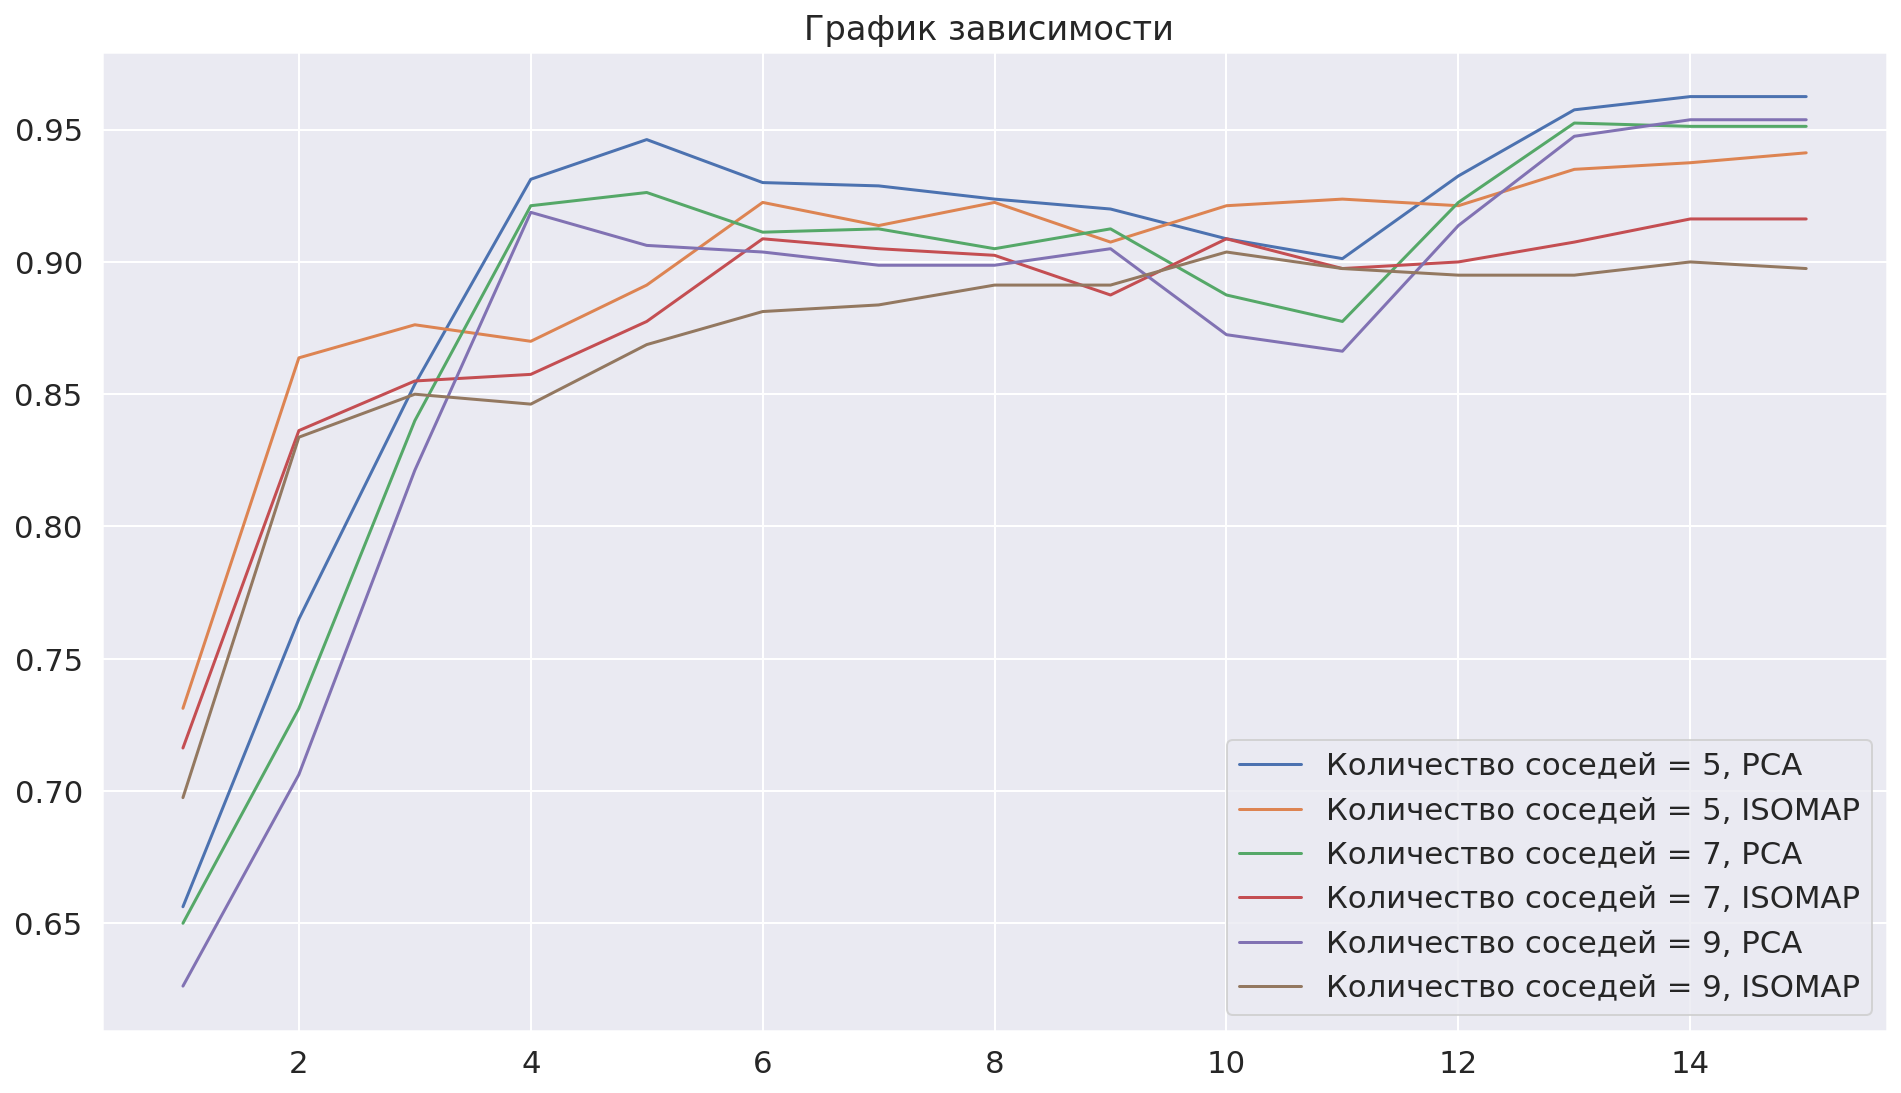

In [98]:
plt.figure(figsize=(16, 9))
plt.title("График зависимости ")
for ind, nei in enumerate(neighs):
    plt.plot(np.arange(1, X_f.shape[1] + 1), np.array(good_marks_p[ind]) / X_f.shape[0], 
             label = f"Количество соседей = {nei}, PCA")
    plt.plot(np.arange(1, X_f.shape[1] + 1), np.array(good_marks_iso[ind]) / X_f.shape[0], 
             label = f"Количество соседей = {nei}, ISOMAP")
plt.legend()
plt.show()

Как видим, 5 соседей показало наилучший результат. Но на самом деле, понятно почему с ростом соседей в knn точность падает (это правильно). Дело в том, что если мы проверяем результат на тех данных, что и обучились, то самый близкий сосед для данного элемента -- это как раз сам этот элемент (по факту, это переобучение). При количестве соседей, равных 5, эффект этого достаточно еще большой. Поэтому, кажется разумным оставить число соседей равным 7-9. 

**Итог:** В итоге получили, что при меньшей размерности Isomap дает более лучшие результаты, чем Pca. Однако с ростом числа компонент Pca в среднем немного лучше. Это можно объяснить графиком объясненной дисперсии в частности, что большая часть данных на малом числе компонент в PCA теряется, в то время как Isomap выбирает поверхность заданного размера, по которой лучше считать расстояние. Затем уже при большем количестве компонент признаки описывают объект лучше и по обычной метрике объекты, находищиеся рядом, похоже друг на друга.

Для финальной проверки результатов, посчитаем accuracy на тестовой части выборки. Ожидаем около 83-87 процентов accuracy.

In [99]:
pca = make_basic_pipeline(PCA(n_components=5))
X_new_p = pca.fit_transform(X_f)
X_new_s = pca.transform(X_s)
knn_p = KnnRepeatableClassifier(9)
knn_p.fit(X_new_p, y_f)
pred_p = knn_p.predict(X_new_s)
print("Accuracy Pca 5 components and knn neighbors 9 -- ", len(y_s[y_s == pred_p]) / X_s.shape[0])

Accuracy Pca 5 components and knn neighbors 9 --  0.88


Даже получилось немного лучше. Теперь проверим Isomap на 4 компонентах,

In [100]:
isomap = make_basic_pipeline(Isomap(n_components=4, n_neighbors = 6))
X_new_iso = isomap.fit_transform(X_f)
X_new_s = isomap.transform(X_s)
knn_iso = KnnRepeatableClassifier(9)
knn_iso.fit(X_new_iso, y_f)
pred_iso = knn_iso.predict(X_new_s)
print("Accuracy Isomap and knn neighbors 9 -- ", len(y_s[y_s == pred_iso]) / X_s.shape[0])

Accuracy Isomap and knn neighbors 9 --  0.815


 Получили немного хуже, но тоже неплохо. Результаты подтверждены.